<a id='top1'></a>  [errorbar.pdf](#errorbar) <br>
<a id='top2'></a>  [cloudcorrel.pdf](#cloud) <br>
<a id='top3'></a>  [Roc Var 1](#rocvar1)        <br>
<a id='top3'></a>  [Roc Var 2](#rocvar2)       <br>
<a id='top4'></a>  [Dnet](#dnet)             <br>
<a id='top5'></a>  [get_scores](#scores)       <br>

In [1]:
pwd

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#@title imports
import os
from tqdm.notebook import tqdm as tqdm
import random
import math
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from torchmetrics.regression import KLDivergence
import scipy
from scipy import interpolate
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# to ignore the warnings
from warnings import filterwarnings
import dcor
from sklearn.feature_selection import mutual_info_regression
from astropy.table import Table
from sklearn.metrics import auc as calc_auc, det_curve
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.metrics import RocCurveDisplay, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score as calc_auroc
from sklearn.model_selection import train_test_split
import sklearn
from itertools import combinations
import plotly.express as px

In [3]:
from robustbench.utils import load_model, clean_accuracy

In [4]:
from scoreslib import *
from calibration import *
from modeling import *
from nbutils import *

In [5]:
transform = transforms.Compose([transforms.ToTensor(),])
dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                        download=True, transform=transform)

valid_size = 5000
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-valid_size, valid_size])
##TRAIN
dts = train_set.dataset.data[train_set.indices]
train_original= torch.stack([transform(img) for img in dts])
train_targets = torch.tensor(train_set.dataset.targets, dtype=torch.int64)[train_set.indices]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                          shuffle=True, num_workers=2)
##VAL
dts = val_set.dataset.data[val_set.indices]
val_original= torch.stack([transform(img) for img in dts])
val_targets = torch.tensor(val_set.dataset.targets, dtype=torch.int64)[val_set.indices]
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128,
                                          shuffle=False, num_workers=2)
##TEST
test_set = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                download=True, transform=transform)
original= torch.stack([transform(img) for img in test_set.data])
targets = torch.tensor(test_set.targets, dtype=torch.int64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128,
                                          shuffle=False, num_workers=2)
labels_oneh = torch.nn.functional.one_hot(targets, num_classes=10)

Files already downloaded and verified
Files already downloaded and verified


In [114]:
model='Addepalli2021Towards_RN18'
path = get_path(model)
adversarial = torch.load(path+"/fab_adverserialevm512.pt", map_location='cpu')

In [6]:
gf = get_filenames_in_folder('../xps/cifar10')
gf.sort()#[0][:-5]
len(gf),gf

(29,
 ['Addepalli2021Towards_RN18_Linf_New',
  'Addepalli2022Efficient_RN18_Linf_New',
  'Cui2023Decoupled_WRN-28-10_Linf_New',
  'Debenedetti2022Light_XCiT-M12_Linf_New',
  'Debenedetti2022Light_XCiT-S12_Linf_New',
  'Ding2020MMA_Linf_New',
  'Engstrom2019Robustness_Linf_New',
  'Hendrycks2019Using_Linf_New',
  'Pang2022Robustness_WRN28_10_Linf_New',
  'Rebuffi2021Fixing_28_10_cutmix_ddpm_Linf_New',
  'ResNet18_Linf_New',
  'ResNet50_Linf_New',
  'Sehwag2021Proxy_R18_Linf_New',
  'Standard_Linf_New',
  'Wang2023Better_WRN-28-10_Linf_New',
  'Xu2023Exploring_WRN-28-10_Linf_New',
  'Zhang2019Theoretically_Linf_New',
  'alp_loss_r18_ckpt_Linf_New',
  'ce_loss_r18_ckpt_Linf_New',
  'cifar10',
  'cifar10_resnet20_Linf_New',
  'cifar10_resnet32_Linf_New',
  'cifar10_resnet44_Linf_New',
  'cifar10_resnet56_Linf_New',
  'clp_loss_r18_ckpt_Linf_New',
  'madry_loss_r18_ckpt_Linf_New',
  'mart_loss_r18_ckpt_Linf_New',
  'mma_loss_r18_ckpt_Linf_New',
  'trades_loss_r18_ckpt_Linf_New'])

In [7]:
tmpmodels=[x for x in get_filenames_in_folder('../xps/cifar10')]#[0][:-5]]
# tmpco
models=[x[:-9] for x in tmpmodels]
pseudos =[getps(model) for model in models]
print(list(zip(models, pseudos)))

[('Ding2020MMA', 'Ding2020MMA'), ('Debenedetti2022Light_XCiT-S12', 'Debenedetti20'), ('Xu2023Exploring_WRN-28-10', 'Xu2023Explori'), ('Debenedetti2022Light_XCiT-M12', 'Debenedetti20'), ('mart_loss_r18_ckpt', 'mart'), ('cifar10_resnet44', 'resnet44'), ('madry_loss_r18_ckpt', 'madry'), ('cifar10_resnet32', 'resnet32'), ('Sehwag2021Proxy_R18', 'Sehwag2021Pro'), ('Pang2022Robustness_WRN28_10', 'Pang2022Robus'), ('Hendrycks2019Using', 'Hendrycks2019'), ('trades_loss_r18_ckpt', 'trades'), ('clp_loss_r18_ckpt', 'clp'), ('Standard', 'Standard'), ('Engstrom2019Robustness', 'Engstrom2019R'), ('alp_loss_r18_ckpt', 'alp'), ('Addepalli2022Efficient_RN18', 'Addepalli2022'), ('Cui2023Decoupled_WRN-28-10', 'Cui2023Decoup'), ('Rebuffi2021Fixing_28_10_cutmix_ddpm', 'Rebuffi2021Fi'), ('cifar10_resnet56', 'resnet56'), ('cifar10_resnet20', 'resnet20'), ('Zhang2019Theoretically', 'Zhang2019Theo'), ('Wang2023Better_WRN-28-10', 'Wang2023Bette'), ('ResNet18', 'ResNet18'), ('ResNet50', 'ResNet50'), ('Addepalli2

In [8]:
# [model for model in models if 'ckpt' not in model and 'cifar10' not in model]
rbenchmodels = ['Ding2020MMA',
 'Xu2023Exploring_WRN-28-10',
 'Sehwag2021Proxy_R18',
 'Pang2022Robustness_WRN28_10',
 'Hendrycks2019Using',
 'Standard',
 'Engstrom2019Robustness',
 'Addepalli2022Efficient_RN18',
 'Cui2023Decoupled_WRN-28-10',
 'Rebuffi2021Fixing_28_10_cutmix_ddpm',
 'Zhang2019Theoretically',
 'Wang2023Better_WRN-28-10',
 'Addepalli2021Towards_RN18',
 'Debenedetti2022Light_XCiT-S12']

In [9]:
tablinf = Table.read('/Users/nj/Documents/notebooks/textables/zoolinf.tex').to_pandas()
tablinf['Clean accuracy'] = tablinf['Clean accuracy'].map(lambda x: float(x.split('\%')[0]))
tablinf['Robust accuracy'] = tablinf['Robust accuracy'].map(lambda x: float(x.split('\%')[0]))
tablinf['Model ID'] = tablinf['Model ID'].map(lambda x: x.replace("\\",""))

In [10]:
clean_accuracies = dict()
robust_accuracies=dict()
architectures=dict()
rtable = pd.read_csv('../cifar10results.csv')
for model in models:
#     if 'loss' in model or model in ['ResNet18', 'ResNet50']:
#         continue
    if 'loss' in model:
        loss = model.split('_loss')[0]
        clean_accuracies[model] = rtable[rtable['loss']==loss]['clean acc'].to_numpy()[0]
        robust_accuracies[model] = rtable[rtable['loss']==loss]['auto-attack'].to_numpy()[0]
        architectures[model]='ResNet-18'
    elif model in ['ResNet18', 'ResNet50']:
        clean_accuracies[model] = 93.07 if model =='ResNet18' else 93.65
        robust_accuracies[model] = 0
        architectures[model]='ResNet-18' if 'ResNet18' in model else 'ResNet-50'
    elif 'cifar10' in model:
        if model=='cifar10_resnet20':
            clean_accuracies[model] = 92.60
        if model=='cifar10_resnet32':
            clean_accuracies[model]=93.53
        if model=='cifar10_resnet44':
            clean_accuracies[model]= 94.01
        if model=='cifar10_resnet56':
            clean_accuracies[model]= 94.37
        robust_accuracies[model] = 0
        architectures[model] = model.split('_')[1]
    else:
        clean_accuracies[model]=tablinf[tablinf['Model ID']==model]\
        ['Clean accuracy'].to_numpy()[0]
        robust_accuracies[model]=tablinf[tablinf['Model ID']==model]\
        ['Robust accuracy'].to_numpy()[0]
        architectures[model] = tablinf[tablinf['Model ID']==model]['Architecture'].to_numpy()[0]

In [11]:
models=[m for m in models if robust_accuracies[m]>1]
# models.append('Standard')
models, len(models)

(['Ding2020MMA',
  'Debenedetti2022Light_XCiT-S12',
  'Xu2023Exploring_WRN-28-10',
  'Debenedetti2022Light_XCiT-M12',
  'mart_loss_r18_ckpt',
  'madry_loss_r18_ckpt',
  'Sehwag2021Proxy_R18',
  'Pang2022Robustness_WRN28_10',
  'Hendrycks2019Using',
  'trades_loss_r18_ckpt',
  'clp_loss_r18_ckpt',
  'Engstrom2019Robustness',
  'alp_loss_r18_ckpt',
  'Addepalli2022Efficient_RN18',
  'Cui2023Decoupled_WRN-28-10',
  'Rebuffi2021Fixing_28_10_cutmix_ddpm',
  'Zhang2019Theoretically',
  'Wang2023Better_WRN-28-10',
  'Addepalli2021Towards_RN18'],
 19)

In [13]:
# # model='Addepalli2021Towards_RN18'
# W21cache1 = dict()
# W21cache2 = dict()
# # fig, ax = plt.subplots(nrows=2, ncols=2)
# for model in tqdm(models):
#     W = get_fc_head_weight(model)
#     W21stars1=dict()
#     W21stars2=dict()
#     for i, j in list(combinations(np.arange(10),2)):
#         w21star1 = torch.linalg.vector_norm((W[i]-W[j]).detach(), ord=1)
#         w21star2 = torch.linalg.vector_norm((W[i]-W[j]).detach(), ord=2)
#         W21stars1[(i,j)] = w21star1
#         W21stars2[(i,j)] = w21star2
#     y = np.array([float(e) for e in list(W21stars1.values())])
#     W21cache1[model]=y
#     y = np.array([float(e) for e in list(W21stars2.values())])
#     W21cache2[model]=y

In [14]:
W21cache1 = dict()
for model in tqdm(models):
    W21cache1[model]=None

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 581691.80it/s]


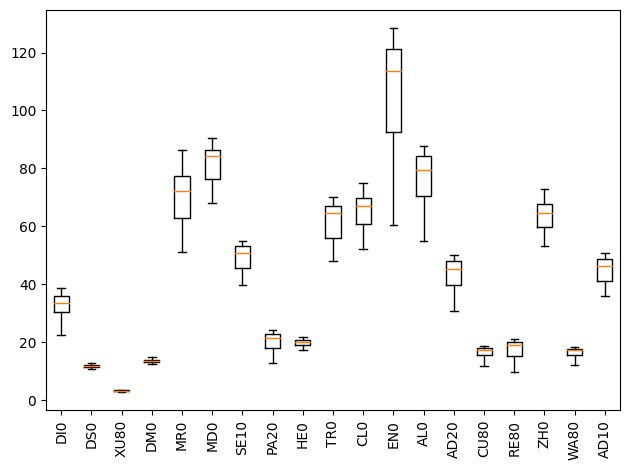

In [16]:
bp = []
for i, model in enumerate(models):
    y = W21cache1[model]
#     y = (y-min(y))/(max(y)-min(y))
    bp.append(y)
plt.boxplot(bp, showfliers=False)
# plt.set_title(getps(model, code=True, dataset='cifar10'))
names = [getps(model, code=True, dataset='cifar10') for model in models]
plt.xticks(np.arange(1, len(models)+1), names, rotation=90)
plt.tight_layout()
plt.savefig('equidbox.pdf', bbox_inches='tight')
plt.show()


In [484]:
for i, model in enumerate(models[6:7]):
    W = get_fc_head_weight(model, dataset='cifar10', thread_norm='Linf')
    w21star = W21cache1[model]
    top2 = torch.topk(logits, 2)[1]
    t1 = top2[:,0]
    f1 = logits[torch.arange(len(logits)), t1]
    t2 = top2[:,1]
    w21star = torch.linalg.norm((W[t1]-W[t2]).detach(), ord=1, dim=1)
    f2 = logits[torch.arange(len(logits)), t2]
    dist = (f1-f2)/w21star
    featprime=dist.view(-1,1)*(W[t1]-W[t2]).detach()
#########
    featpath=get_feat_path(model)
    featadvpath = get_feat_path(model, adv=True)
    feat = torch.load(featpath, map_location=torch.device('cpu'))
    feat_adv = torch.load(featadvpath, map_location=torch.device('cpu'))
#######
    ecart = calc_drep(featprime, feat_adv)
    db = calc_drep(feat, featprime)
    hhp = calc_drep(feat, feat_adv)

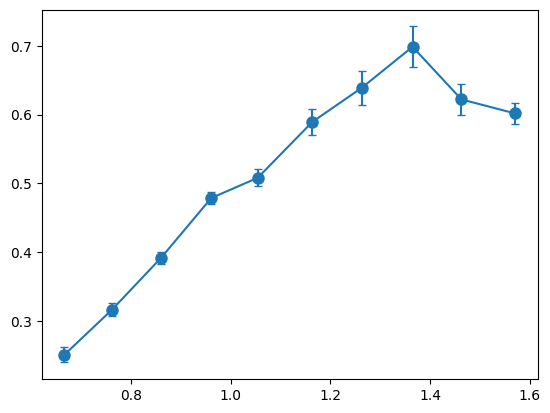

In [493]:
# idx, x = lq2(ecart)
# y = hhp[idx]
# plx(x,y);

In [23]:
# plt.boxplot([ecart, db, hhp], showfliers=False);
# plt.xticks([1,2,3], ["$\|h'-z'\|$", "$\|z-z'\|$", "$\|h-h'\|$"]);

In [475]:
# x = unfilteredmodelscores[model]['feature dist']
calc_drep(feat, feat_adv, norm=float('inf'))
# unfilteredmodelscores[model]['feature dist']


tensor([0.2273, 0.4341, 0.3653,  ..., 0.5030, 0.7354, 0.7823])

In [ ]:
# for i, model in enumerate(models[:1]):
#     y = W21cache1[model]
#     top2 = torch.topk(logits, 2)[1]
#     t1 = top2[:,0]
#     f1 = logits[torch.arange(len(logits)), t1]
#     if w21cache is None:
#         t2 = top2[:,1]
#         w21star = torch.linalg.norm((W[t1]-W[t2]).detach(), ord=1, dim=1)
#         f2 = logits[torch.arange(len(logits)), t2]
#         dist = torch.abs(f1-f2)/w21star
#     else:
#         dmin = torch.ones_like(t1)*torch.inf
#         for j in tqdm(range(num_classes)):
#             t2 =torch.tensor([j]*len(t1))
#             f2 = logits[torch.arange(len(logits)), t2]
#             k = torch.tensor([get_k(i,j) for (i,j) in list(zip(t1,t2))])
#             f1f2 = torch.where(k==-1, torch.inf, f1-f2)
#             dist = torch.abs(f1f2)/w21cache[k]
#             dmin = torch.where(dist<dmin, dist, dmin)
#         return dmin, t1, t2

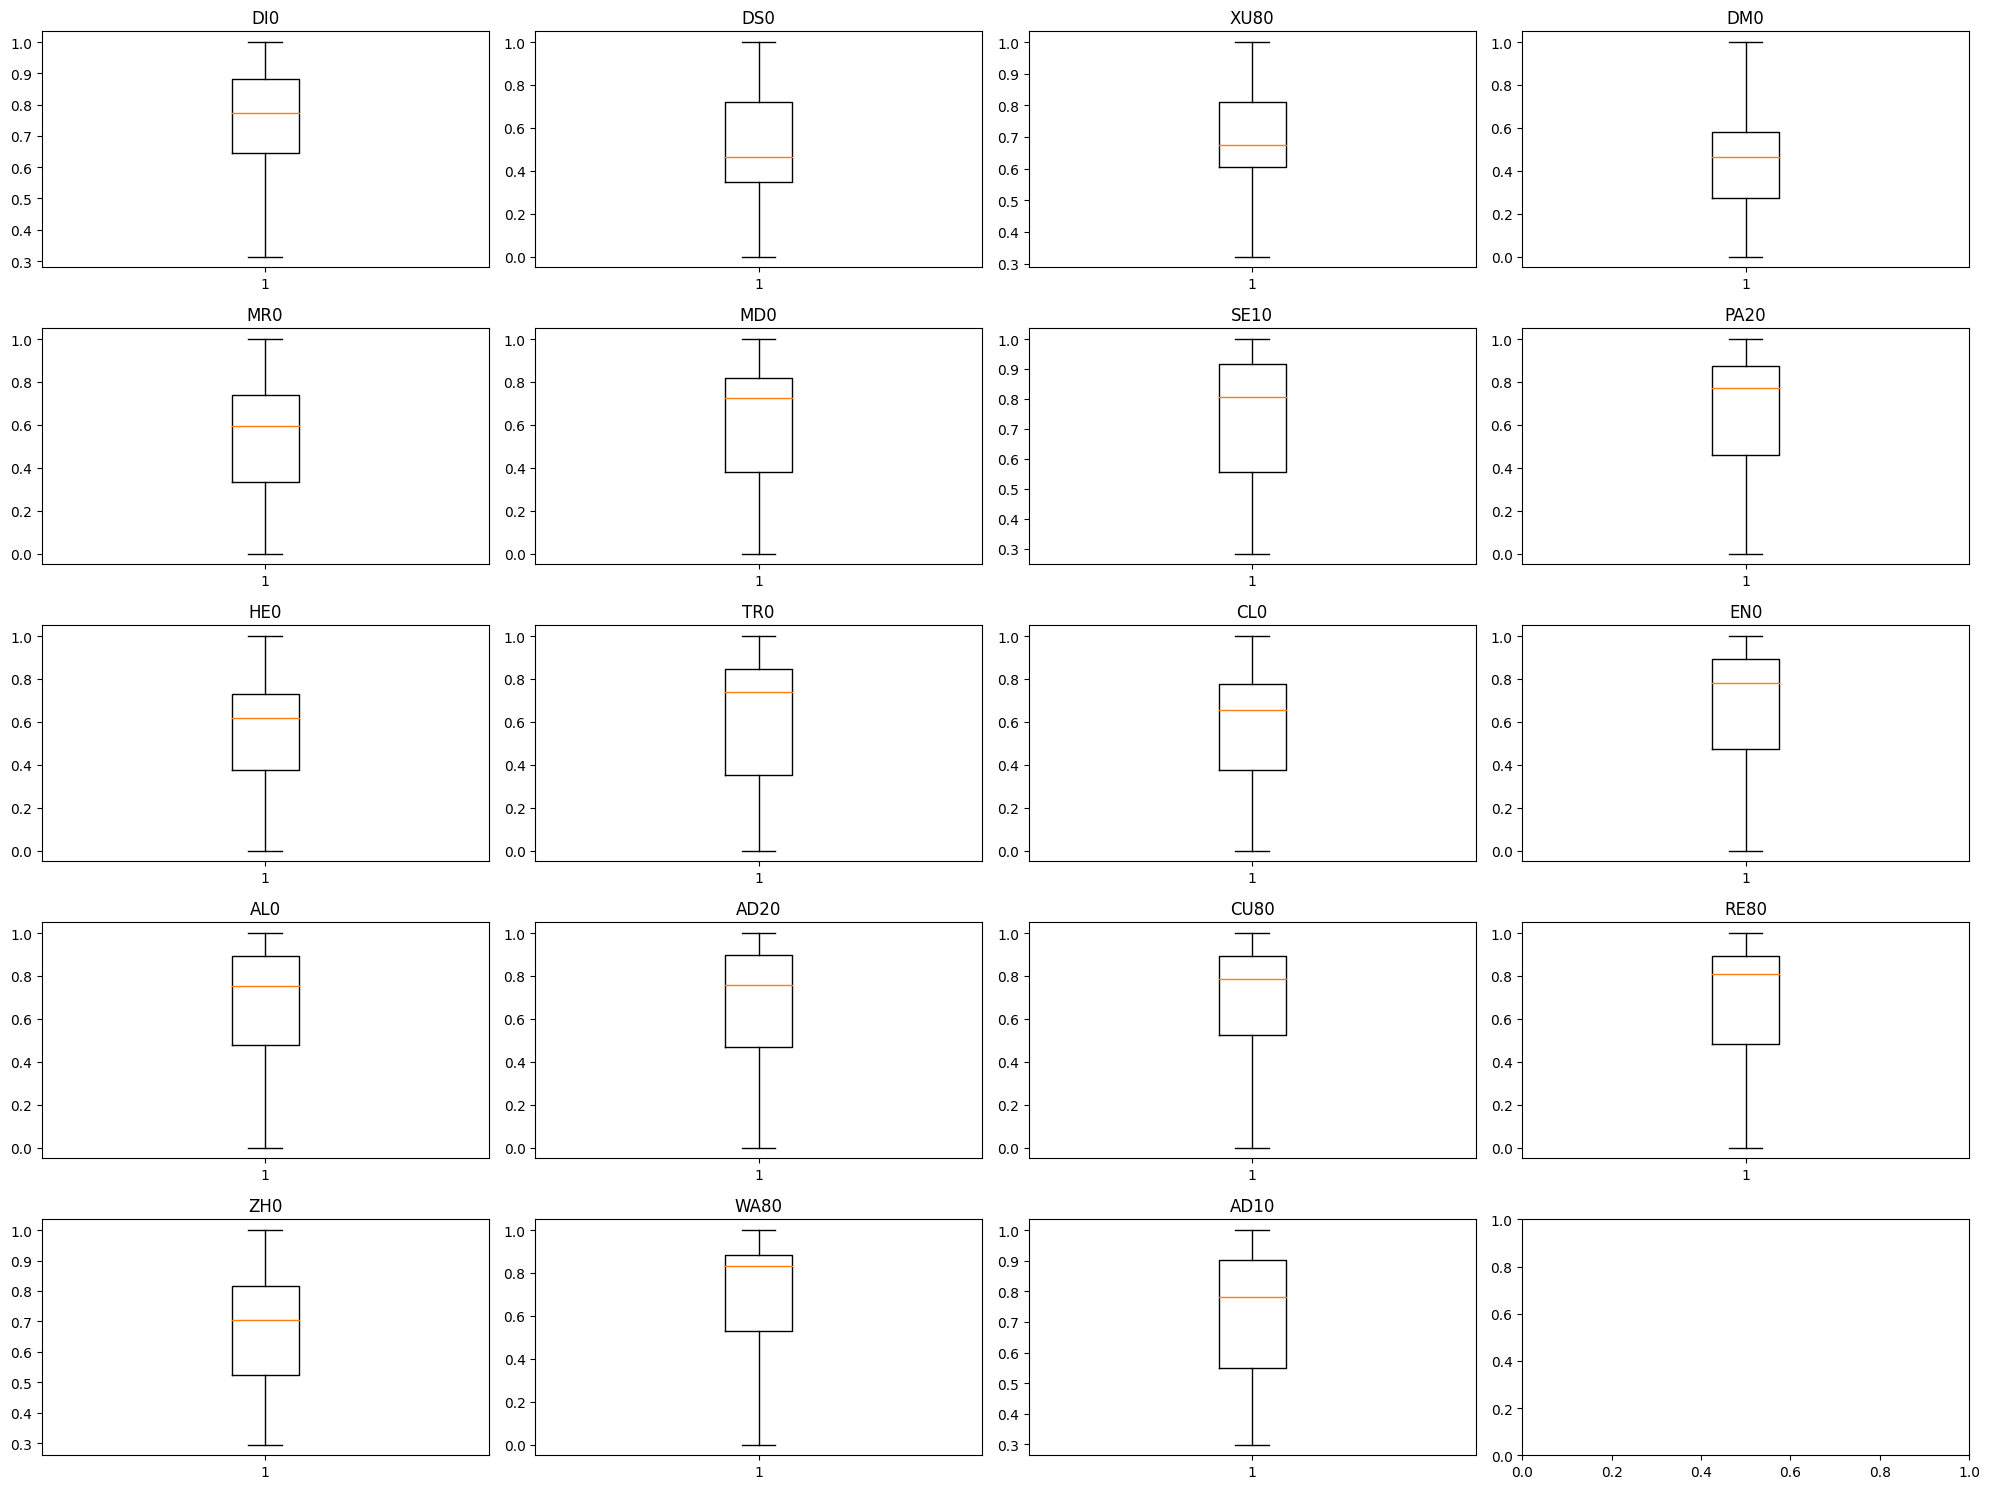

In [450]:
# Assuming 'models' is a list containing the model names
num_rows, num_cols = 5, 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15))

for i, model in enumerate(models):
    row, col = divmod(i, num_cols)
    y = W21cache1[model]
    y = (y-min(y))/(max(y)-min(y))
    axs[row, col].boxplot(y, showfliers=False)
    axs[row, col].set_title(getps(model, code=True, dataset='cifar10'))
#     axs[row, col].legend()
# plt.ylabel("$\\|w_i-wj\|$")
plt.tight_layout()
plt.savefig('equidbox.pdf')
plt.show()


In [ ]:
unfilt

In [22]:
# model='Standard'
# out = torch.load(fget_out_path(model), map_location=torch.device('cpu'))
# z = get_outdist(model, out, dataset='cifar10')
# path1 = get_path(model)+"/fab_results_evm512.csv"
# df = pd.read_csv(path1)
# df = df.rename(str.lower, axis='columns')
# dfs[model] = df

In [15]:
# outpath=get_out_path(model, extra=False)
# out = torch.load(outpath, map_location=torch.device('cpu'))
# z = calc_lmargin(out)

In [16]:
# scipy.stats.kendalltau(z, df['norm inf'])[0]

In [15]:
dfs =dict()
ytargets=dict()
for i, model in enumerate(models):
    path1 = get_path(model)+"/fab_results_evm512.csv"
    df = pd.read_csv(path1)
    df = df.rename(str.lower, axis='columns')
#     df = df.rename(columns={f'fab norm inf': 'norm'})
    dfs[model] = df
    path1 = get_path(model)+"/fab_ytrueevm512.pt" #f'./fab/{models[i]}_fab/results.csv'
    _targets = torch.load(path1)
    ytargets[model]=_targets

In [16]:
extradfs =dict()
extratargets=dict()
for i, model in enumerate(models):
    path1 = get_path(model)+"/extrafab_results_evm512.csv" #f'./fab/{models[i]}_fab/results.csv'
    if os.path.exists(path1):
        df = pd.read_csv(path1)
        df = df.rename(str.lower, axis='columns')
    #     df = df.rename(columns={f'fab norm inf': 'norm'})
        extradfs[model] = df
        path1 = get_path(model)+"/extrafab_ytrueevm512.pt" #f'./fab/{models[i]}_fab/results.csv'
        _targets = torch.load(path1)
        extratargets[model]=_targets

In [17]:
list(extradfs.keys())

['Ding2020MMA',
 'Xu2023Exploring_WRN-28-10',
 'Sehwag2021Proxy_R18',
 'Pang2022Robustness_WRN28_10',
 'Hendrycks2019Using',
 'Engstrom2019Robustness',
 'Addepalli2022Efficient_RN18',
 'Cui2023Decoupled_WRN-28-10',
 'Rebuffi2021Fixing_28_10_cutmix_ddpm',
 'Zhang2019Theoretically',
 'Wang2023Better_WRN-28-10',
 'Addepalli2021Towards_RN18']

In [18]:
def test(f, g):
    dft = pd.read_csv(g)
    print(np.mean(dft['Acc']==True), clean_accuracies[model])
    
    ftr = dft['Adv']==True
    out = torch.load(f, map_location='cpu')
    out, dft = out[ftr], dft[ftr]

    hout = calc_entropy(out)
    houtprev = torch.tensor(dft['Entropy'].to_numpy(), dtype=torch.float32)
    print(len(hout), len(houtprev))
    assert len(hout)//100==99
    torch.testing.assert_close(hout, houtprev)
    print('Test successful!')
    
for model in models:
    f = f"../xps/cifar10/{model}_Linf_New/logits_evm512.pt"
    g = f"../xps/cifar10/{model}_Linf_New/fab_results_evm512.csv"
    test(f, g)
    print(model)
#     print()
    break

0.8436 84.36
9963 9963
Test successful!
Ding2020MMA


In [19]:
def get_k(i, j):
    """
    This function maps a pair of indices (i, j) to a unique integer k.

    Args:
      i: The first index (0-based).
      j: The second index (0-based).

    Returns:
      An integer k representing the unique index for the given (i, j) pair.
    """
    if i == j:
        return -1
    if i>j:
        return get_k(j,i)
    elif i == 0 and j==1:
        return 0
    elif j == i+1:
        return get_k(i-1,9)+1
    else:
        return get_k(i, j-1)+1

In [20]:
a = list(combinations(np.arange(10),2))
for i in range(45):
    k = get_k(*a[i])
#     assert k == i 
#     print(i, a[i], k)

In [21]:
dataset='cifar100'
int(dataset[5:])

100

In [22]:
# for i, j in list(zip(t1,t2)):
#     print(i, j, get_k(i,j))

In [23]:
k = [get_k(i,j) for (i,j) in list(zip(t1,t2))]
k[:5]

NameError: name 't1' is not defined

In [262]:
k2 = np.array(k2)
k2 = np.append(k2, -1)
print(len(k2), k2[-1])

10002 -1


In [256]:
k2[0]=-1
k2
W21cache1[model]

array([45.54737091, 45.95621872, 48.65465546, 47.68861389, 50.86246872,
       50.53788376, 50.18720245, 38.99044418, 46.56975937, 48.82983398,
       46.0157547 , 49.14660263, 47.50434113, 47.06406403, 49.37142181,
       39.82463074, 35.93751907, 39.3054657 , 38.78078461, 40.66183472,
       41.47724533, 45.95621872, 48.53467178, 49.29711151, 39.7533226 ,
       29.55290985, 39.0029068 , 43.56900024, 46.32789993, 45.07220078,
       42.27843475, 41.25734329, 43.1485405 , 48.43771744, 50.00761032,
       41.19712067, 42.38449097, 48.75480652, 46.7119751 , 47.51852036,
       49.23873138, 49.06466675, 49.05704498, 46.17659378, 39.76166534])

In [248]:
xx = torch.Tensor(W21cache1[model][k])
yy = torch.Tensor(W21cache1[model][k2])
torch.where(xx<dmin, xx, dmin)

tensor([29.5529, 39.7617, 39.7617,  ..., 29.5529, 49.1466, 43.1485])

In [236]:
print(W21cache1[model])
for i in k[:5]:
    print(W21cache1[model][i])

[45.54737091 45.95621872 48.65465546 47.68861389 50.86246872 50.53788376
 50.18720245 38.99044418 46.56975937 48.82983398 46.0157547  49.14660263
 47.50434113 47.06406403 49.37142181 39.82463074 35.93751907 39.3054657
 38.78078461 40.66183472 41.47724533 45.95621872 48.53467178 49.29711151
 39.7533226  29.55290985 39.0029068  43.56900024 46.32789993 45.07220078
 42.27843475 41.25734329 43.1485405  48.43771744 50.00761032 41.19712067
 42.38449097 48.75480652 46.7119751  47.51852036 49.23873138 49.06466675
 49.05704498 46.17659378 39.76166534]
29.55290985107422
39.76166534423828
39.76166534423828
38.99044418334961
41.25734329223633


In [232]:
W21cache1[model][k][:5]

array([29.55290985, 39.76166534, 39.76166534, 38.99044418, 41.25734329])

<a id='scores'></a>  [top](#top5)       <br>

In [24]:
# %%time
lcors=dict()
kdlcors=dict()
# balanced_kdlcors = dict()
# tmkdlcors=dict()
# balanced_tmkdlcors = dict()
# prlcors=dict()
# lcorsAdv = dict()
unfilteredmodelscores = dict()
unfilteredmodelscoresAdv = dict()
nb_samples=10000
# conf_preds = dict()
##
##valid test model scores
#     fltr = dfx['adv'] == True #filter true adversarial 
# true_adv_indices = np.flatnonzero(dfx['adv'])
valid_indexes = np.random.choice(np.arange(10000), size=nb_samples, replace=False)
test_indexes = np.setdiff1d(np.arange(10000), valid_indexes)

for model in tqdm(models):
    print(model)
    ##
    fget_scores(model, unfilteredmodelscores, y=ytargets[model], extra=False, w21cache=W21cache1[model])
#     fget_scores(model, unfilteredmodelscoresAdv, y=ytargets[model], extra=False, w21cache=W21cache1[model])
    ##
    dfx = dfs[model]
    unfilteredmodelscores[model]['input dist'] = dfx['norm inf'].to_numpy()
#     unfilteredmodelscoresAdv[model]['input dist'] = dfx['norm inf'].to_numpy()

    lcors[model]=dict()
    kdlcors[model]=dict()
#     balanced_kdlcors[model]=[]
#     prlcors[model]=[]
    
#     tmkdlcors[model]=[]
#     balanced_tmkdlcors[model]=[]
    
    for i, score in enumerate(unfilteredmodelscores[model]):
        norm = unfilteredmodelscores[model]['input dist'][valid_indexes]
        scores = unfilteredmodelscores[model][score][valid_indexes]
#         idxs, norm = lq2(norm)
#         scores = scores[idxs]
        ### tm correlation
#         tm = unfilteredmodelscores[model]['tmargin'][valid_indexes]#[idxs]        
#         cor = scipy.stats.kendalltau(scores, tm)
#         tmkdlcors[model].append(cor[0])
#         #--- balanced tmkdlcors
#         restrict_idx = balance(tm, scores, 0)
#         cor = scipy.stats.kendalltau(scores[restrict_idx],
#                                      tm[restrict_idx])
#         balanced_tmkdlcors[model].append(cor[0])
        ### distance correlation
        cor = scipy.stats.pearsonr(scores, norm)
        lcors[model][score] = cor[0]
        cor = scipy.stats.kendalltau(scores, norm)
        kdlcors[model][score] = cor[0]
#         print(scnames[i])
#         cor = scipy.stats.pearsonr(scores, norm)
#         prlcors[model].append(cor[0])
        #--- balanced kdlcors
#         cor = scipy.stats.kendalltau(scores[restrict_idx],
#                                      norm[restrict_idx])
#         balanced_kdlcors[model].append(cor[0])
# d = scnames.pop() 
# scnames.append('tmargins')
# scnames.append(d)

  0%|                                                                                                                                                                   | 0/19 [00:00<?, ?it/s]/Users/nj/Library/Python/3.9/lib/python/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Ding2020MMA
Debenedetti2022Light_XCiT-S12


 11%|████████████████▎                                                                                                                                          | 2/19 [00:00<00:02,  6.61it/s]

Xu2023Exploring_WRN-28-10
Debenedetti2022Light_XCiT-M12


 32%|████████████████████████████████████████████████▉                                                                                                          | 6/19 [00:00<00:01,  8.72it/s]

mart_loss_r18_ckpt
madry_loss_r18_ckpt
Sehwag2021Proxy_R18


 42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 8/19 [00:00<00:01,  9.63it/s]

Pang2022Robustness_WRN28_10
Hendrycks2019Using
trades_loss_r18_ckpt


 53%|█████████████████████████████████████████████████████████████████████████████████                                                                         | 10/19 [00:01<00:00, 10.17it/s]

clp_loss_r18_ckpt
Engstrom2019Robustness


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14/19 [00:01<00:00, 10.58it/s]

alp_loss_r18_ckpt
Addepalli2022Efficient_RN18
Cui2023Decoupled_WRN-28-10


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 16/19 [00:01<00:00, 10.90it/s]

Rebuffi2021Fixing_28_10_cutmix_ddpm
Zhang2019Theoretically
Wang2023Better_WRN-28-10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.16it/s]

Addepalli2021Towards_RN18


In [25]:
extrakdlcors=dict()
# extratmkdlcors=dict()
# extraprlcors=dict()
extraunfilteredscores = dict()
# extraunfilteredscoresAdv = dict()
# extraconf_preds = dict()

for model in tqdm(models):
    if model not in list(extradfs.keys()):
        continue
    print(model)
    ##
    fget_scores(model, extraunfilteredscores, y=extratargets[model], extra=True, w21cache=W21cache1[model])
#     fget_scores(model, extraunfilteredscoresAdv, y=extratargets[model], extra=True)
    ##
    dfx = extradfs[model]
    extraunfilteredscores[model]['input dist'] = dfx['norm inf'].to_numpy()
#     extraunfilteredscoresAdv[model]['input dist'] = dfx['norm inf'].to_numpy()

    extrakdlcors[model]=dict()
#     extraprlcors[model]=[]
    
#     extratmkdlcors[model]=[]
    
    for i, score in enumerate(extraunfilteredscores[model]):
        norm = extraunfilteredscores[model]['input dist']
        scores = extraunfilteredscores[model][score]
        ### tm correlation
#         tm = extraunfilteredscores[model][-2]      
#         cor = scipy.stats.kendalltau(scores, tm)
#         extratmkdlcors[model].append(cor[0])
        ### distance correlation
#         cor = scipy.stats.spearmanr(scores, norm)
#         extralcors[model][score] = cor[0]
        cor = scipy.stats.kendalltau(scores, norm)
        extrakdlcors[model][score] = cor[0]
# d = scnames.pop() 
# scnames.append('tmargins')
# scnames.append(d)

 37%|█████████████████████████████████████████████████████████                                                                                                  | 7/19 [00:00<00:00, 65.05it/s]

Ding2020MMA
Xu2023Exploring_WRN-28-10
Sehwag2021Proxy_R18
Pang2022Robustness_WRN28_10
Hendrycks2019Using
Engstrom2019Robustness


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14/19 [00:00<00:00, 48.36it/s]

Addepalli2022Efficient_RN18
Cui2023Decoupled_WRN-28-10
Rebuffi2021Fixing_28_10_cutmix_ddpm
Zhang2019Theoretically
Wang2023Better_WRN-28-10
Addepalli2021Towards_RN18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.09it/s]


In [331]:
models

['Ding2020MMA',
 'Debenedetti2022Light_XCiT-S12',
 'Xu2023Exploring_WRN-28-10',
 'Debenedetti2022Light_XCiT-M12',
 'mart_loss_r18_ckpt',
 'madry_loss_r18_ckpt',
 'Sehwag2021Proxy_R18',
 'Pang2022Robustness_WRN28_10',
 'Hendrycks2019Using',
 'trades_loss_r18_ckpt',
 'clp_loss_r18_ckpt',
 'Engstrom2019Robustness',
 'alp_loss_r18_ckpt',
 'Addepalli2022Efficient_RN18',
 'Cui2023Decoupled_WRN-28-10',
 'Rebuffi2021Fixing_28_10_cutmix_ddpm',
 'Zhang2019Theoretically',
 'Wang2023Better_WRN-28-10',
 'Addepalli2021Towards_RN18']

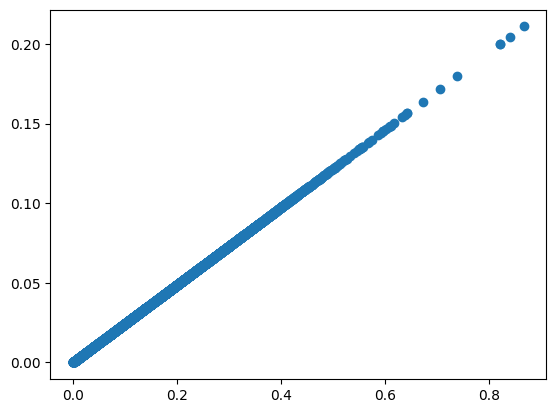

In [332]:
model='Debenedetti2022Light_XCiT-S12'
plt.scatter(unfilteredmodelscores[model]['feature dist'], unfilteredmodelscores[model]['input dist'])

In [61]:
torch.tensor(k)

tensor([2, 7, 7,  ..., 4, 0, 6])

In [72]:
# model='Ding2020MMA'
# w21cache=W21cache1[model]
# outpath=fget_out_path(model, extra=False)
# logits = torch.load(outpath, map_location=torch.device('cpu'))
# top2 = torch.topk(logits, 2)[1]
# t1 = top2[:,0]
# f1 = logits[torch.arange(len(logits)), t1]
# dmin = torch.ones_like(t1)*torch.inf
# for j in tqdm(range(10)):
#     t2 =torch.tensor([j]*len(t1))
#     f2 = logits[torch.arange(len(logits)), t2]
#     k = torch.tensor([get_k(i,j) for (i,j) in list(zip(t1,t2))])
#     f1f2 = torch.where(k==-1, torch.inf, f1-f2)
#     dist = torch.abs(f1f2)/w21cache[k]
#     dmin = torch.where(dist<dmin, dist, dmin)

In [71]:
dmin

tensor([0.0127, 0.0556, 0.1717,  ..., 0.1260, 0.2770, 0.0824],
       dtype=torch.float64)

In [65]:
extra=False
dataset='cifar10'
normthreat='Linf'
for model in models:
#     outpath=fget_out_path(model, extra=False, dataset=dataset, normthreat=normthreat)
#     outadvpath = fget_out_path(model, adv=True, extra=extra, dataset=dataset, normthreat=normthreat)
#     out = torch.load(outpath, map_location=torch.device('cpu'))
#     out_adv = torch.load(outadvpath, map_location=torch.device('cpu'))
#     #
#     featpath=get_feat_path(model, extra=extra, dataset=dataset, normthreat=normthreat)
#     featadvpath = get_feat_path(model, adv=True, extra=extra, dataset=dataset, normthreat=normthreat)
#     feat = torch.load(featpath, map_location=torch.device('cpu'))
#     feat_adv = torch.load(featadvpath, map_location=torch.device('cpu'))
#     unfilteredmodelscores[model]['feature dist']
#     unfilteredmodelscores[model]['input dist']
#     indexes=[]
#     cor=scipy.stats.pearsonr(unfilteredmodelscores[model]['feature dist'],
#                               unfilteredmodelscores[model]['input dist'])[0]
#     r = unfilteredmodelscores[model]['output dist']/unfilteredmodelscores[model]['feature dist']
#     _, r = lq2(r)
#     plt.hist(r)
#     plt.title(model)
#     plx(unfilteredmodelscores[model]['input dist'], unfilteredmodelscores[model]['feature dist'])
#     plt.show()
#     plt.close()
#     print(kdlcors[model]['feature dist'], kdlcors[model]['output dist'], model)
    print(f"{cor:.2f}", model)

0.82 Ding2020MMA
0.82 Debenedetti2022Light_XCiT-S12
0.82 Xu2023Exploring_WRN-28-10
0.82 Debenedetti2022Light_XCiT-M12
0.82 mart_loss_r18_ckpt
0.82 madry_loss_r18_ckpt
0.82 Sehwag2021Proxy_R18
0.82 Pang2022Robustness_WRN28_10
0.82 Hendrycks2019Using
0.82 trades_loss_r18_ckpt
0.82 clp_loss_r18_ckpt
0.82 Engstrom2019Robustness
0.82 alp_loss_r18_ckpt
0.82 Addepalli2022Efficient_RN18
0.82 Cui2023Decoupled_WRN-28-10
0.82 Rebuffi2021Fixing_28_10_cutmix_ddpm
0.82 Zhang2019Theoretically
0.82 Wang2023Better_WRN-28-10
0.82 Addepalli2021Towards_RN18


In [24]:
# model='Addepalli2021Towards_RN18'
# outpath=fget_out_path(model)
# out = torch.load(outpath, map_location=torch.device('cpu'))
# z = get_outdist(model, out)
# y = unfilteredmodelscores[model]['input dist']

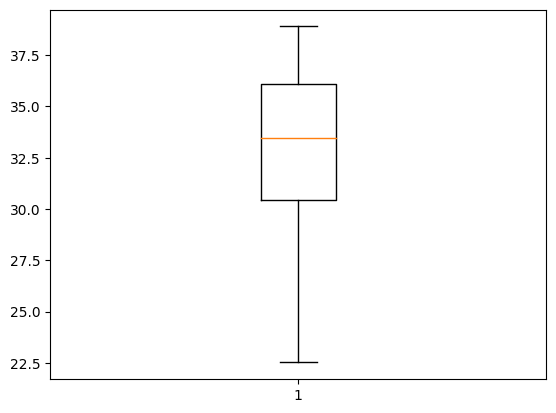

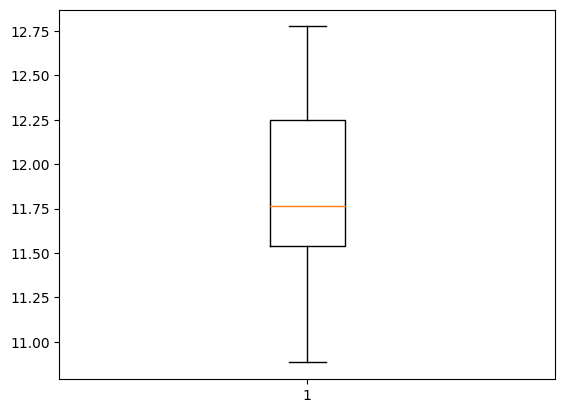

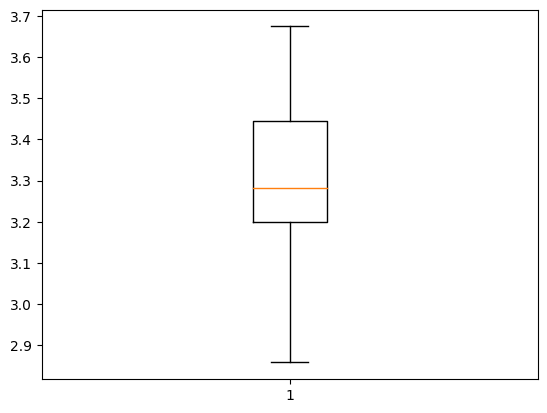

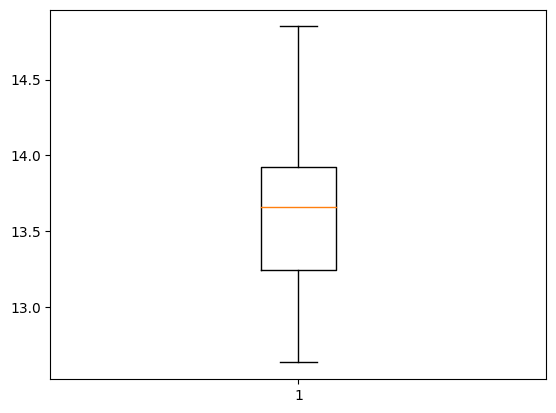

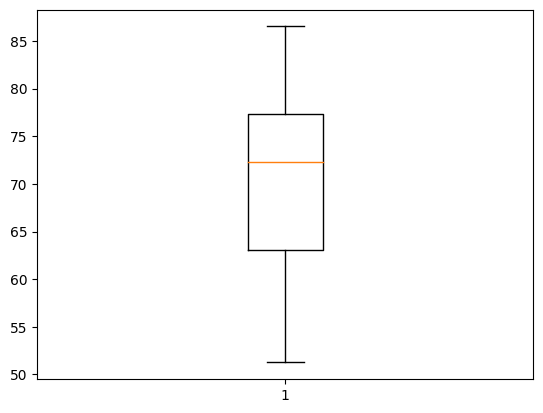

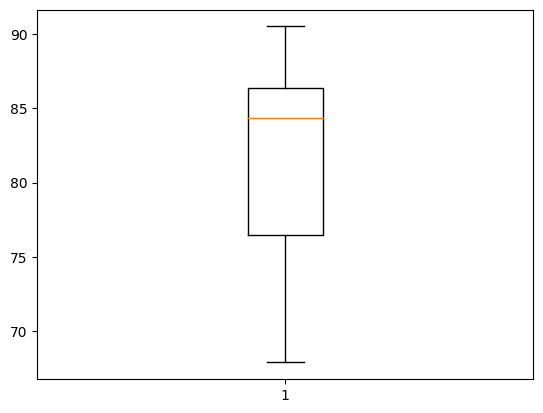

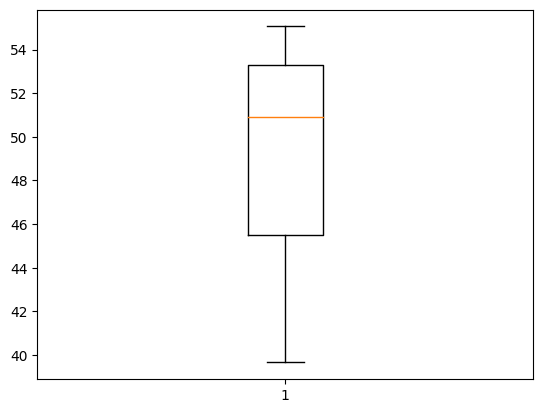

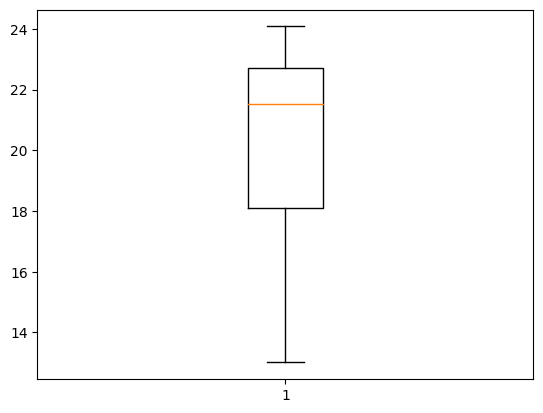

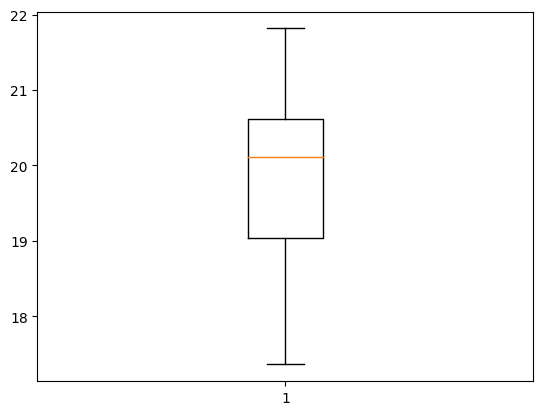

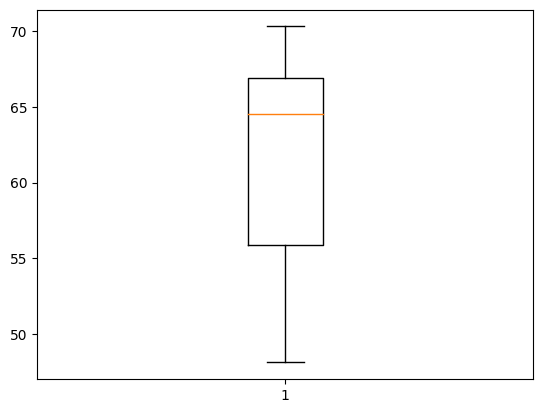

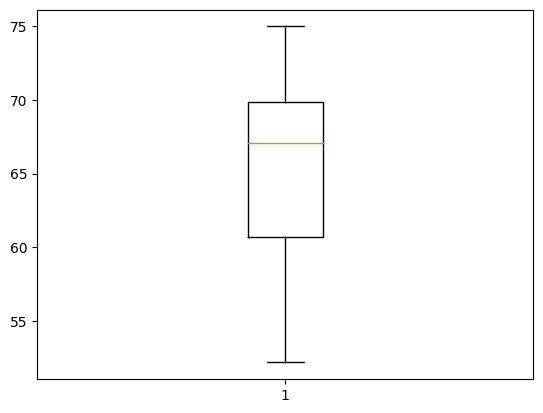

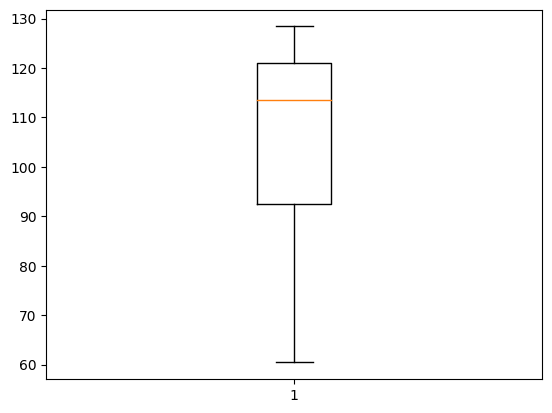

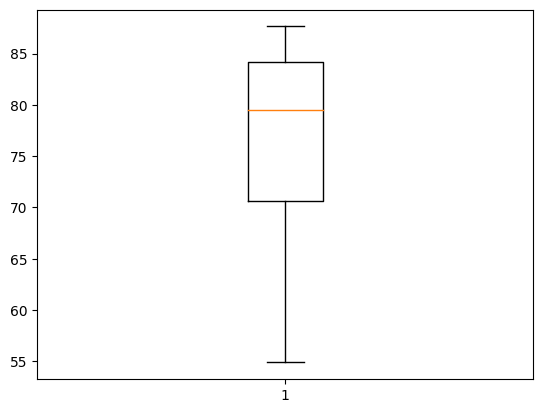

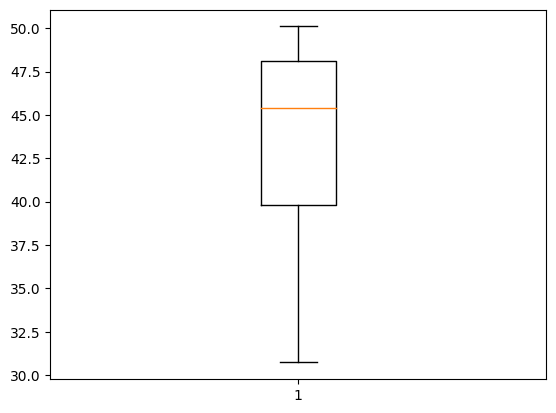

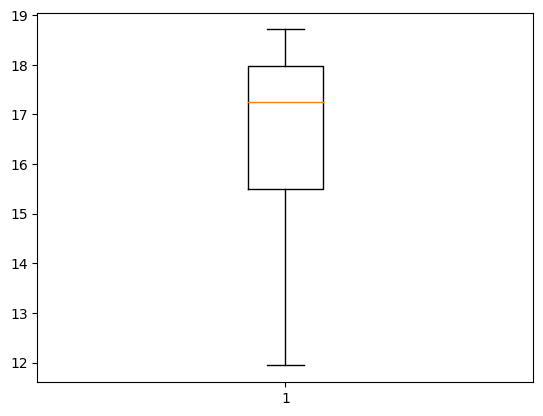

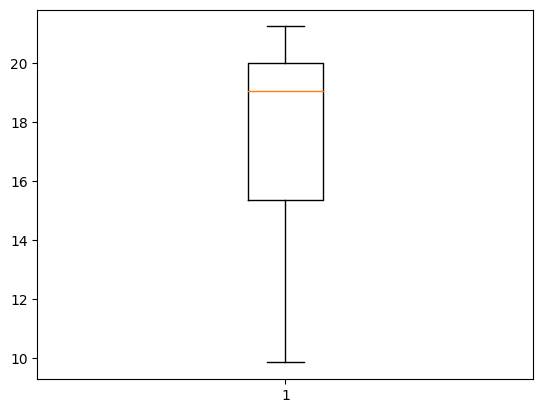

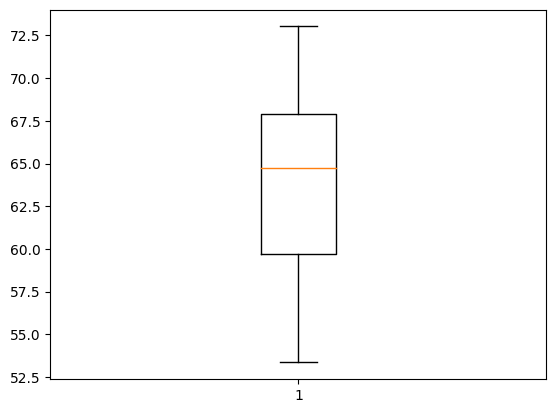

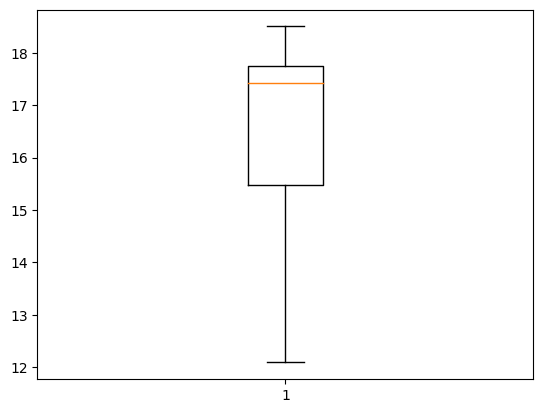

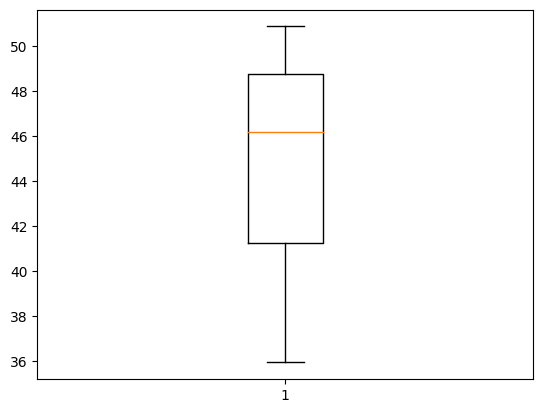

In [416]:
# plt.figure(figsize=(10, 4))
# for model in models:
# # plt.boxplot([W21cache1[model] for model in models], showfliers=False)
#     plt.boxplot(W21cache1[model], showfliers=False)
#     plt.show()
#     plt.close()

In [ ]:
model='Addepalli2021Towards_RN18'
outpath=fget_out_path(model)
out = torch.load(outpath, map_location=torch.device('cpu'))
W = get_fc_head_weight(model)

In [25]:
model='Addepalli2021Towards_RN18'
outpath=fget_out_path(model)
out = torch.load(outpath, map_location=torch.device('cpu'))
W = get_fc_head_weight(model)
# top2 = torch.topk(out, 2)[1]
# t1, t2 = top2[:,0], top2[:, 1]
sx = out.sort(dim=1, descending=True)
t = sx.indices
# out = sx.values
t1 = t[:,0]
t2 = t[:,1]
N=10
for k, i in enumerate(t1):
    if k>=N:
        break
    assert t1[k]==i
    margins = torch.zeros(10)
    logitmargins = torch.zeros(10)
    for j in range(10):
        assert out[k, i]>=out[k, j]
        w21star = torch.linalg.norm((W[i]-W[j]).detach(), ord=1)
        margins[j]=torch.abs(out[k, i]-out[k, j])/w21star if w21star!=0 else torch.inf
        logitmargins[j]=out[k, i]-out[k, j]
    assert margins[i]==torch.inf
    _, idxs = margins.sort(descending=False)
    logitmargin_k = out[k, t1[k]] - out[k, t2[k]]
    logitmargin_imin = out[k, t1[k]] - out[k, idxs[0]]
    
    margin_k = margins[t2[k]]
    margin_imin = margins[idxs[0]]
    print([margins[e] for e in range(10) if e!=i])
#     print(logitmargin_k, logitmargin_imin, i, t2[k], idxs[0])
#     print(margin_k, margin_imin)
#     assert logitmargin_k == logitmargin_imin
    print()
    print()
# f1 = out[torch.arange(len(out)), t1]
# f2 = out[torch.arange(len(out)), t2]
# dist = (f1-f2)/w21star
# scipy.stats.kendalltau(dist, y)

[tensor(0.0390), tensor(0.0525), tensor(0.0349), tensor(0.0332), tensor(0.0105), tensor(0.0291), tensor(0.0525), tensor(0.0481), tensor(0.0708)]


[tensor(0.0609), tensor(0.0839), tensor(0.1820), tensor(0.1606), tensor(0.1842), tensor(0.1598), tensor(0.2003), tensor(0.1748), tensor(0.0521)]


[tensor(0.0340), tensor(0.0378), tensor(0.1042), tensor(0.1245), tensor(0.0989), tensor(0.1247), tensor(0.1392), tensor(0.0969), tensor(0.0329)]


[tensor(0.1190), tensor(0.0463), tensor(0.1153), tensor(0.1179), tensor(0.1566), tensor(0.1559), tensor(0.1436), tensor(0.0503), tensor(0.1141)]


[tensor(0.1005), tensor(0.1050), tensor(0.0303), tensor(0.0292), tensor(0.0161), tensor(0.0420), tensor(0.0691), tensor(0.0943), tensor(0.1115)]


[tensor(0.0670), tensor(0.0838), tensor(0.0216), tensor(0.0371), tensor(0.0154), tensor(0.0360), tensor(0.0525), tensor(0.0871), tensor(0.0760)]


[tensor(0.0937), tensor(0.0830), tensor(0.0352), tensor(0.1176), tensor(0.0185), tensor(0.0921), tensor(0.1041), tenso

In [150]:
# model='Addepalli2021Towards_RN18'
W21cache1 = dict()
W21cache2 = dict()
# fig, ax = plt.subplots(nrows=2, ncols=2)
for model in models:
    W = get_fc_head_weight(model)
    W21stars1=dict()
    W21stars2=dict()
    for i, j in list(combinations(np.arange(10),2)):
        w21star1 = torch.linalg.vector_norm((W[i]-W[j]).detach(), ord=1)
        w21star2 = torch.linalg.vector_norm((W[i]-W[j]).detach(), ord=2)
        W21stars1[(i,j)] = w21star1
        W21stars2[(i,j)] = w21star2
    y = np.array([float(e) for e in list(W21stars1.values())])
    W21cache1[model]=y
    y = np.array([float(e) for e in list(W21stars2.values())])
    W21cache2[model]=y

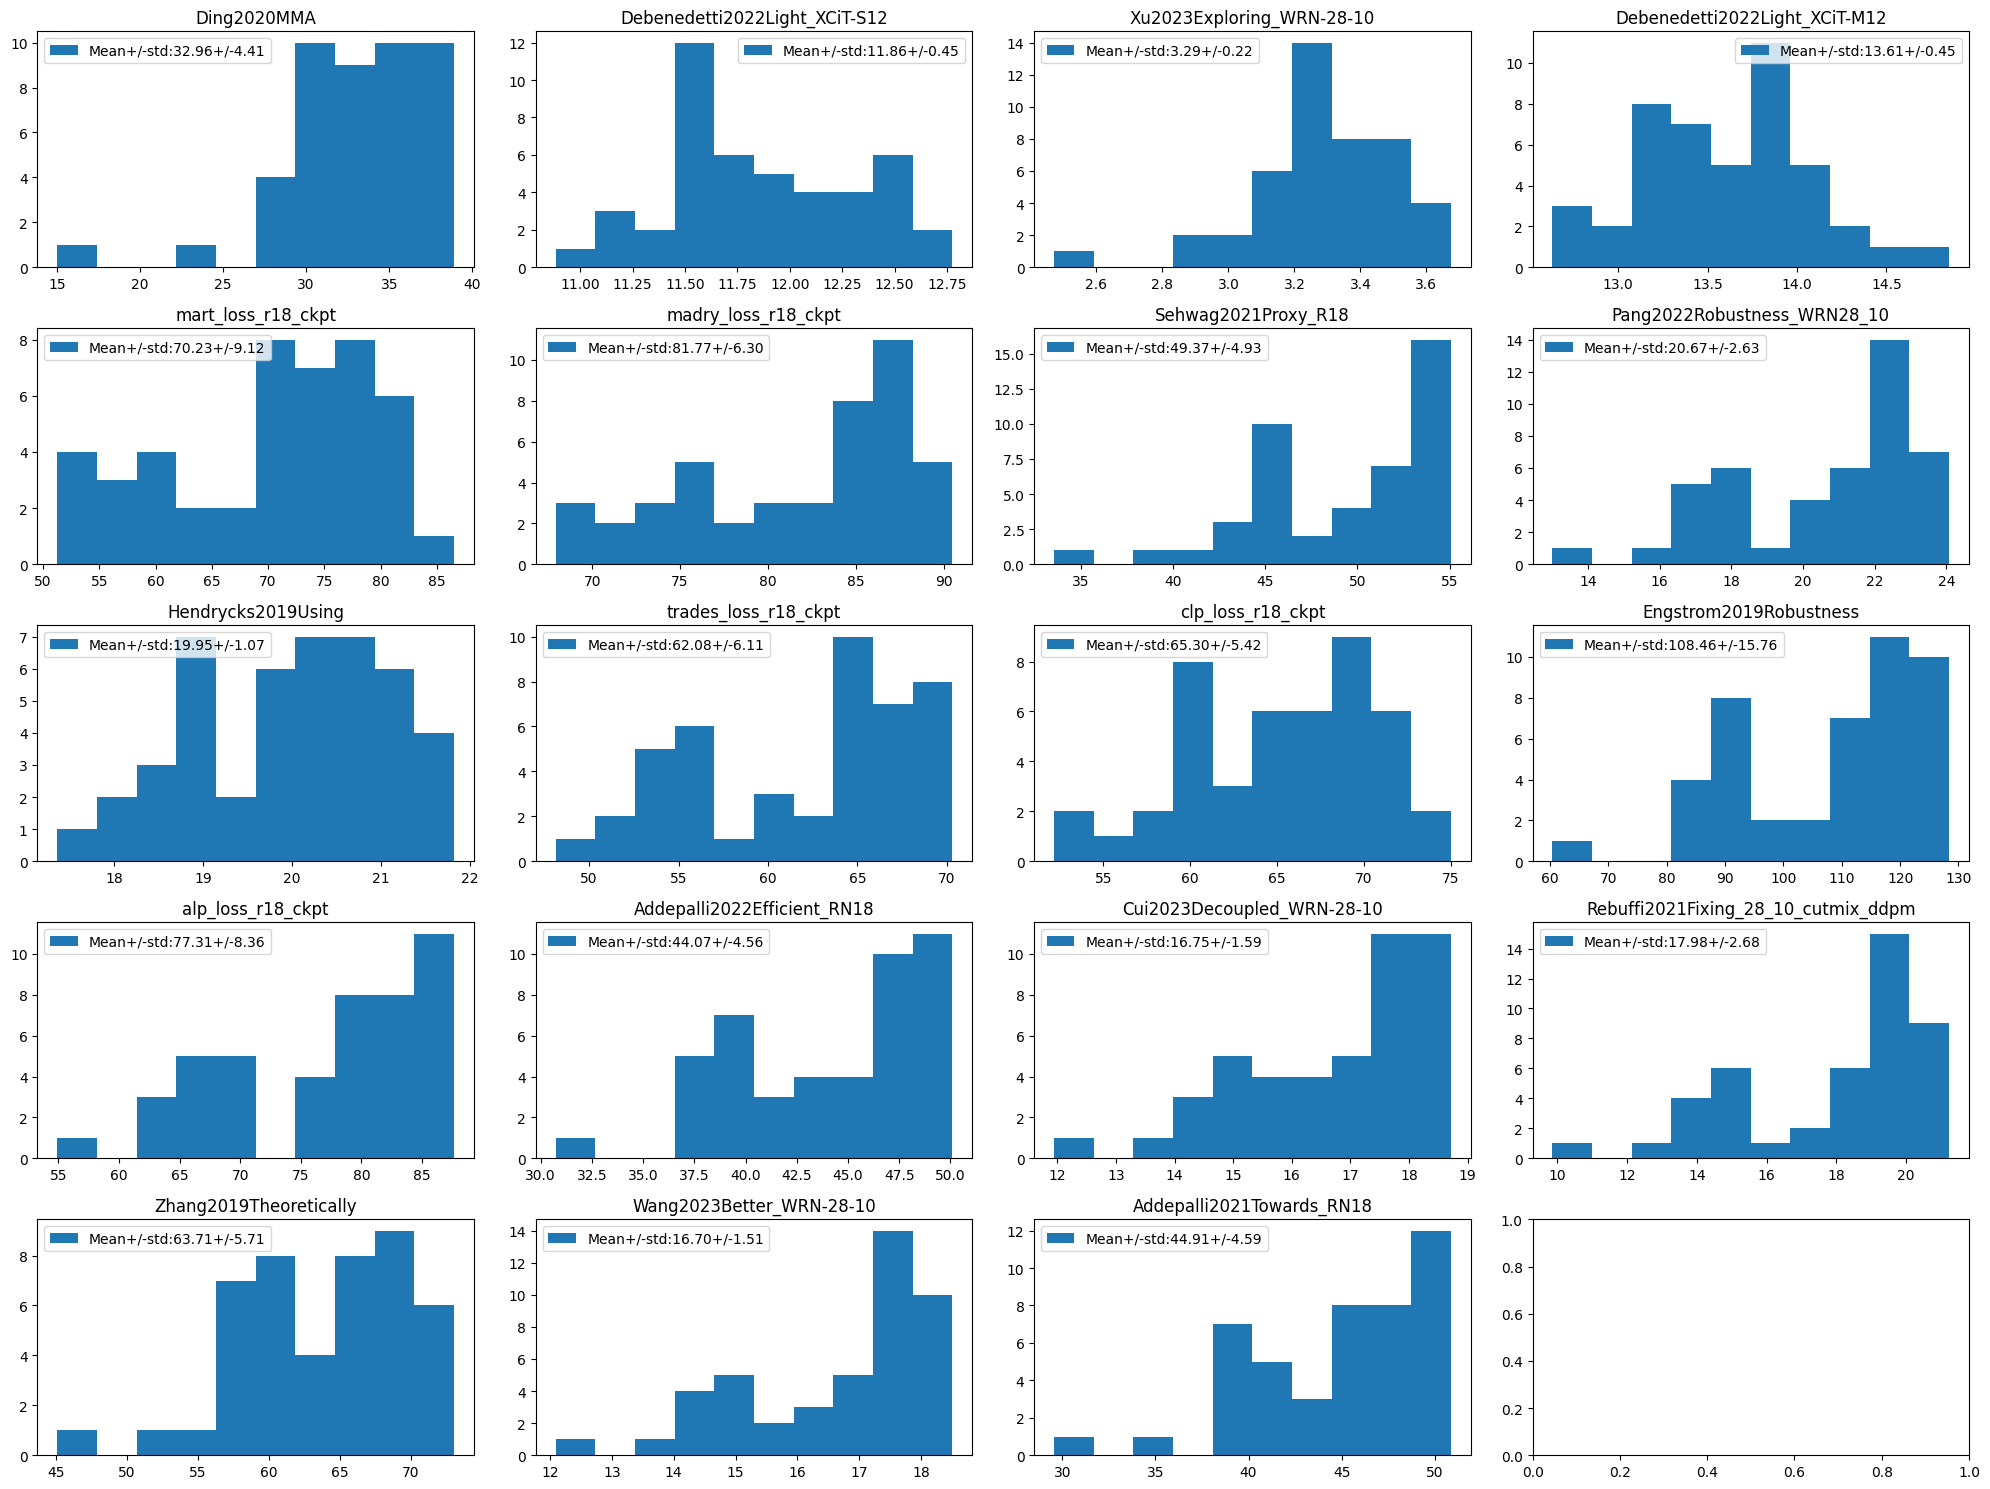

In [166]:
# Assuming 'models' is a list containing the model names
num_rows, num_cols = 5, 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15))

for i, model in enumerate(models):
    row, col = divmod(i, num_cols)
    y = W21cache1[model]
    axs[row, col].hist(y, label=f"Mean+/-std:{y.mean():.2f}+/-{y.std():.2f}")
    axs[row, col].set_title(model)
    axs[row, col].legend()
plt.tight_layout()
plt.savefig('w21stars.png')
plt.show()


### for model in models:
    plt.hist(W21stars[model].values())
    plt.title(model)
    plt.show

max-min 	 mean 		 std


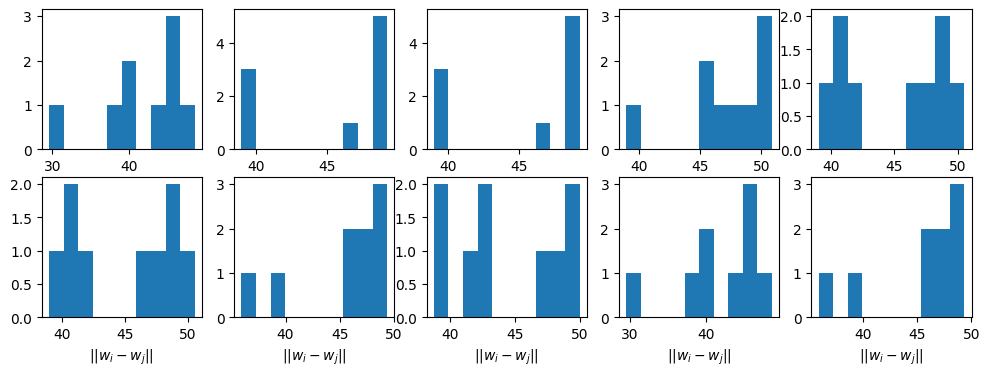

In [484]:
model='Addepalli2021Towards_RN18'
outpath=fget_out_path(model)
out = torch.load(outpath, map_location=torch.device('cpu'))
top2 = torch.topk(out, 2)[1]
t1, t2 = top2[:,0], top2[:, 1]
# for k in range(len(t1)):
W21 = []
for j in range(10):
    t = torch.tensor([j]*len(t1))
    w21star = torch.linalg.norm((W[t1]-W[j]).detach(), ord=1, dim=1)
#     print(w21star.shape)
    W21.append(w21star)
W21 = torch.stack(W21) 
print("max-min \t mean \t\t std")
c=0
plt.figure(figsize=(12, 4))
for j in range(len(t1)//1000):
    idx=[k for k in range(10) if k!=t1[j]]
    w21values = W21[idx, j]
    assert len(w21values) == 9
#     print(w21values.max()-w21values.min(), w21values.mean(), w21values.std())
    c=c+1
    plt.subplot(2,5, c)
    plt.hist(w21values)
    plt.xlabel('$||w_i-w_j||$')
#     plt.show()
#     plt.close()
plt.savefig('w21values.png')
# W = get_fc_head_weight(model)
# w21star = torch.linalg.norm((W[t1]-W[t2]).detach(), ord=1, dim=1)
# print(W.shape)

In [460]:
t1[0]

tensor(3)

In [462]:
idx=[k for k in range(10) if k!=t1[0]]
W21[idx, 0], idx

(tensor([48.6547, 46.0158, 39.3055, 39.7533, 29.5529, 39.0029, 43.5690, 46.3279,
         45.0722]),
 [0, 1, 2, 4, 5, 6, 7, 8, 9])

In [442]:
for model in models:
    outpath=fget_out_path(model)
    out = torch.load(outpath, map_location=torch.device('cpu'))
    top2 = torch.topk(out, 2)[1]
    t1, t2 = top2[:,0], top2[:, 1]
    w21star = torch.linalg.norm((W[t1]-W[t2]).detach(), ord=1, dim=1)
    f1 = out[torch.arange(len(out)), t1]
    f2 = out[torch.arange(len(out)), t2]
#     print((f1-f2>0).float().mean())
    W = get_fc_head_weight(model)
    w21star = torch.linalg.norm((W[t1]-W[t2]).detach(), ord=1, dim=1)
    print(W.shape)
#     print(len(w21star.unique))

torch.Size([10, 256])
torch.Size([10, 384])
torch.Size([10, 640])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 640])
torch.Size([10, 640])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 2048])
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 640])
torch.Size([10, 640])
torch.Size([10, 640])
torch.Size([10, 640])
torch.Size([10, 512])


In [20]:
# rbaccs = [robust_accuracies[model] for model in extradfs.keys()]
# kors = [kdlcors[model]['logit margin'] for model in extradfs.keys()]
# plt.scatter(rbaccs, kors)

In [21]:
# # print(model)
# scores = unfilteredmodelscores[model]['max prob.']
# xscores = unfilteredmodelscores[model]['prob. margin']
# cor = scipy.stats.kendalltau(scores,xscores)[0]
# print(cor)
# plt.scatter(scores, xscores, s=5);

In [22]:
# for model in xmodels:
def xfillaucscores(model,
                  aurocmodels, auprmodels,
                  ratiomodels, fpr95models, epsilons=None):
    # model = 'ce_loss_r18_ckpt'
#     regr = classifiers[model]
    aurocmodels[model] = []
    auprmodels[model] = []
#     ratiomodels[model] = []
    fpr95models[model] = []
    xepsilons = []
    for epsilon in tqdm(epsilons):
    #     print(epsilon)
        xnonrobust_flags = bin_separate(dfs, epsilon)
        binvalues  = xnonrobust_flags[model]
        r = get_ratio(binvalues)
        if r<0.001 or r>0.999:
            continue
        xepsilons.append(epsilon)
#         out = torch.load(get_out_path(model), map_location=torch.device('cpu'))
#         scores=regr.predict(out)
        scores = unfilteredmodelscores[model]['logit margin']
        xres = xget_AUCs(binvalues, -scores)
        aurocmodels[model].append(xres['auroc'])
        auprmodels[model].append(xres['aupr'])
#         ratiomodels[model].append(xres['ratio'])
        fpr95models[model].append(xres['fprattpr'])
    return xepsilons

In [662]:
xaurocmodels=dict()
xauprmodels=dict()
xratiomodels=dict()
xfpr95models=dict()
for model in models:
    xfillaucscores(model,
                      xaurocmodels, xauprmodels,
                      xratiomodels, xfpr95models,  epsilons=[8/255])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [663]:
fpr95models.keys()

dict_keys(['Addepalli2021Towards_RN18'])

In [664]:
# yy=[xfpr95models[m][0][0] for m in models]
# zz=[fpr95models[m][0][0] for m in models]
# plt.scatter(yy, zz);
# yy=[xaurocmodels[m] for m in models]
# zz=[aurocmodels[m] for m in models]
# plt.scatter(yy, zz);
yy=[X[m][0] for m in models if X[m][0]>0.85]
zz=[auprmodels[m][0] for m in models if auprmodels[m][0]>0.85]
plt.scatter(yy, zz);

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

[]

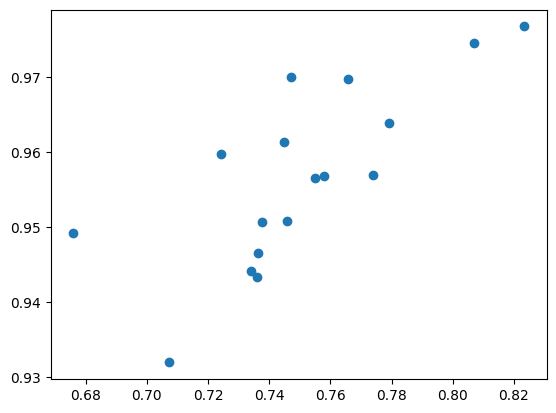

In [665]:
xmodels = [m for m in models if robust_accuracies[m]>1 and kdlcors[m]['logit margin']>0.5]
rbaccs=[robust_accuracies[model] for model in xmodels]
idxs = np.argsort(rbaccs)
yy=[unfilteredmodelscores[model]['input dist'] for model in xmodels]
# plt.boxplot(yy, showfliers=False, showmeans=True);
md = [np.mean(a) for a in yy]
z=[xauprmodels[m][0] for m in xmodels]
# xx=[robust_accuracies[m] for m in xmodels]
xx =[kdlcors[m]['logit margin'] for m in xmodels]
md = np.array(md)
z = np.array(z)
# plt.scatter(xx, md/md.max())
plt.scatter(xx, z)
plt.show()

In [658]:
get_out_path('Cui2023Decoupled_WRN-28-10')

'../xps/cifar10/Cui2023Decoupled_WRN-28-10_Linf_New/out.pt'

In [680]:
avgrob = torch.load('../xps/cifar10/Cui2023Decoupled_WRN-28-10_Linf_New/avgrob_evm512.pt')

In [681]:
(avgrob<1e-6).sum()

tensor(10000)

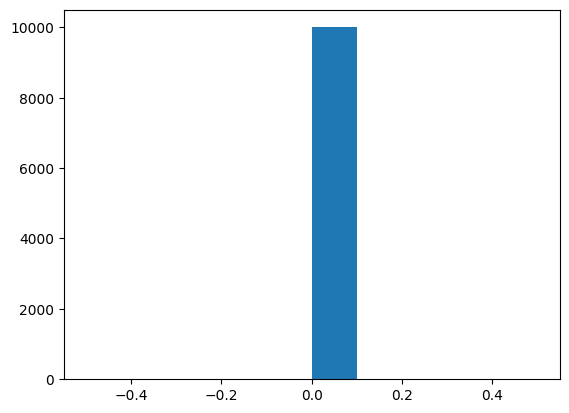

In [683]:
plt.hist(avgrob);

In [569]:
tensor, exclude_idx(tensor, target) - tensor.gather(1, target.view(-1,1))

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]),
 tensor([[-1,  1,  2,  3,  4,  5,  6,  7,  8],
         [-2, -1,  1,  2,  3,  4,  5,  6,  7],
         [-3, -2, -1,  1,  2,  3,  4,  5,  6]]))

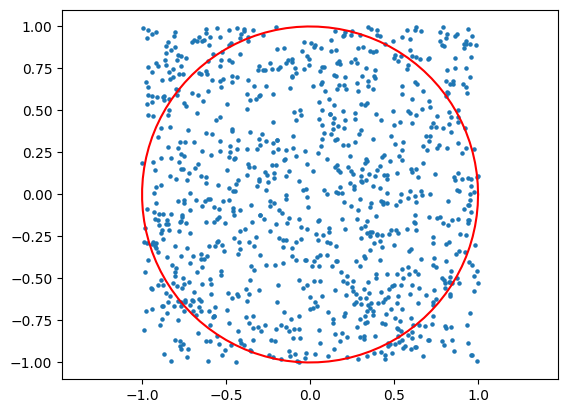

In [516]:
radius = 1
theta = np.linspace(0, 2*np.pi, 100)
x = radius * np.cos(theta)
y = radius * np.sin(theta)
N=100
# z=np.random.normal(loc=0, scale=1/np.sqrt(2), size=(num_points,2))
# Normal distribution with mean=radius
z=np.random.uniform(-1, 1, size=(num_points,2))
plt.scatter(z[:,0], z[:,1], s=5)
plt.axis('equal')
plt.plot(x,y, 'r-');

In [1129]:
# T = optimize_temperature_logits(logits, labels)

In [1130]:
# logits, labels = get_a_score(model)
# get_metrics(logits/T, labels, from_logits=True)
# if len(labels_oneh.shape)<2:
#     labels = torch.nn.functional.one_hot(labels, num_classes=10)
# if from_logits:
#     preds = torch.nn.functional.softmax(logits)
# return calibration_error(np.array(labels).reshape(-1,10), np.array(preds).reshape(-1,10))

In [238]:
kdlcors[mof]

{'Ding2020MMA': 41.44,
 'Debenedetti2022Light_XCiT-S12': 56.14,
 'Xu2023Exploring_WRN-28-10': 63.89,
 'Debenedetti2022Light_XCiT-M12': 57.27,
 'mart_loss_r18_ckpt': 39.12,
 'cifar10_resnet44': 0,
 'madry_loss_r18_ckpt': 36.91,
 'cifar10_resnet32': 0,
 'Sehwag2021Proxy_R18': 55.54,
 'Pang2022Robustness_WRN28_10': 61.04,
 'Hendrycks2019Using': 54.92,
 'trades_loss_r18_ckpt': 42.23,
 'clp_loss_r18_ckpt': 40.08,
 'Standard': 0.0,
 'Engstrom2019Robustness': 49.25,
 'alp_loss_r18_ckpt': 40.21,
 'Addepalli2022Efficient_RN18': 52.48,
 'Cui2023Decoupled_WRN-28-10': 67.73,
 'Rebuffi2021Fixing_28_10_cutmix_ddpm': 60.73,
 'cifar10_resnet56': 0,
 'cifar10_resnet20': 0,
 'Zhang2019Theoretically': 53.08,
 'Wang2023Better_WRN-28-10': 67.31,
 'ResNet18': 0,
 'ResNet50': 0,
 'Addepalli2021Towards_RN18': 51.06,
 'ce_loss_r18_ckpt': 0.0}

<a id='errorbar'></a>  [top](#top1)

In [26]:
plot_markers = [
    ".",  # Point
    ",",  # Pixel
    "o",  # Circle
    "v",  # Downward-pointing triangle
    "^",  # Upward-pointing triangle
    "<",  # Left-pointing triangle
    ">",  # Right-pointing triangle
    "1",  # Filled downward-pointing triangle
    "2",  # Filled upward-pointing triangle
    "3",  # Filled left-pointing triangle
    "4",  # Filled right-pointing triangle
    "8",  # Octagon
    "s",  # Square
    "p",  # Pentagon
    "P",  # Filled pentagon
    "*",  # Star
    "h",  # Hexagon (variant 1)
    "H",  # Hexagon (variant 2)
    "+",  # Plus sign
    "x",  # Cross (variant 1)
    "X",  # Cross (variant 2)
    "D",  # Filled diamond
    "d",  # Diamond (thin outline)
    "|",  # Vertical line
    "_",  # Horizontal line
]
print(plot_markers)
# plot_markers = ['o', 's', 'D', '^', 'v', '+', 'x', 'H', '*', 'p', '8', 'P', 'h', '<', 'X', '#', 'y', '|', '1', 'd']
# plot_markers.remove('#')

['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_']


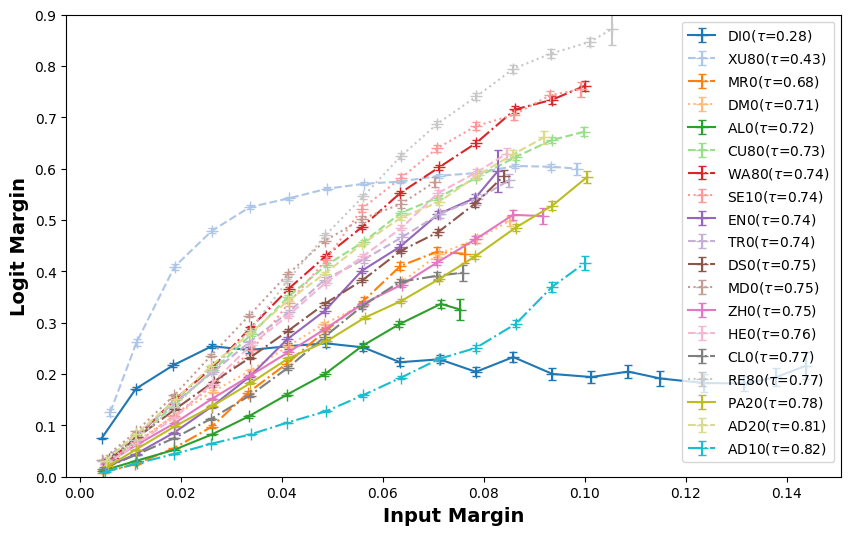

In [27]:
N = 20
N2=10
bin_edges = np.linspace(0, 0.15, N+1)
score='logit margin'

number_of_colors = 20
cmap = plt.get_cmap("tab20")
c = [cmap(i) for i in np.linspace(0, 1, number_of_colors)]
xmodels=[m for m in models if robust_accuracies[m]>1]
sortscore = [kdlcors[xmodels[i]][score] for i in range(len(xmodels))]
sortedargs =np.argsort(sortscore)
xmodels = [xmodels[i] for i in sortedargs]
colors = dict()
linestyles =dict()
markers = dict()
ls = ['-', '--', '-.', ':']
# ls = random.choice(['-', '--', '-.', ':'])
# mrk=plot_markers[j]
for i, m in enumerate(xmodels):
    colors[m] = c[i]
    linestyles[m] = ls[i%len(ls)]
    markers[m] = plot_markers[i]
# xmodels=['madry_loss_r18_ckpt']
plt.figure(figsize=(10, 6))
for j, model in enumerate(xmodels[:]):
#     if model not in rbenchmodels:
#     if robust_accuracies[model]<1:
#         continue
#     if 'Ding' in model:
#         continue
    X= unfilteredmodelscores[model]['input dist']
    Y = unfilteredmodelscores[model][score]
    idxs, X =lq2(X)
    Y = Y[idxs]
    Y = (Y-Y.min())/(Y.max()-Y.min())
#     Y = Y/Y.max()
#     print(scipy.stats.kendalltau(X, Y)[0], model)
#     plt.subplot(2,1,1)
    mrk=plot_markers[j]
    plx(X, Y, M=N, label=getps(model, code=True).upper()+f"($\\tau$={kdlcors[model][score]:.2f})",
       shownumbers=False, color=colors[model], bin_edges=bin_edges, fmt=markers[m], ls=linestyles[model])
    # Set the x-axis labels to the bin ranges
#     bin_labels = [f"{bin_edges[i]:.2g} - {bin_edges[i+1]:.2g}" for i in range(N)]
#     plt.xticks(xmeans, bin_labels, rotation=45)
    # Set title and labels for the plot
#     print(f"cor:{cor:.2f} {model}")
#     sizes = [len(data) for data in data_to_plot]
#     for i in range(len(means)):
#         plt.annotate(f"{sizes[i]}", (xmeans[i], means[i]))
# plt.title()
plt.xlabel('Input Margin', fontsize=14, weight='bold')
plt.ylabel('Logit Margin', fontsize=14, weight='bold')
plt.ylim(0,0.9)
# plt.axvline(8/255, linestyle='--')
# Display the plot
plt.legend(loc='upper right', prop={"size": 10})
# plt.axis('equal')
# plt.xlim(0, 0.1)
# x = [i/255 for i in range(1, 40, 4)]
# xticks = [f"{i/255:.2f}" for i in range(1, 40, 4)]
# extraticks=[plt.Text(8/255, 0, "8/255")]
# plt.xticks(list(plt.xticks()[0]) + [8/255], list(plt.xticks()[1])+extraticks, rotation=75 )
# plt.xticks(x, xticks,rotation=75)
plt.savefig('figures/errorbar.pdf', bbox_inches='tight')
if False:
    ax= plt.gca()

    # Create a separate figure for the legend
    legend_fig = plt.figure()
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.legend(*ax.get_legend_handles_labels(), loc='center', ncol=2)
    plt.xticks([])
    plt.yticks([])
    # plt.subplot(2,1,2)
    # legend_fig.show()
    legend_fig.savefig('legend_errorbar.pdf')
plt.show()
plt.close()

In [28]:
# np.random.shuffle(plot_markers)
plot_markers

['.',
 ',',
 'o',
 'v',
 '^',
 '<',
 '>',
 '1',
 '2',
 '3',
 '4',
 '8',
 's',
 'p',
 'P',
 '*',
 'h',
 'H',
 '+',
 'x',
 'X',
 'D',
 'd',
 '|',
 '_']

In [52]:
# model='Ding2020MMA'
# Y= unfilteredmodelscores[model]['input dist']
# idxs, Y2 =lq2(Y,0.5, 99.5)
# plt.hist(Y);
# plt.hist(Y2, alpha=0.5);

In [323]:
# ##PER CLASS
# # y_score = get_a_score(model, calc_lmarginadv)
# # y_score
# nonrobust_flags = bin_separate(dfs, eps)
# def get_auc(c, model, xscores, idxs=None):
#     binvalues  = nonrobust_flags[model]
#     xres = xget_AUCs(binvalues, -xscores, idxs=idxs)
#     return xres
# yy=[]
# z=[]
# for model in models:
#     scores = unfilteredmodelscores[model]['input dist']
#     xscores = unfilteredmodelscores[model]['logit margin']
#     ytrue = ytargets[model]
# #     getcor = lambda c: scipy.stats.kendalltau(scores[ytrue==c],
# #                                 xscores[ytrue==c])[0]
# #     y = [getcor(c) for c in range(10)]
# #     z.append(kdlcors[model]['logit margin'])
#     plt.boxplot([scores[ytrue==c] for c in range(10)], showfliers=False);
# #     plt.boxplot([xscores[ytrue==c] for c in range(10)], showfliers=False);
# #     z.append(get_auc(c, model, xscores)['fprattpr'][0])
# #     y = [get_auc(c, model, xscores, ytrue==c)['fprattpr'][0] for c in range(10)]
# #     plt.scatter(np.arange(10), y)
# #     plt.boxplot(y)
# #     yy.append(y)
#     plt.axhline(8/255, linestyle='--')
#     plt.title(model)
#     plt.show()
#     plt.close()
# # plt.boxplot(yy, showfliers=False);
# # plt.scatter(np.arange(1,len(models)+1), z)
# # plt.show()
# # plt.close()

In [223]:
def getstats(scores):
    mean = scores.mean()
    medn = np.median(scores)
    std = scores.std()
    iqr = scipy.stats.iqr(scores)
    skw = scipy.stats.skew(scores, bias=True)
    kurt = scipy.stats.kurtosis(scores, fisher=True, bias=True)
    return iqr, kurt
j = 'logit margin'
fj='feature dist'
def stats(xmodels):
    print(f"cor/fcor  cfl  lip1  lip2  model")
    x,y = [],[]
    for model in xmodels:
        scores = unfilteredmodelscores[model]['input dist']
        y_score = unfilteredmodelscoresAdv[model][j]
        fy_score = unfilteredmodelscoresAdv[model][fj]
        cfl = scipy.stats.kendalltau(y_score, fy_score)[0]
#         scores = extraunfilteredscores[model][-1]
#         y_score = extraunfilteredscoresAdv[model][scnames.index('kl div')]
#         y_score = get_a_score(model, calc_lmarginadv, extra=True)        
        idxs, scores = lq2(scores, 5, 95)
#         idxs, fy_score = lq2(fy_score)
#         scores = scores[idxs]
        y_score = y_score[idxs]
        fy_score = fy_score[idxs]
    #     cor = scipy.stats.kendalltau(scores.ravel(), y_score.ravel().numpy())
        iqr, kurt = getstats(scores)
        iqr2, kurt2 = getstats(y_score)
        ratio=y_score/(scores+1e-12)
#         ratio=(scores+1e-12)/(y_score+1e-12)
        lip2 = np.percentile(ratio, 95)#ratio.max()
        lip1 = np.percentile(ratio, 5)#ratio.max()
#         print(f"{kdlcors[model][fj]:.3f} \t {kdlcors[model][j]:.3f} \t {kurt:.3f} \t {lip:.3g} \t {getps(model)}")
        print(f"{kdlcors[model][fj]:.2f}/{kdlcors[model][j]:.2f}  {cfl:.2f}  {lip1:.3g}  {lip2:.3g}  {getps(model)}")
#         print(f"{kdlcors[model][0]:.2f}\t{kurt2:.3f}\t{skw2:.2f}\t{lip:.3g}\t{getps(model)}")
        print()
#         plt.hist(scores)
#         plt.scatter(fy_score, y_score, s=5)
# ##        end = 5e-3 if lip>500 else scores.max()*0.75
# ##        t2=np.linspace(0, end)
# ##        t=np.linspace(0, scores.max())
# ##         plt.plot(t, (ratio).min()*t, 'r--')
# ##         plt.plot(t2, (ratio).max()*t2, 'r--')
# ##         means = np.zeros(10)
# ##         for c in range(10):
# ##             means[c] = scipy.stats.kendalltau(scores[targets==c], y_score[targets==c])[0]
# ##         plt.bar(np.arange(10), means)
#         plt.title(model)
# ##         plt.legend()
#         plt.show()
#         plt.close()
#         x.append(kurt)
        x.append(robust_accuracies[model])
        y.append(ratio.max())
    return x,y
# xmodels = ['cifar10_resnet32', 'Sehwag2021Proxy_R18', 'Ding2020MMA', 'Xu2023Exploring_WRN-28-10']
xmodels = [m for m in models if abs(kdlcors[m][j])<0.6]
x,y = stats(xmodels)
# plt.scatter(x, y)
print()
xmodels = [m for m in models if abs(kdlcors[m][j])>=0.6]
x,y = stats(xmodels)
# plt.scatter(x, y);
# plt.show()
# plt.close()

cor/fcor  cfl  lip1  lip2  model
0.57/0.44  0.67  32.7  452  Ding2020MMA

0.49/0.44  0.86  25.6  128  Xu2023Explori


cor/fcor  cfl  lip1  lip2  model
0.66/0.72  0.71  16.2  67.8  Sehwag2021Pro

0.66/0.76  0.72  15.9  50.1  Pang2022Robus

0.75/0.74  0.78  19.9  66  Hendrycks2019

0.75/0.74  0.83  28.9  121  Engstrom2019R

0.83/0.78  0.82  10.9  29  Addepalli2022

0.71/0.71  0.77  13.8  38.5  Cui2023Decoup

0.66/0.76  0.74  12.6  41.2  Rebuffi2021Fi

0.78/0.74  0.84  19.6  69.1  Zhang2019Theo

0.71/0.72  0.72  14.3  41.5  Wang2023Bette

0.77/0.82  0.81  11.5  39.3  Addepalli2021



In [224]:
def NCmetrics(model, extra=False):
    featpath=get_feat_path(model, extra=False)
    feat = torch.load(featpath, map_location=torch.device('cpu'))
    muG = feat.mean(0)
    muC = [feat[targets==c].mean(0) for c in range(10)]
    muC = torch.stack(muC, 0)
    SigmaW = torch.zeros(feat.shape[1], feat.shape[1])
    for c in range(10):
        a = feat[targets==c].unsqueeze(2)-muC[c].view(-1, 1)
        a = a@a.transpose(1,2)
        SigmaW +=a.sum(0)
    SigmaW=SigmaW/len(feat)
    u = torch.nn.functional.normalize(muC)
    NC2 = torch.inner(u, u)
    return SigmaW, NC2

In [225]:
# for model in models:
#     SigmaW, ipu = NCmetrics(model)
#     s = "{:.2f} {:.2f} \t {:.2f}".format(np.percentile(SigmaW, 5),\
#                                              np.percentile(SigmaW, 95),\
# #                                              np.percentile(ipu-etf, 5),\
#                                              np.percentile(ipu-etf, 95))
#     print(f"{kdlcors[model][fj]:.2f} {s} {model}")
# #     break

In [28]:
def ylin(x, a=0, b =1):
    alpha = (b-a)/(max(x)-min(x))
    beta = b - alpha*max(x)
    def apply(t):
        return alpha*t + beta
    return apply

def stats(xmodels):
    print(f"cor   kurtosis \t skew \t model")
    for model in xmodels:
        scores = extraunfilteredscores[model]['input dist']
        scores2 = unfilteredmodelscores[model]['input dist']
#         scores = ylin(scores)(scores)
        j='logit dist'
#         j=scnames.index('feature dist')
        y_score = unfilteredmodelscores[model][j]
    #     cor = scipy.stats.kendalltau(scores.ravel(), y_score.ravel().numpy())
        mean = scores.mean()
        medn = np.median(scores)
        std = scores.std()
        iqr = scipy.stats.iqr(scores)
        skw = scipy.stats.skew(scores, bias=True)
        kurt = scipy.stats.kurtosis(scores, fisher=True, bias=True)
#         kurt = scipy.stats.entropy(scores)
        print(f"{kdlcors[model][j]:.2f}\t{kurt:.3f}\t{skw:.2f}\t{model}")# , getps(model))
#         print(f"cor:{kdlcors[model][0]:.2f} mean:{mean:.3f} medn:{medn:.3f} | std:{std:.3f} IQR:{iqr:.3f} | skew:{skw:.2f}")# , getps(model))
#         plt.scatter(y_score, scores2)
#         plt.hist(scores, bins=20, label='5k')
#         plt.hist(score2, bins=20, alpha=0.5, label='10k')
#         plt.legend();
#         plt.title(model)
#         plt.show()
#         plt.close()
xmodels = [m for m in models if abs(kdlcors[m]['logit margin'])<0.55]
stats(xmodels)
print()
xmodels = [m for m in models if abs(kdlcors[m]['logit margin'])>0.55]
stats(xmodels)

cor   kurtosis 	 skew 	 model
0.44	52.474	6.09	Ding2020MMA
0.44	1.862	0.62	Xu2023Exploring_WRN-28-10

cor   kurtosis 	 skew 	 model
0.72	3.170	0.99	Sehwag2021Proxy_R18
0.76	0.993	0.44	Pang2022Robustness_WRN28_10
0.74	0.117	0.55	Hendrycks2019Using
0.74	0.738	0.64	Engstrom2019Robustness
0.78	1.172	0.80	Addepalli2022Efficient_RN18
0.71	3.632	0.81	Cui2023Decoupled_WRN-28-10
0.76	0.907	0.61	Rebuffi2021Fixing_28_10_cutmix_ddpm
0.74	0.592	0.65	Zhang2019Theoretically
0.72	2.488	0.72	Wang2023Better_WRN-28-10
0.82	0.250	0.62	Addepalli2021Towards_RN18


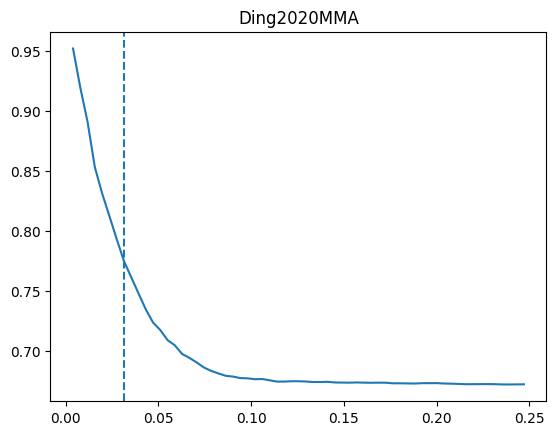

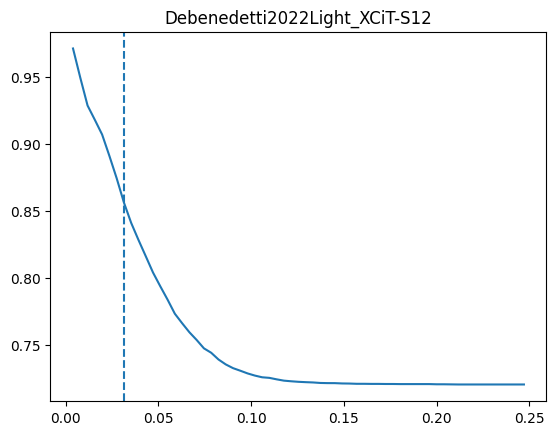

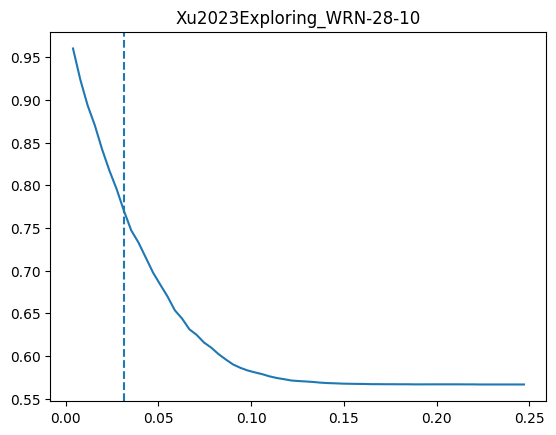

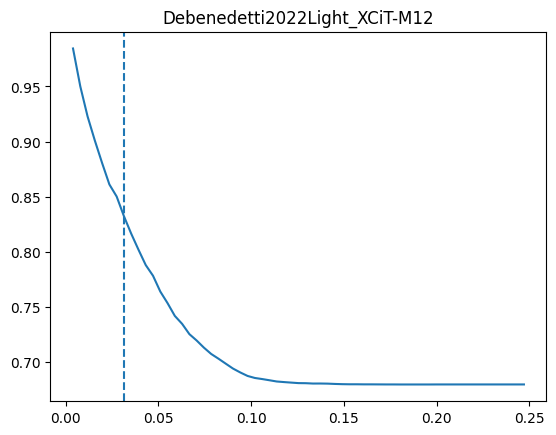

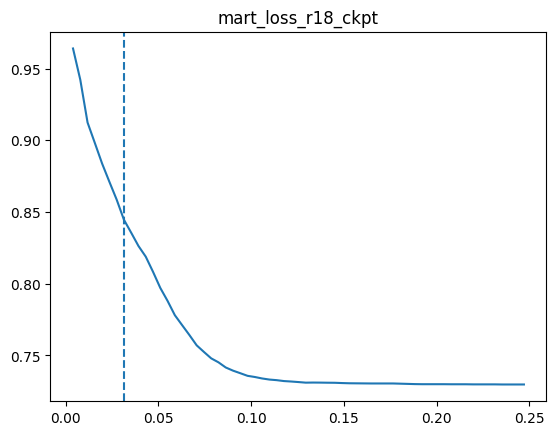

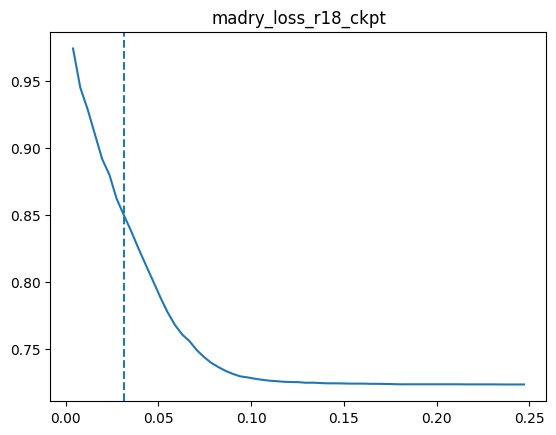

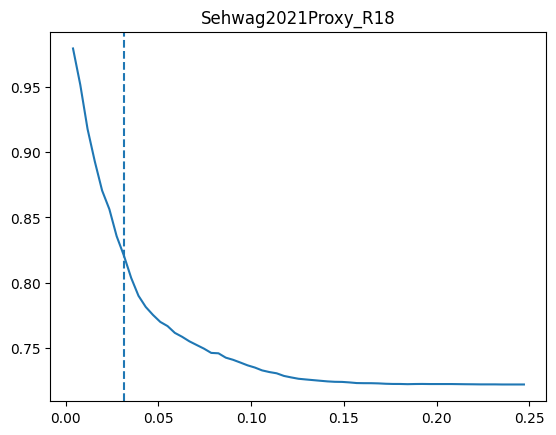

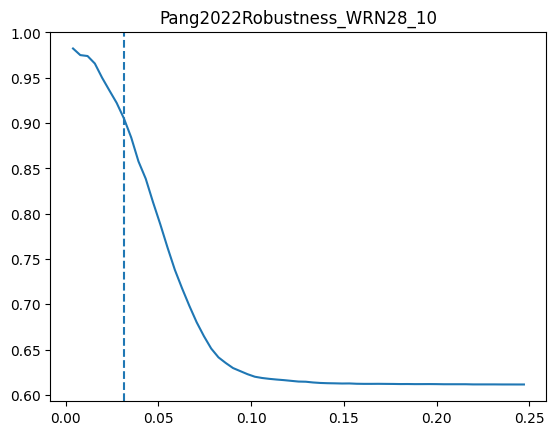

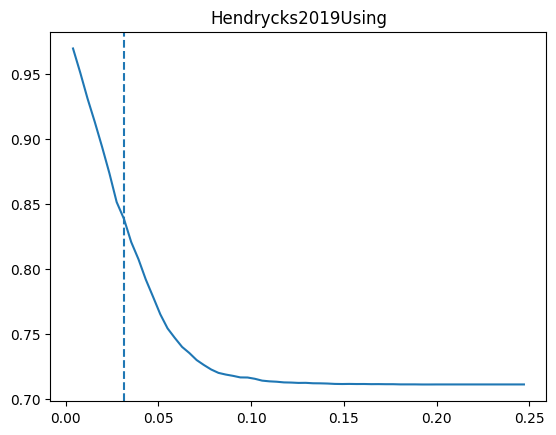

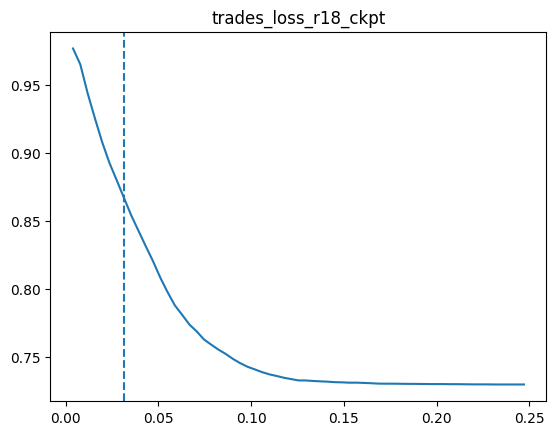

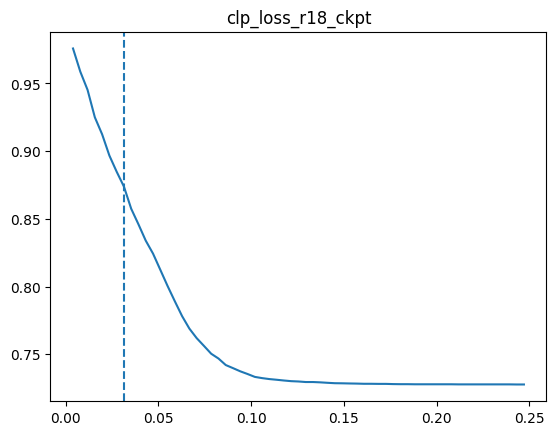

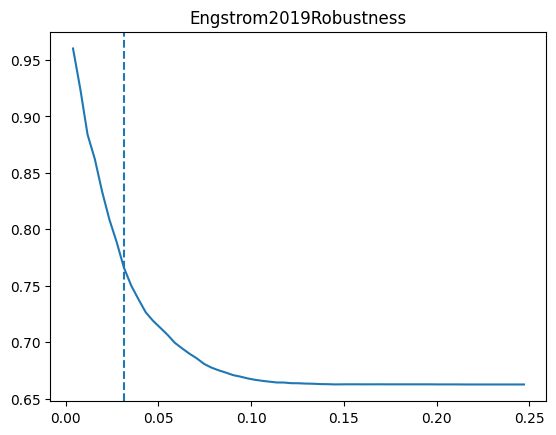

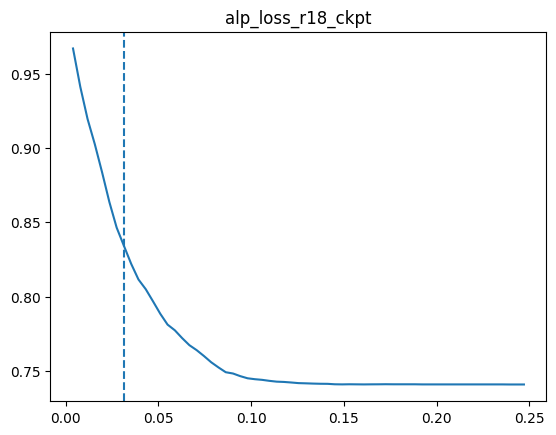

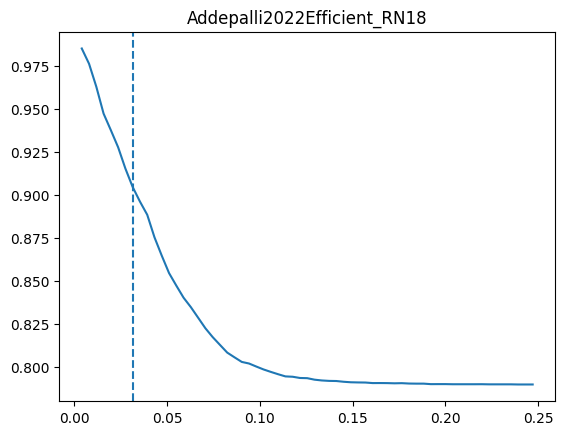

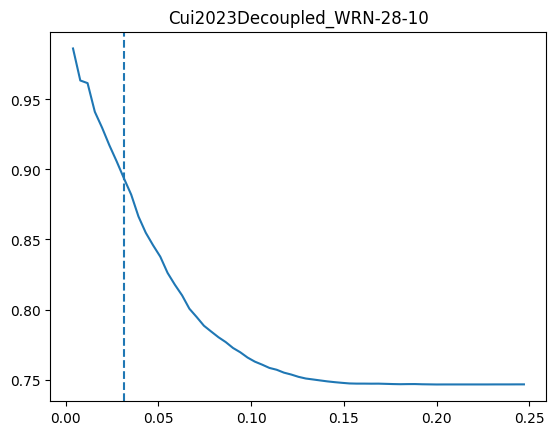

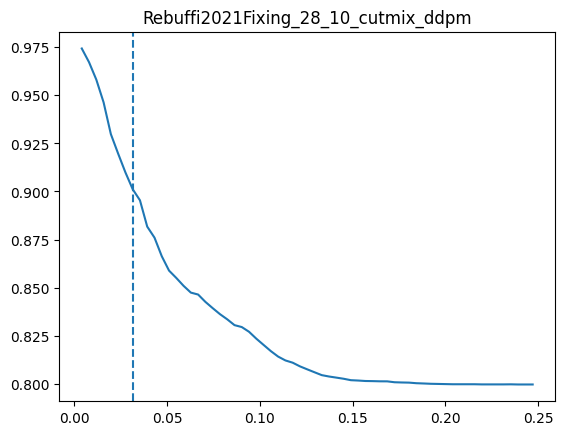

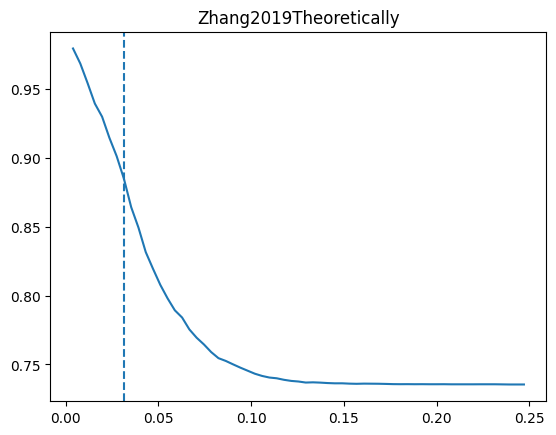

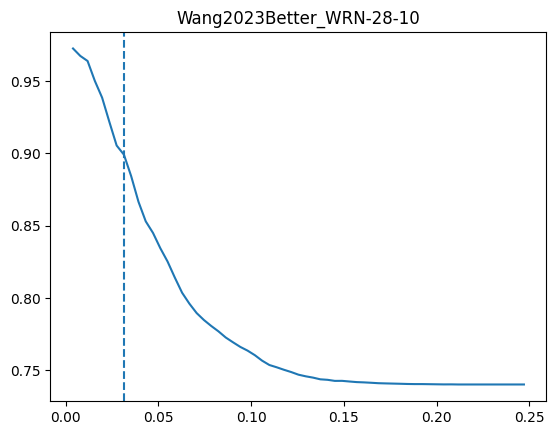

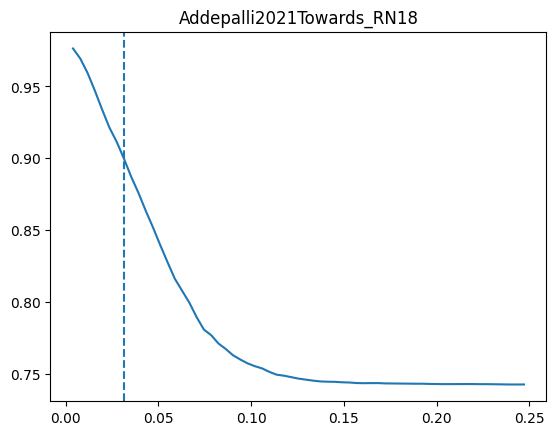

In [270]:
model='Addepalli2021Towards_RN18'
# TOP2 vs TOP2 ADV
xmodels = [m for m in models if robust_accuracies[m]]
for model in xmodels:
    out = torch.load(fget_out_path(model), map_location=torch.device('cpu'))
    out_adv = torch.load(fget_out_path(model, adv=True), map_location=torch.device('cpu'))
    top2 = torch.topk(out, 2)[1]
    top2adv = torch.topk(out_adv, 2)[1]
#     idxs=top2[:,0].eq(top2adv[:,0])
    idxs = unfilteredmodelscores[model]['input dist']<i/255
    lidxs = [unfilteredmodelscores[model]['input dist']<i/255 for i in range(1, 64)]
    accs = [top2[idxs][:,1].eq(top2adv[idxs][:,0]).float().mean() for idxs in lidxs]
#     print(top2[idxs][:,1].eq(top2adv[idxs][:,0]).float().mean(), model)
#     print(top2[:,1].eq(top2adv[:,0]).float().mean(), model)
    plt.figure()
    plt.plot(np.arange(1, 64)/255, accs);
    # plt.plot([robust_accuracies[m] for m in xmodels])
    plt.axvline(8/255, linestyle='dashed')
    plt.title(model)
    plt.show()
    plt.close()

### Dnet

In [379]:
def create_rankdata(model,epsilon=8/255):
    ##Train
    out = torch.load(fget_out_path(model, extra=True), map_location=torch.device('cpu'))
    y = extraunfilteredscores[model]['input dist']
#     y = unfilteredmodelscores[model][scnames.index('distance')]
    #
    y = torch.tensor(y, dtype=torch.float32)/y.max()
    idxtr, idxts = train_test_split(np.arange(len(y)), test_size=0.2,
                                   random_state=0)
    X_train, y_train = out[idxtr], y[idxtr]
    X_test, y_test = out[idxts], y[idxts]
    return X_train, X_test, y_train, y_test

In [380]:
# idx = dfs[model]['norm']<1e-4 
# idx = np.logical_and(np.array(idx),np.array(dfs[model]['adv']==True))
# dfs[model][idx]
class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
#     def forward(self, xpred, xtarget, targetdist):
    def forward(self, xpred, targetdist):
#         ce = torch.nn.CrossEntropyLoss()(xpred, xtarget)
#         h1 = xpred #calc_lmargin(xpred)
        gbr = GBRank_loss(xpred, xpred.flip(0), targetdist, targetdist.flip(0))
        return gbr
#         return ce + gbr 

def GBRank_loss(h1,h2, y1, y2, tau=1e-3):
#     return 0.5 * (torch.maximum(torch.zeros(len(h1)), -(h1-h2-tau)*torch.sign(y1-y2))**2).sum()
    A = (y1-h1-tau)**2 + (y2-h2+tau)**2
    B = (y1-h1+tau)**2 + (y2-h2-tau)**2
    k = len(h1)
    C = 0.5*torch.where(y1<y2, A, B).sum()-k*tau**2
    return torch.where(torch.sign((y1-y2)*(h1-h2))<0,C, 0).mean()

In [381]:
z=torch.Tensor([1,4,2, 3])
print(z, z.flip(0))
MyLoss()(z, z), MyLoss()(z, z.flip(0))

tensor([1., 4., 2., 3.]) tensor([3., 2., 4., 1.])


(tensor(0.), tensor(16.0160))

In [1983]:
tau=1e-3
h1, y1 =z, z.flip(0)
h2, y2 = h1.flip(0), y1.flip(0)
A = (y1-h1-tau)**2 + (y2-h2+tau)**2
B = (y1-h1+tau)**2 + (y2-h2-tau)**2
print(A, B)
torch.where(y1<y2, A, B)

tensor([7.9920, 8.0080, 7.9920, 8.0080]) tensor([8.0080, 7.9920, 8.0080, 7.9920])


tensor([8.0080, 8.0080, 8.0080, 8.0080])

In [1984]:
y1<y2

tensor([False,  True, False,  True])

In [1985]:
h1 = z
targetdist=z.flip(0)
GBRank_loss(h1, h1.flip(0), targetdist, targetdist.flip(0))

tensor(16.0160)

In [382]:
class GBNet(torch.nn.Module):
    def __init__(self, in_features=10)->None:
        super().__init__()
        self.n_classes=2
        n_neurons = 512
        self.arch = torch.nn.Sequential(
            torch.nn.Linear(in_features, n_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons, n_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons, n_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons, n_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons, 1)
        )
        
    def forward(self, x: torch.Tensor)->torch.Tensor:
        out = self.arch(x)
        return out#torch.relu(out)

In [2112]:
# u=torch.Tensor([[1,2,3],[4,5,6]])
u = torch.arange(5).reshape(-1,1)
# (u<u.flip(0)).float()
# u

tensor([[0],
        [1],
        [2],
        [3],
        [4]])

In [431]:
# xmodels =['Ding2020MMA']
xmodels=['Xu2023Exploring_WRN-28-10']
for m in tqdm(xmodels):
    model=m
    print(model)
    loss_fn=torch.nn.MSELoss()
#     loss_fn=MyLoss()
    X_train, X_test, y_train, y_test = create_rankdata(model)
    hmodel = DeepNet(model=GBNet(X_train.shape[1]),
                  loss_fn=loss_fn,
                  verbose=True)
    tr_set = toDataset(X_train, y_train)
    hmodel.num_epochs = 300
    hmodel.train(tr_set)
    print()
    coreval(hmodel, X_train, y_train, model, loss_fn)
    coreval(hmodel, X_test, y_test, model, loss_fn)

  0%|          | 0/1 [00:00<?, ?it/s]

Xu2023Exploring_WRN-28-10


  0%|          | 0/300 [00:00<?, ?it/s]

epoch[1/300]: acc = 0.00 loss = 0.05330
epoch[2/300]: acc = 0.00 loss = 0.03786
epoch[3/300]: acc = 0.00 loss = 0.02601
epoch[4/300]: acc = 0.00 loss = 0.01727
epoch[5/300]: acc = 0.00 loss = 0.01150
epoch[6/300]: acc = 0.00 loss = 0.00872
epoch[7/300]: acc = 0.00 loss = 0.00867
epoch[8/300]: acc = 0.00 loss = 0.01042
epoch[9/300]: acc = 0.00 loss = 0.01230
epoch[10/300]: acc = 0.00 loss = 0.01305
epoch[11/300]: acc = 0.00 loss = 0.01256
epoch[12/300]: acc = 0.00 loss = 0.01134
epoch[13/300]: acc = 0.00 loss = 0.00996
epoch[14/300]: acc = 0.00 loss = 0.00883
epoch[15/300]: acc = 0.00 loss = 0.00812
epoch[16/300]: acc = 0.00 loss = 0.00783
epoch[17/300]: acc = 0.00 loss = 0.00787
epoch[18/300]: acc = 0.00 loss = 0.00810
epoch[19/300]: acc = 0.00 loss = 0.00839
epoch[20/300]: acc = 0.00 loss = 0.00863
epoch[21/300]: acc = 0.00 loss = 0.00876
epoch[22/300]: acc = 0.00 loss = 0.00877
epoch[23/300]: acc = 0.00 loss = 0.00866
epoch[24/300]: acc = 0.00 loss = 0.00847
epoch[25/300]: acc = 0.00

epoch[199/300]: acc = 0.00 loss = 0.00561
epoch[200/300]: acc = 0.00 loss = 0.00561
epoch[201/300]: acc = 0.00 loss = 0.00560
epoch[202/300]: acc = 0.00 loss = 0.00558
epoch[203/300]: acc = 0.00 loss = 0.00557
epoch[204/300]: acc = 0.00 loss = 0.00557
epoch[205/300]: acc = 0.00 loss = 0.00556
epoch[206/300]: acc = 0.00 loss = 0.00556
epoch[207/300]: acc = 0.00 loss = 0.00557
epoch[208/300]: acc = 0.00 loss = 0.00557
epoch[209/300]: acc = 0.00 loss = 0.00556
epoch[210/300]: acc = 0.00 loss = 0.00554
epoch[211/300]: acc = 0.00 loss = 0.00552
epoch[212/300]: acc = 0.00 loss = 0.00552
epoch[213/300]: acc = 0.00 loss = 0.00553
epoch[214/300]: acc = 0.00 loss = 0.00553
epoch[215/300]: acc = 0.00 loss = 0.00552
epoch[216/300]: acc = 0.00 loss = 0.00550
epoch[217/300]: acc = 0.00 loss = 0.00549
epoch[218/300]: acc = 0.00 loss = 0.00549
epoch[219/300]: acc = 0.00 loss = 0.00549
epoch[220/300]: acc = 0.00 loss = 0.00549
epoch[221/300]: acc = 0.00 loss = 0.00549
epoch[222/300]: acc = 0.00 loss = 

In [432]:
def coreval(hmodel, Xt, yt, model, loss_fn=MyLoss()):
    xpred = hmodel.predict(Xt)
    y_score = xpred#calc_lmargin(xpred)
#     print(y_score.shape, Xt.shape, yt.shape)
    cor = scipy.stats.kendalltau(yt.ravel().numpy(), y_score.ravel().numpy())
    pred = torch.sigmoid(xpred-xpred.flip(1))
    ytrue = (yt > yt).float()
    gbloss = loss_fn(pred, ytrue.view(-1,1))
    c = kdlcors[model]['logit margin']
    print(f"k. tau: {cor[0]:.4g}/{c:.4g}, GBRank Loss: {gbloss:.5g}")

In [433]:
coreval(hmodel, X_train, y_train, model, loss_fn)
coreval(hmodel, X_test, y_test, model, loss_fn)

k. tau: 0.5048/0.4348, GBRank Loss: 0.25
k. tau: 0.5033/0.4348, GBRank Loss: 0.25


In [434]:
out = torch.load(fget_out_path(model, extra=False), map_location=torch.device('cpu'))
y = unfilteredmodelscores[model]['input dist']
coreval(hmodel, out, torch.Tensor(y),model )

k. tau: 0.6195/0.4348, GBRank Loss: 0


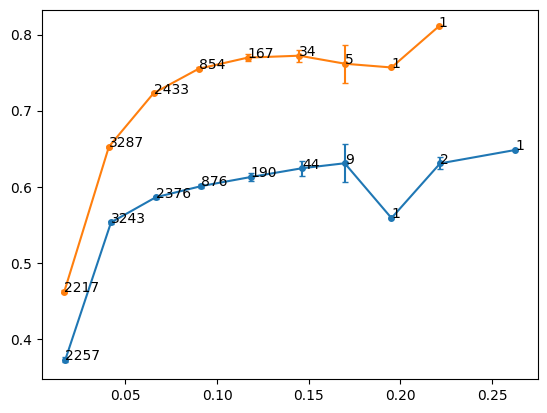

In [438]:
y_score = unfilteredmodelscores[model]['logit margin']
z= (y_score-y_score.min())/(y_score.max()-y_score.min())
idx, zz = lq2(z)
yy= y[idx]
plx(yy, zz,shownumbers=True)
yout = hmodel.predict(out).ravel()
z=(yout-yout.min())/(yout.max()-yout.min())
idx, zz = lq2(z)
yy= y[idx]
plx(yy, zz, shownumbers=True)
# plt.scatter(y, y_score/y_score.max(), s=5, alpha=1.0)
# plt.scatter(y, yout/yout.max(), s=5)

In [1925]:
# hmodel = DeepNet(model=GBNet(X_train.shape[1]),
#                   loss_fn=MyLoss(),
#                   verbose=True)
Xt, yt = X_train, y_train
xpred = hmodel.predict(Xt)
y_score = xpred#calc_lmargin(xpred)
#     print(y_score.shape, Xt.shape, yt.shape)
cor = scipy.stats.kendalltau(yt.ravel().numpy(), y_score.ravel().numpy())
gbloss = MyLoss()(xpred.ravel(), yt)
c = kdlcors[model]['logit margin']
print(f"k. tau: {cor[0]:.2f}/{c:.2f}, GBRank Loss: {gbloss:.2g}")

k. tau: 0.48/0.43, GBRank Loss: 0.00075


In [1824]:
# m = list(hmodel.model.children())[0]
# c1 = list(m.children())[0]
# ca = list(m.children())[1]
# c2 = list(m.children())[2]
# Xt2 = ca(Xt@c1.weight.T+c1.bias)
# (Xt2@c2.weight.T+c2.bias)

In [1830]:
for i in range(10):
    hmodel = DeepNet(model=GBNet(X_train.shape[1]),
                  loss_fn=MyLoss(),
                  verbose=True)
    a = hmodel.predict(torch.zeros_like(Xt)).ravel()
#     plt.hist(a, bins=20)
#     plt.show()
#     plt.close()
    print(a.unique())

tensor([0.])
tensor([0.0237])
tensor([0.0323])
tensor([0.0283])
tensor([0.])
tensor([0.])
tensor([0.0341])
tensor([0.0176])
tensor([0.])
tensor([0.0085])


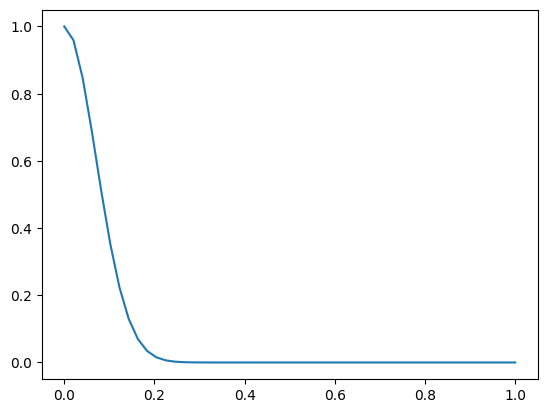

In [215]:
# import math
def gaussian_act(x, mean=0, alpha=1e2):
    k=1 #/ (math.sqrt(2 * math.pi) * std)
    return k * torch.exp(-alpha*(x - mean)**2)
x = torch.tensor(np.linspace(0,1))
plt.plot(x, gaussian_act(x));

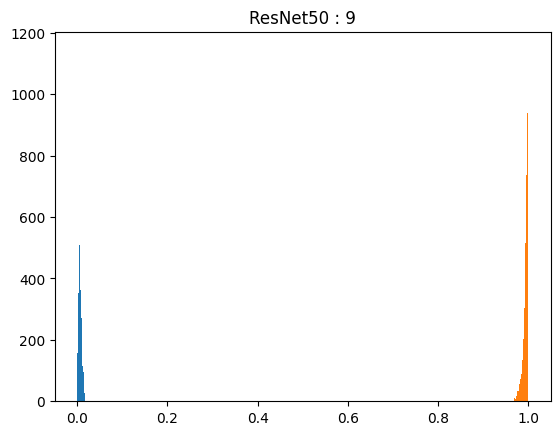

In [216]:
# # xmodels=[m for m in models if robust_accuracies[m]<1]
for model in xmodels:
    plt.figure()
    scores = 1*extraunfilteredscores[model][-1]
#     scores = gaussian_act(torch.tensor(scores))
    q1=np.percentile(scores, 1)
    q2=np.percentile(scores, 99)
    filtered_data = scores[(scores > q1) & (scores < q2)]
    plt.hist(filtered_data, bins=20);
    plt.hist(gaussian_act(torch.tensor(filtered_data)), bins=20);
    plt.title(model+f" : {sum(abs(scores)<1e-4)}")
    plt.show()
    plt.close()

In [661]:
pm = PM(out, targets)
pm2= calc_tpmargin(out, targets, from_logits=True)
torch.testing.assert_close(-pm2, pm)

In [654]:
def PM(logit, target):
    eye = torch.eye(10)
    probs_GT = (logit.softmax(1) * eye[target]).sum(1).detach()
    top2_probs = logit.softmax(1).topk(2, largest = True)
    GT_in_top2_ind = (top2_probs[1] == target.view(-1,1)).float().sum(1) == 1
    probs_2nd = torch.where(GT_in_top2_ind, top2_probs[0].sum(1) - probs_GT, top2_probs[0][:,0]).detach()
    return  probs_2nd - probs_GT

In [652]:
out = torch.load(get_out_path(model), map_location=torch.device('cpu'))

In [771]:
sel=lambda x, idx: x.gather(1, idx.view(-1,1))
sel(p, pred_idx)

tensor([[0.3262],
        [0.7964],
        [0.5594],
        ...,
        [0.6139],
        [0.5672],
        [0.7924]])

In [787]:
# l = out
# sel=lambda x, idx: x.gather(1, idx.view(-1,1))
# idx_sort = torch.argsort(l, axis=1)
# pred_idx = idx_sort[:,-1]
# second_idx = idx_sort[:,-2]
# p = torch.softmax(l, axis=1)
# # compute grad of crossentropy with label equal to prediction (argmax)
# grad_l= p.clone()
# grad_l[:,pred_idx] = sel(p, pred_idx)-1
# normgr= np.linalg.norm(grad_l, axis=1)
# numerateur = (sel(l, pred_idx)- sel(l, second_idx))
# denominateur = (sel(p, second_idx)-sel(p, pred_idx)+1)
# myscore=(numerateur.ravel()/denominateur.ravel())*normgr
# print(myscore.shape, numerateur.shape, denominateur.shape, normgr.shape)

In [789]:
# from scoreslib import logit_dist_to_db
# score = logit_dist_to_db(out)

In [676]:
outpath = "../xps/cifar10/Sehwag2021Proxy_R18_Linf_New/autoattack_results.csv"
df = pd.read_csv(outpath)

In [737]:
# robust_accuracies['Sehwag2021Proxy_R18']
d= unfilteredmodelscores['Ding2020MMA'][-1]
# df = dfs['Sehwag2021Proxy_R18']
cr = correct_predictions['Ding2020MMA']
np.logical_and(d>8/255, cr).sum(), robust_accuracies['Ding2020MMA']

(4744, 41.44)

In [738]:
classifiers

{'Ding2020MMA': <modeling.DeepNet at 0x354c25040>,
 'Xu2023Exploring_WRN-28-10': <modeling.DeepNet at 0x332c28520>,
 'mart_loss_r18_ckpt': <modeling.DeepNet at 0x344a2fe80>,
 'cifar10_resnet44': <modeling.DeepNet at 0x324240460>,
 'madry_loss_r18_ckpt': <modeling.DeepNet at 0x3448163a0>,
 'cifar10_resnet32': <modeling.DeepNet at 0x34467f310>,
 'Sehwag2021Proxy_R18': <modeling.DeepNet at 0x32d6b6e20>,
 'Pang2022Robustness_WRN28_10': <modeling.DeepNet at 0x324257f10>,
 'Hendrycks2019Using': <modeling.DeepNet at 0x32428c550>,
 'trades_loss_r18_ckpt': <modeling.DeepNet at 0x344a3e1c0>,
 'clp_loss_r18_ckpt': <modeling.DeepNet at 0x3449ce4c0>,
 'Standard': <modeling.DeepNet at 0x3449dbe80>,
 'Engstrom2019Robustness': <modeling.DeepNet at 0x34462b550>,
 'alp_loss_r18_ckpt': <modeling.DeepNet at 0x324251310>,
 'Addepalli2022Efficient_RN18': <modeling.DeepNet at 0x344a5b460>,
 'Cui2023Decoupled_WRN-28-10': <modeling.DeepNet at 0x3449ceca0>,
 'Rebuffi2021Fixing_28_10_cutmix_ddpm': <modeling.Deep

In [695]:
len(df[(df['Adv'] == False) & (df['Acc'] == True)])/100

55.54

In [1742]:
class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, output, target, targetdist):
        ce = torch.nn.CrossEntropyLoss()(output, target)
        mse = torch.nn.MSELoss()(calc_lmargin(output), targetdist)
        return ce + mse 

In [94]:
# For Ding sqrt(y) does the job with sigmoid as last activation
def get_dbdata(model,epsilon=8/255):
    ##Train
    out = torch.load(fget_out_path(model, extra=True), map_location=torch.device('cpu'))
    y = extraunfilteredscores[model]['input dist']
    y = torch.Tensor(y)
    y= torch.sqrt(y)
#     y = (y-y.min())/(y.max()-y.min())
    idxtr, idxts = train_test_split(np.arange(len(out)), test_size=0.2,
                                   random_state=0)
    X_train, y_train = out[idxtr], y[idxtr]
    X_test, y_test = out[idxts], y[idxts]

#     print(y, idxtr)
    ##
#     q1=np.percentile(y_train, 2)
#     q2=np.percentile(y_train, 95)
#     iftr = (y_train > q1) & (y_train < q2)
#     X_train, y_train = X_train[iftr], y_train[iftr]
    ##Test
#     y_1h_train = (y_train<epsilon).numpy().astype(int)
#     y_1h_test = (y_test<epsilon).numpy().astype(int)
    return X_train, X_test, y_train, y_test, idxtr, idxts, y#, y_1h_train, y_1h_test

In [335]:
def regcoreval(regr, X_test, y_test, model):
    y_score = regr.predict(X_test)
    cor = scipy.stats.kendalltau(y_test.ravel().numpy(), y_score.ravel().numpy())
    rmse = torch.sqrt(regr.loss_fn(y_test.view(-1,1), y_score.view(-1,1)))
    c = kdlcors[model]['logit margin']
    print(f"k. tau: {cor[0]:.2f}/{c:.2f}, rmse: {rmse:.2f}")

In [339]:
def get_data512(model,epsilon=8/255):
    ##Train
    out = torch.load(fget_out_path(model, extra=True), map_location=torch.device('cpu'))
    y = extraunfilteredscores[model]['input dist']
    y = torch.Tensor(y)
    y= torch.sqrt(y)
    idxtr, idxts = train_test_split(np.arange(len(y)), test_size=0.2,
                                   random_state=0)
    X_train, y_train = out[idxtr], y[idxtr]
    X_test, y_test = out[idxts], y[idxts]
    ##
#     q1=np.percentile(y_train, 2)
#     q2=np.percentile(y_train, 95)
#     iftr = (y_train > q1) & (y_train < q2)
#     X_train, y_train = X_train[iftr], y_train[iftr]
    ##Test
#     y_1h_train = (y_train<epsilon).numpy().astype(int)
#     y_1h_test = (y_test<epsilon).numpy().astype(int)
    return X_train, X_test, y_train, y_test, idxtr, idxts#, y_1h_train, y_1h_test

<a id='dnet'>.</a>

In [354]:
Nclassifiers = dict()
xmodels =['Ding2020MMA', 'Xu2023Exploring_WRN-28-10']
# xmodels = [m for m in models if 'ce' not in m]
splits=dict()
Nc=1
for model in tqdm(xmodels[:]):
    print(model)
    Nclassifiers[model]=[]
    X_train, X_test, y_train, y_test, idxtr, idxts =get_data512(model)
    splits[model]=(idxtr, idxts)
    for j in range(Nc):
#         splits[model].append((idxtr, idxts))
        regr = DeepNet(model=CNET(X_train.shape[1]),
                      loss_fn=torch.nn.MSELoss(),
                      verbose=False)
        tr_set = toDataset(X_train, y_train)
        regr.num_epochs = 500
        regr.batch_size= 5000
        regr.train(tr_set, seed=j*41)
        Nclassifiers[model].append(regr)
        regcoreval(regr, X_train, y_train, model)
        regcoreval(regr, X_test, y_test, model)
    print()

  0%|          | 0/2 [00:00<?, ?it/s]

Ding2020MMA


  0%|          | 0/500 [00:00<?, ?it/s]

k. tau: 0.77/0.28, rmse: 0.04
k. tau: 0.57/0.28, rmse: 0.07

Xu2023Exploring_WRN-28-10


  0%|          | 0/500 [00:00<?, ?it/s]

k. tau: 0.51/0.43, rmse: 0.04
k. tau: 0.51/0.43, rmse: 0.04



In [355]:
regr.model

CNET(
  (arch): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [356]:
def test_perf(clf, X, y, z, split='Train', verbose=True):
    y_score = clf.predict(X)
    cor = scipy.stats.kendalltau(y.ravel().numpy(), y_score.ravel().numpy())
    corbefore = scipy.stats.kendalltau(y.ravel().numpy(), z.ravel().numpy())
    rmse = torch.sqrt(regr.loss_fn(y.view(-1,1), y_score.view(-1,1)))
    if verbose:
        print(f"{split}: {corbefore[0]:.2g} {cor[0]:.2g} {rmse:.3g}")
    return cor[0], corbefore[0], rmse

def get_list_perf(model, X, y, z, split, verbose):
    cors=[]
    corsb=[]
    rmses=[]
    for clf in  Nclassifiers[model]:
        cor, corb, rmse = test_perf(clf,X, y, z, split, verbose)
        cors.append(cor)
        corsb.append(corb)
        rmses.append(rmse)
    return np.array(corsb), np.array(cors), np.array(rmses)

for model in xmodels[:]:
    print(model)
    out = torch.load(fget_out_path(model, extra=True), map_location=torch.device('cpu'))
    y = extraunfilteredscores[model]['input dist']
    y = torch.Tensor(y)
    y = torch.sqrt(y)
    idxtr, idxts = splits[model]
    Xtr, ytr = out[idxtr], y[idxtr]
#     torch.testing.assert_close(y, yo)
    Xval, yval = out[idxts], y[idxts]
    z = extraunfilteredscores[model]['logit margin']
    z = torch.Tensor(z)
    ztr, zval = z[idxtr], z[idxts]
    A, B, C = get_list_perf(model,Xtr, ytr, ztr, split='Train', verbose=False)
    print(f"Train: {A.mean():.2f}+/{A.std():.2f} \t {B.mean():.2f}+/-{B.std():.2f} \t {C.mean():.2f}+/-{C.std():.2f}")
    
    A, B, C = get_list_perf(model,Xval, yval, zval, split='Val', verbose=False)
    print(f"Val: {A.mean():.2f}+/-{A.std():.2f} \t {B.mean():.2f}+/-{B.std():.2f} \t {C.mean():.2f}+/-{C.std():.2f}")

    out = torch.load(fget_out_path(model), map_location=torch.device('cpu'))
    y = unfilteredmodelscores[model]['input dist']
    y = torch.Tensor(y)
    z = unfilteredmodelscores[model]['logit margin']
    z = torch.Tensor(z)
    A, B, C = get_list_perf(model,out, y, z, split='Test', verbose=False)
    print(f"Test: {A.mean():.2f}+/-{A.std():.2f} \t {B.mean():.2f}+/-{B.std():.2f} \t {C.mean():.2f}+/-{C.std():.2f}")
    print()

Ding2020MMA
Train: 0.31+/0.00 	 0.77+/-0.00 	 0.04+/-0.00
Val: 0.29+/-0.00 	 0.57+/-0.00 	 0.07+/-0.00
Test: 0.28+/-0.00 	 0.57+/-0.00 	 0.17+/-0.00

Xu2023Exploring_WRN-28-10
Train: 0.24+/0.00 	 0.51+/-0.00 	 0.04+/-0.00
Val: 0.26+/-0.00 	 0.51+/-0.00 	 0.04+/-0.00
Test: 0.43+/-0.00 	 0.62+/-0.00 	 0.17+/-0.00



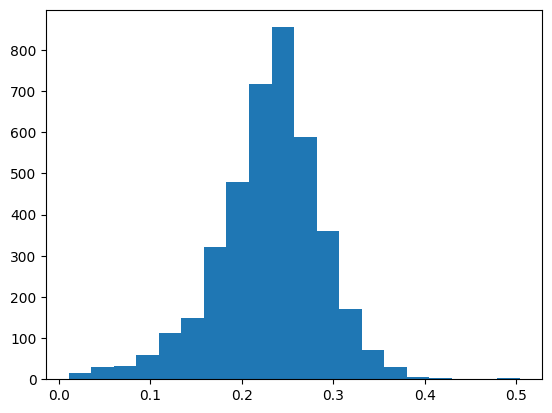

In [357]:
# plt.hist(torch.sigmoid(y_train), 20);
y =unfilteredmodelscores[model]['input dist']
# plt.hist(lq2(y_train)[1], 20);
plt.hist(y_train, 20);
# plt.hist(y, 20, alpha=0.5);
# plt.hist(lq2(y)[1], 20, alpha=0.5);

/Users/nj/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nj/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nj/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nj/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

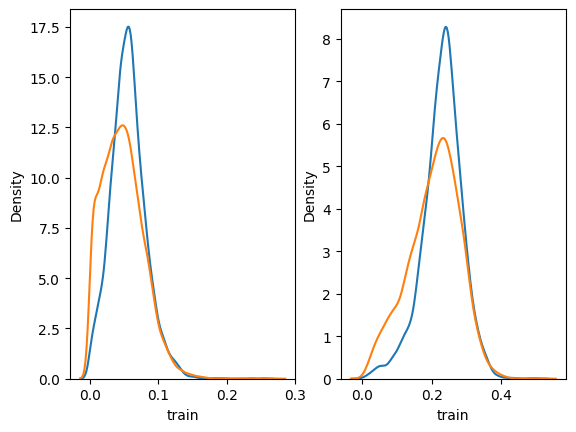

In [349]:
yx = extraunfilteredscores[model]['input dist']
dts = pd.DataFrame({"train": yx})
dts2 = pd.DataFrame({"train": y})
plt.subplot(1,2,1)
sns.kdeplot(data=dts, x="train");
sns.kdeplot(data=dts2, x="train");
dts = pd.DataFrame({"train": torch.sqrt(torch.tensor(yx))})
dts2 = pd.DataFrame({"train": torch.sqrt(torch.tensor(y))})
plt.subplot(1,2,2)
sns.kdeplot(data=dts, x="train");
sns.kdeplot(data=dts2, x="train");
# Show the plot
plt.show()

In [373]:
## ||w(h-h')|| - ||x-x'||

In [291]:
A = torch.linalg.lstsq(X_train, y_train).solution
class RegM:
    def __init__(self, A):
        super().__init__()
        self.mat = A
        self.loss_fn = torch.nn.MSELoss()
    def predict(self, X):
        return X@self.mat
regm=RegM(A)
regcoreval(regm, X_train, y_train, model)
regcoreval(regm, X_test, y_test, model)
regcoreval(regr, X_train, y_train, model)
regcoreval(regr, X_test, y_test, model)

k. tau: -0.10/0.28, rmse: 0.19
k. tau: -0.09/0.28, rmse: 0.19
k. tau: -0.06/0.28, rmse: 0.15
k. tau: -0.08/0.28, rmse: 0.16


In [143]:
# regrtmp = regr

In [539]:
# regrtmp = classifiers[model]
# classifiers[model] = regr

In [133]:
# out = torch.load(fget_out_path(model), map_location=torch.device('cpu'))
# y = 1e2*unfilteredmodelscores[model]['input dist']
# y = torch.tensor(y, dtype=torch.float32)
# y_score = regr.predict(out)
# cor10k = scipy.stats.kendalltau(y.ravel().numpy(), y_score.ravel().numpy())
# cor10k

In [134]:
# k=1
# regr=Nclassifiers[model][0]
# y_score = regr.predict(X_train)/k
# # refscore = score_fn(logits, labels, from_logits=True)
# refscore=y_train/k
# plt.scatter(np.zeros_like(y_score), y_score, c=y_1h_train, s=5);
# plt.figure()
# plt.scatter(y_train, y_train/k, c=y_1h_train, s=5);
# plt.figure()
# plt.scatter(refscore, y_score, c=y_1h_train, s=5);
# plt.figure()
# y_score = regr.predict(X_test)/k
# plt.scatter(y_test, y_score, c=y_1h_test, s=5);

In [124]:
# for model in xmodels:
#     y = unfilteredmodelscores[model]['input dist']
#     y_lm = unfilteredmodelscores[model]['logit margin']
#     y_pm = unfilteredmodelscores[model]['prob. margin']

#     c1=scipy.stats.pearsonr(y_lm, y_score)[0]
# #     c2=scipy.stats.spearmanr(y, y_lm)[0]
#     print(f"{c1:.3f} {model}")

In [126]:
# print(f"score  lm")
# for model in models:
#     y = unfilteredmodelscores[model][scnames.index('distance')]
#     y_score = unfilteredmodelscores[model][scnames.index('logit dist')]
#     y_lsp = unfilteredmodelscores[model][scnames.index('kl div')]
#     y_lm = unfilteredmodelscores[model][scnames.index('logit margin')]
#     y_pm = unfilteredmodelscores[model][scnames.index('prob. margin')]

# #     c1=scipy.stats.spearmanr(y, y_score)[0]
# #     c2=scipy.stats.spearmanr(y, y_lm)[0]
# #     print(f"{c1:.3f} {c2:.3f} {model}")
#     df = pd.DataFrame({'logit dist score': y_score,
#                        'input space distance': y,
#                        'logit space distance': y_lsp,
#                        'logit margin': y_lm,
#                        'prob. margin': y_pm})
#     fig=px.scatter(df,x="logit space distance", y='input space distance' , marginal_x="histogram", marginal_y="histogram")
#     fig.write_html(os.path.join('./',f"{model}_vs_LP.html"))
#     print(model)

In [127]:
# model = 'cifar10_resnet20'
# y = unfilteredmodelscores[model][scnames.index('distance')]
# y_score = unfilteredmodelscores[model][scnames.index('logit dist')]
# y_lsp = unfilteredmodelscores[model][scnames.index('kl div')]
# y_lm = unfilteredmodelscores[model][scnames.index('logit margin')]
# y_pm = unfilteredmodelscores[model][scnames.index('prob. margin')]

# df = pd.DataFrame({'logit dist score': y_score,
#                    'input space distance': y,
#                    'logit space distance': y_lsp,
#                    'logit margin': y_lm,
#                    'prob. margin': y_pm})
# fig=px.scatter(df,x="logit dist score", y='input space distance' , marginal_x="histogram", marginal_y="histogram")
# fig.write_html(os.path.join('./',f"{model}_vs_dist.html"))

# fig=px.scatter(df,x="logit dist score", y='logit space distance' , marginal_x="histogram", marginal_y="histogram")
# fig.write_html(os.path.join('./',f"{model}_vs_lspdist.html"))

# fig=px.scatter(df,x="logit dist score", y='logit margin' , marginal_x="histogram", marginal_y="histogram")
# fig.write_html(os.path.join('./',f"{model}_vs_lsplm.html"))

# fig=px.scatter(df,x="logit dist score", y='prob. margin' , marginal_x="histogram", marginal_y="histogram")
# fig.write_html(os.path.join('./',f"{model}_vs_lsppm.html"))

In [128]:
# fig=px.scatter(df,x="logit margin", y='input space distance' , marginal_x="histogram", marginal_y="histogram")
# fig.write_html(os.path.join('./',f"{model}_vs_distlm.html"))

In [467]:
# model = 'Sehwag2021Proxy_R18'
# out = torch.load(get_out_path(model), map_location=torch.device('cpu'))
# y = unfilteredmodelscores[model][scnames.index('distance')]
# y_score = regr.predict(out).ravel()/1e2
# df = pd.DataFrame({'Dnet Score': y_score, 'distance': y})
# fig=px.scatter(df,x="Dnet Score", y='distance' , marginal_x="histogram", marginal_y="histogram")
# fig.write_html(os.path.join('./',f"{model}_vs_dnetscore.html"))

# y_score = unfilteredmodelscores[model][scnames.index('max prob.')]
# df = pd.DataFrame({'max prob': y_score, 'distance': y})
# fig=px.scatter(df,x="max prob", y='distance' , marginal_x="histogram", marginal_y="histogram")
# fig.write_html(os.path.join('./',f"{model}_vs_maxprob.html"))

In [129]:
# xudnetscores = unfilteredmodelscores[model]['dnet']

In [358]:
#Refill
for model in xmodels:
    regr = Nclassifiers[model][0]
    out = torch.load(fget_out_path(model), map_location=torch.device('cpu'))
    y = unfilteredmodelscores[model]['input dist']
    y = torch.tensor(y, dtype=torch.float32)
    y_score = regr.predict(out)
    cor10k = scipy.stats.kendalltau(y.ravel().numpy(), y_score.ravel().numpy())
    c10k = kdlcors[model]['logit margin']
    ##refill dnet scorfe
    unfilteredmodelscores[model]['dnet'] = y_score.ravel()
    kdlcors[model]['dnet'] = cor10k[0]

In [360]:
basescore='dnet'
for model in xmodels:
    regr = Nclassifiers[model][0]
    out = torch.load(fget_out_path(model), map_location=torch.device('cpu'))
    y = unfilteredmodelscores[model]['input dist']
    y = torch.tensor(y, dtype=torch.float32)
    y_score = regr.predict(out)
    cor10k = scipy.stats.kendalltau(y.ravel().numpy(), y_score.ravel().numpy())
    y = unfilteredmodelscores[model][basescore]
    c10k = kdlcors[model][basescore]
    
    out = torch.load(fget_out_path(model, extra=True), map_location=torch.device('cpu'))
    idxtr, idxts = train_test_split(np.arange(len(out)), test_size=0.2,
                                   random_state=0)
    y = extraunfilteredscores[model]['input dist']
    y = torch.Tensor(y)
    Xtr, ytr = out[idxtr], y[idxtr]
    Xval, yval = out[idxts], y[idxts]
    y = extraunfilteredscores[model][basescore]
    y = torch.Tensor(y)
    ztr, zval = y[idxtr], y[idxts]

    y_score = regr.predict(out)
    cor5k = scipy.stats.kendalltau(y.ravel().numpy(), y_score.ravel().numpy())
    c5k = extrakdlcors[model]['prob. margin']
    
    print(f"k. tau:5k:{cor5k[0]:.2f}/{c5k:.2f}   10k: {cor10k[0]:.2f}/{c10k:.2f} {model}")

k. tau:5k:0.00/0.30   10k: 0.57/0.57 Ding2020MMA
k. tau:5k:0.01/0.25   10k: 0.62/0.62 Xu2023Exploring_WRN-28-10


In [500]:
xmodels =['Ding2020MMA', 'Xu2023Exploring_WRN-28-10']
scorename='dnet'
eps=8/255
nonrobust_flags = bin_separate(dfs, eps)
xrobres = get_AUCs(xmodels, nonrobust_flags,
                 xscores=unfilteredmodelscores, kdlcors=kdlcors)
show_table(xmodels, scorename, kdlcors, xrobres)

dnet
          	K. tau	auroc	aupr	fpr@95	acc	rob.acc	arch
------------------------------------------------------------
Ding2020MMA	0.57	88.49	89.04	51.13	84.36	41.44	WideResNet-28-4
------------------------------------------------------------
Xu2023Explori	0.62	93.66	90.22	33.00	93.69	63.89	WideResNet-28-10
------------------------------------------------------------


Model ID Kendall tau  AUROC   AUPR  FPR95    Acc Rob. Acc      Architecture
0      DI0        0.57  88.49  89.04  51.13  84.36    41.44   WideResNet-28-4
1     XU80        0.62  93.66  90.22  33.00  93.69    63.89  WideResNet-28-10

0.31/\textbf{0.57} & 70.34/\textbf{88.49} & 74.07/\textbf{89.04}	& 81.60/\textbf{51.13}
0.51/\textbf{0.62} & 87.50]]/\textbf{93.66} & 71.46/\textbf{90.22}	&71.46/\textbf{33.00}

In [501]:
show_table(xmodels, basescore, kdlcors, xrobres)

logit margin
          	K. tau	auroc	aupr	fpr@95	acc	rob.acc	arch
------------------------------------------------------------
Ding2020MMA	0.28	67.49	70.91	82.56	84.36	41.44	WideResNet-28-4
------------------------------------------------------------
Xu2023Explori	0.43	83.30	80.50	83.42	93.69	63.89	WideResNet-28-10
------------------------------------------------------------


Model ID Kendall tau  AUROC   AUPR  FPR95    Acc Rob. Acc      Architecture
0      DI0        0.28  67.49  70.91  82.56  84.36    41.44   WideResNet-28-4
1     XU80        0.43  83.30  80.50  83.42  93.69    63.89  WideResNet-28-10

In [502]:
for model in xmodels:
    print(model)
    for s in ['logit margin', 'dnet']:
        print(xrobres['auroc'][model][s], xrobres['aupr'][model][s], xrobres['fprattpr'][model][s][0], s)
    print()

Ding2020MMA
0.674946377947852 0.7091395326954671 0.8256052523594584 logit margin
0.8848908610924282 0.8903620943415139 0.5112843660237998 dnet

Xu2023Exploring_WRN-28-10
0.8330007051524833 0.8049877740411464 0.8342419331074112 logit margin
0.9366284961670603 0.9022248106581376 0.33004272874613233 dnet



Ding2020MMA
Xu2023Exploring_WRN-28-10


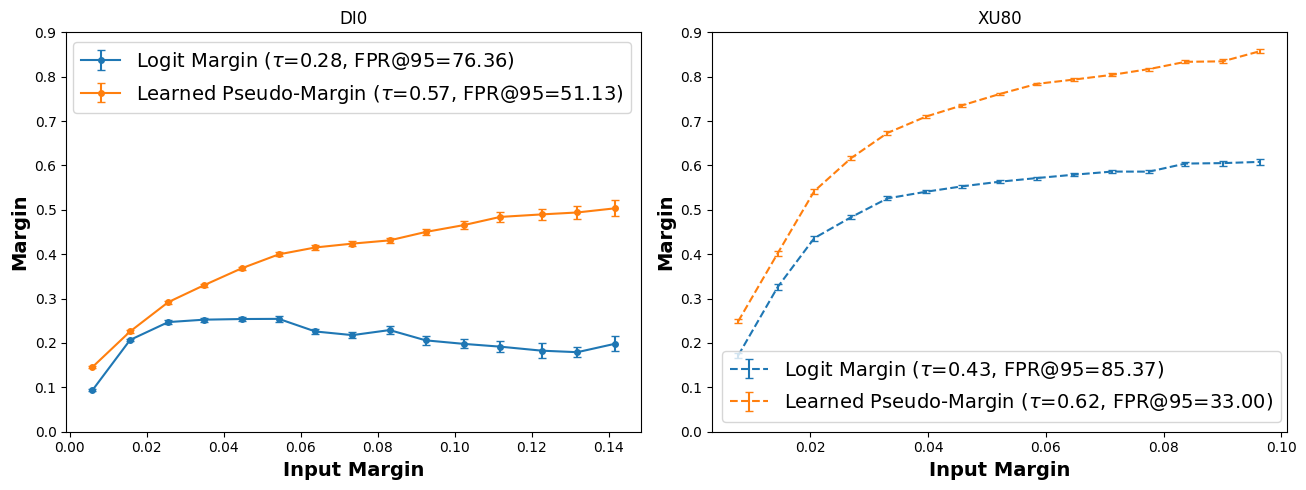

In [503]:
N = 15
N2=10
score='dnet'
basescore='logit margin'
# plt.subplots()
plt.figure(figsize=(14, 5))
counter=0
for model in xmodels[:]:
    counter=counter+1
    X= unfilteredmodelscores[model]['input dist']
    Y = unfilteredmodelscores[model][score]
    idxs, X =lq2(X)
    Y = Y[idxs]
    m, M=Y.min(), Y.max()
    Y = (Y-m)/(M-m)
    
    Z = unfilteredmodelscores[model][basescore]
    Z = Z[idxs]
    m, M=Z.min(), Z.max()
    Z = (Z-m)/(M-m)
#     print(counter)
    plt.subplot(1,2,counter)
    ridxs = random.sample(list(np.arange(len(X))), 1000)
#     plt.scatter(X[ridxs], Y[ridxs], s=1)
#     plt.scatter(X[ridxs], Z[ridxs], s=1)
    fpr950 = xrobres['fprattpr'][model]['logit dist'][0]*100
    fpr951 = xrobres['fprattpr'][model]['dnet'][0]*100
    plx(X, Z, M=N, label=f"Logit Margin ($\\tau$={kdlcors[model][basescore]:.2f}, FPR@95={fpr950:.2f})",
       shownumbers=False,ls=linestyles[model], fmt=markers[model])
    plx(X, Y, M=N, label=f"Learned Pseudo-Margin ($\\tau$={kdlcors[model][score]:.2f}, FPR@95={fpr951:.2f})",
           shownumbers=False, ls=linestyles[model], fmt=markers[model])
    plt.xlabel('Input Margin', fontsize=14, weight='bold')
    plt.ylabel('Margin', fontsize=14, weight='bold')
    print(model)
    if 'Xux' in model:
        plt.legend(bbox_to_anchor=(0.5, 0.5), prop={"size": 12})
    else:
        plt.legend(prop={"size": 14})
    plt.title(getps(model, code=True).upper())
    plt.ylim(0, 0.9)
# plt.axvline(8/255, linestyle='--')
# Display the plot
# plt.axis('equal')
# plt.legend()
# x = [i/255 for i in range(1, 40, 4)]
# xticks = [f"{i/255:.2f}" for i in range(1, 40, 4)]
# extraticks=[plt.Text(8/255, 0, "8/255")]
# plt.xticks(list(plt.xticks()[0]) + [8/255], list(plt.xticks()[1])+extraticks, rotation=75 )
# plt.xticks(x, xticks,rotation=75)
plt.tight_layout()
plt.savefig('figures/dnet_errorbar.pdf', bbox_inches='tight')
plt.show()
plt.close()

[Go to Epsvar](#epsvar)

### Plot Correlations

In [30]:
for model in [model for model in models if robust_accuracies[model]>1]:
    print(model, kdlcors[model]['max prob.'])

Ding2020MMA 0.2770099751884569
Debenedetti2022Light_XCiT-S12 0.7172783701933272
Xu2023Exploring_WRN-28-10 0.43365734256293176
Debenedetti2022Light_XCiT-M12 0.6887471902179145
mart_loss_r18_ckpt 0.619320386770981
madry_loss_r18_ckpt 0.7361525006250522
Sehwag2021Proxy_R18 0.7191011337088871
Pang2022Robustness_WRN28_10 0.7519310561270114
Hendrycks2019Using 0.7413783224871059
trades_loss_r18_ckpt 0.7030989370713234
clp_loss_r18_ckpt 0.7480320566486662
Engstrom2019Robustness 0.7254650093823188
alp_loss_r18_ckpt 0.701176444170336
Addepalli2022Efficient_RN18 0.7527996232182336
Cui2023Decoupled_WRN-28-10 0.7137429998731816
Rebuffi2021Fixing_28_10_cutmix_ddpm 0.7509266904378038
Zhang2019Theoretically 0.7268377235809892
Wang2023Better_WRN-28-10 0.7207026336811927
Addepalli2021Towards_RN18 0.7283066873115472


In [31]:
# score1 = dfs[model]['fab norm 2']
# score2 = dfs[model]['norm']
# cor = scipy.stats.kendalltau(score1, score2)[0]
# plt.scatter(score1, score2);
# cor

In [63]:
xscnames=['prob. margin',
 'logit margin',
 'max prob.',
 'output dist',
 'input dist']

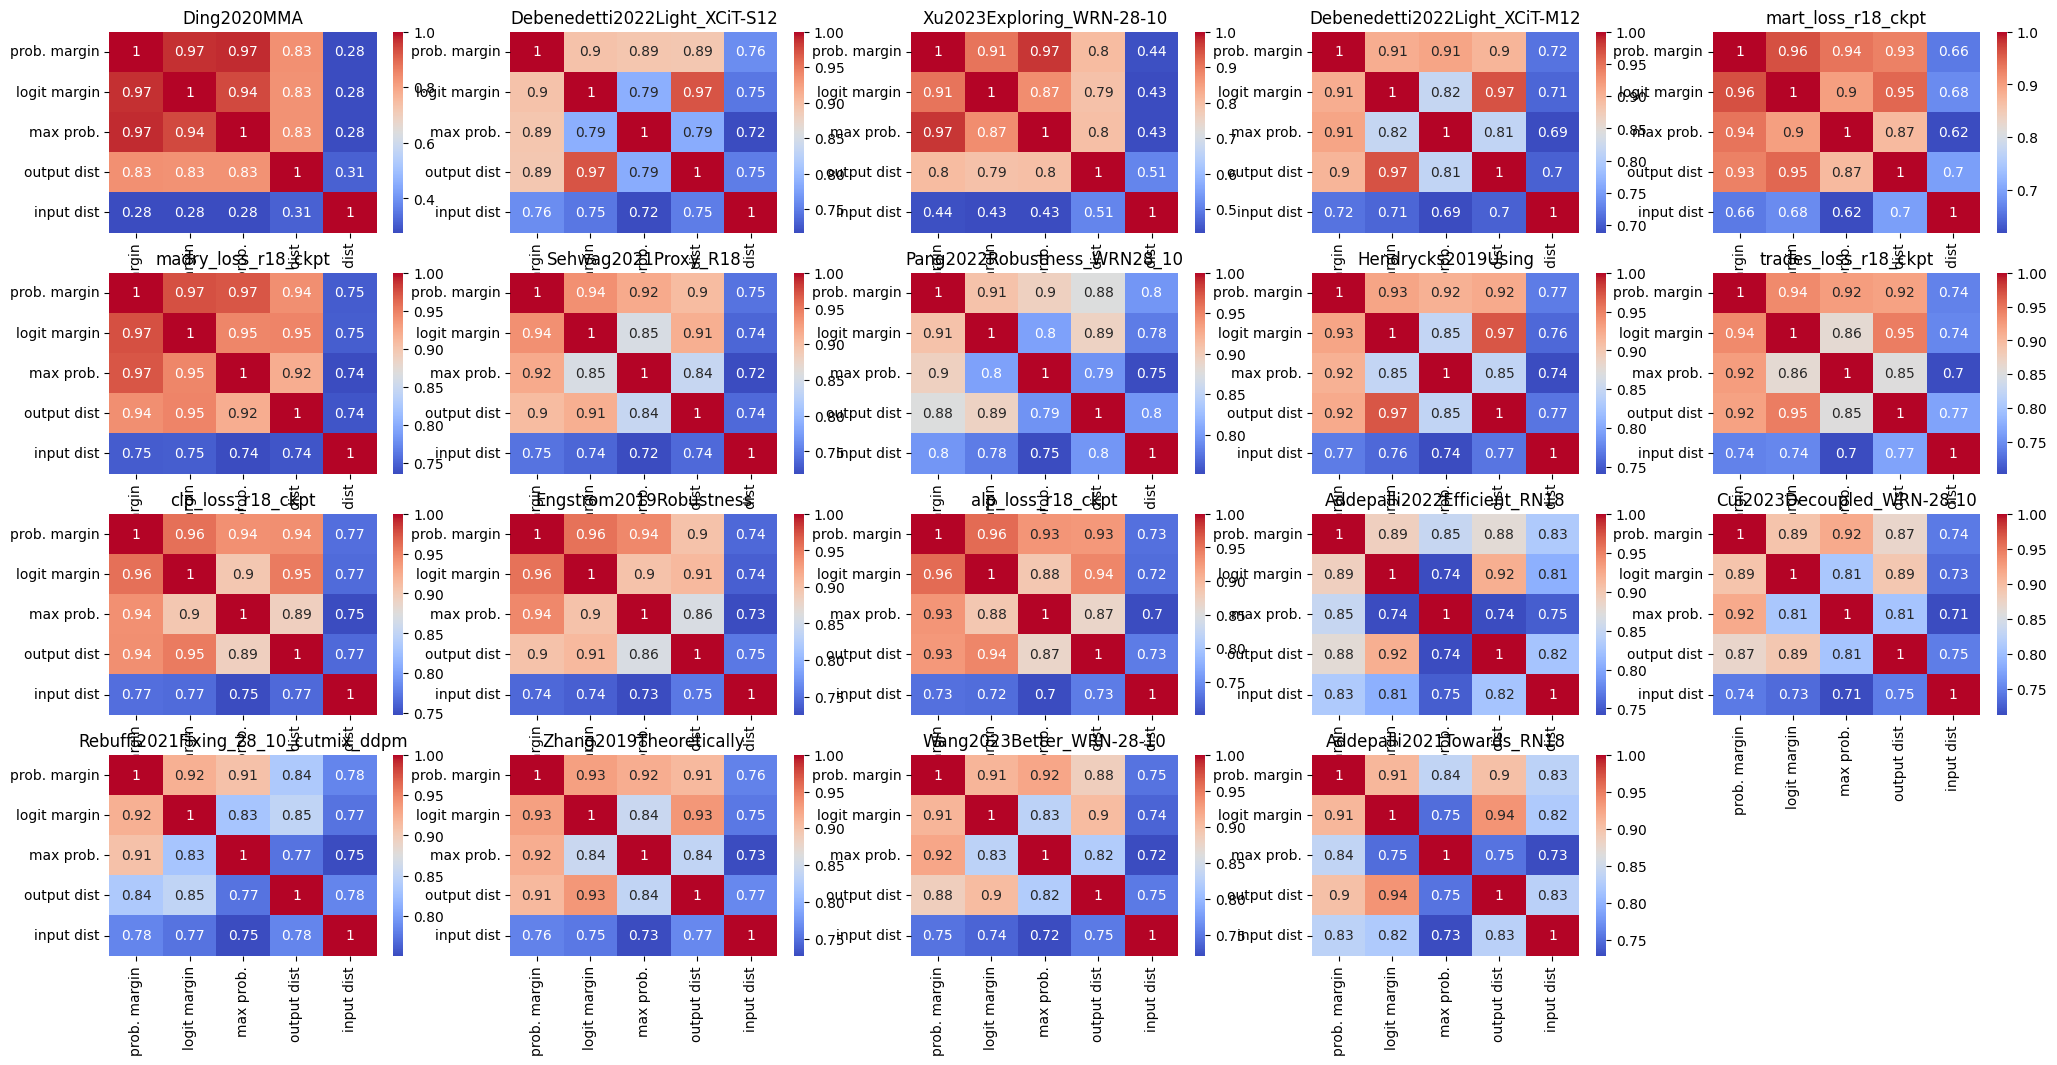

In [71]:
counter=0
plt.figure(figsize=(25,12))
for model in models:
    counter=counter+1
    M = np.zeros((len(xscnames), len(xscnames)))
    # for i in range(len(xscnames)):
    #     for j in range(len(xscnames)):
    for i, sc1 in enumerate(xscnames):
        for j, sc2 in enumerate(xscnames):
            score1 = unfilteredmodelscores[model][sc1]
            score2 = unfilteredmodelscores[model][sc2]
            cor = scipy.stats.kendalltau(score1, score2)[0]
            M[i, j] = abs(cor)
    # Create a heatmap with annotated values
    plt.subplot(4,5,counter)
    sns.heatmap(M, annot=True, fmt='.2g', cmap='coolwarm')

    xpseudos=xscnames
    x=np.arange(len(M))
    plt.xticks(x+1/2, xpseudos , rotation='vertical')
    plt.yticks(x+1/2, xpseudos , rotation='horizontal')

    # Show the plot
    plt.title(model)
plt.show()
#     plt.close()

In [38]:
# correct_predictions = get_correct_predictions(dfs)
eps=8/255
nonrobust_flags = bin_separate(dfs, eps)
xmodels = [model for model in models if robust_accuracies[model]>1]
robres = get_AUCs(xmodels, nonrobust_flags,
                 xscores=unfilteredmodelscores, kdlcors=kdlcors)
# robres['auroc'][model], robres['aupr'][model], robres['fprattpr'][model][1] 

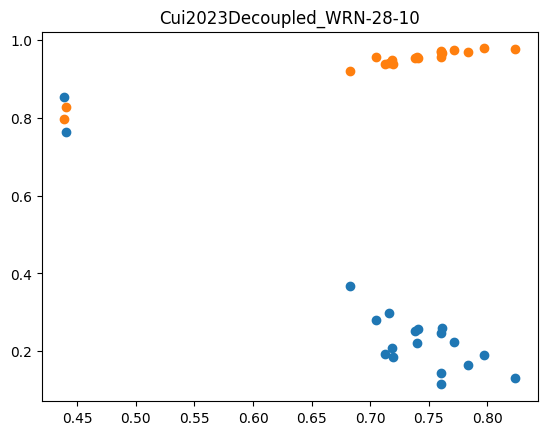

In [41]:
# score='feature dist'
score='logit dist'
aurocs = [robres['aupr'][model][score] for model in xmodels]
fpr95s  = [robres['fprattpr'][model][score][1] for model in xmodels]
u = [kdlcors[model][score] for model in xmodels]
# df = {'model id': np.arange(len(models)),
#       'auroc': aurocs}
# # Create a heatmap with annotated values
# sns.barplot(df, x='model id', y='auroc')
plt.scatter(u, fpr95s)
plt.scatter(u, aurocs)
# xpseudos=xscnames
# x=np.arange(5)
# plt.xticks(x+1/2, xpseudos , rotation='vertical')
# plt.yticks(x+1/2, xpseudos , rotation='horizontal')

# Show the plot
plt.title(model)
plt.show()
plt.close()

In [158]:
for model in models:
    sc2 = "prob. margin"
    posflags=correct_predictions[model]
    score1 = unfilteredmodelscores[model]['input dist']
    score2 = unfilteredmodelscores[model][sc2]
    cor = scipy.stats.kendalltau(score1,score2)[0]
    cor_pos = scipy.stats.kendalltau(score1[posflags], score2[posflags])[0]
    cor_neg = scipy.stats.kendalltau(score1[~posflags], score2[~posflags])[0]
    print(f"cor(pos):{cor_pos:.2f} cor(neg):{cor_neg:.2f} {model}")

cor(pos):0.15 cor(neg):0.44 Ding2020MMA
cor(pos):0.39 cor(neg):0.64 Xu2023Exploring_WRN-28-10
cor(pos):0.71 cor(neg):0.74 Sehwag2021Proxy_R18
cor(pos):0.76 cor(neg):0.84 Pang2022Robustness_WRN28_10
cor(pos):0.74 cor(neg):0.77 Hendrycks2019Using
cor(pos):0.71 cor(neg):0.67 Engstrom2019Robustness
cor(pos):0.80 cor(neg):0.84 Addepalli2022Efficient_RN18
cor(pos):0.71 cor(neg):0.79 Cui2023Decoupled_WRN-28-10
cor(pos):0.76 cor(neg):0.79 Rebuffi2021Fixing_28_10_cutmix_ddpm
cor(pos):0.72 cor(neg):0.78 Zhang2019Theoretically
cor(pos):0.72 cor(neg):0.80 Wang2023Better_WRN-28-10
cor(pos):0.80 cor(neg):0.83 Addepalli2021Towards_RN18


In [617]:
# # model = 'Addepalli2021Towards_RN18'
# for model in models:
#     y = unfilteredmodelscores[model][scnames.index('distance')]
#     y_score = unfilteredmodelscores[model][scnames.index('kl div')]
#     # df = pd.DataFrame({'rep distance': y_score, 'distance': y})
#     # fig=px.scatter(df,x="rep distance", y='distance' , marginal_x="histogram", marginal_y="histogram")
#     # fig.write_html(os.path.join('./',f"{model}_repdist.html"))
#     ratio=y_score/(y)
# #     plt.hist(ratio);
#     print(min(ratio).item(), model)
#     # plt.scatter(np.arange(len(ratio)), ratio)

<a id='cloud'></a>  [top](#top1)

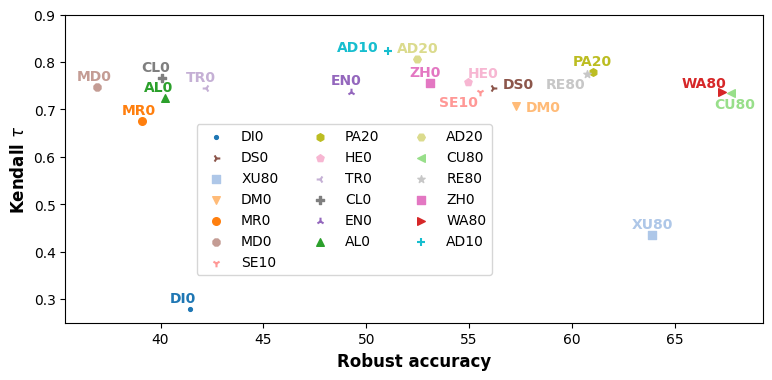

In [29]:
xmodels = models
# scorename='feature dist'
scorename='logit margin'
plt.figure(figsize=(9, 4))
for j in [scorename]:#range(len(scnames)):#
#     cond = lambda x: 'loss' in x or x in ['ResNet18', 'ResNet50']
    cond = lambda x: robust_accuracies[x]>1 #and 'loss' not in x
    xmodels = [model for model in xmodels if cond(model)]
#     print(xmodels)
    scores = [abs(kdlcors[model][j]) for model in xmodels]
    rbaccs = [robust_accuracies[model] for model in xmodels]
    # sz= [clean_accuracies[model] for model in models]
#     lb1=getps(model, code=True, dataset='cifar10').upper()
    for k in range(len(rbaccs)):
        lb1=f"{getps(xmodels[k], code=True, dataset='cifar10').upper()}"
        plt.scatter(rbaccs[k], scores[k], label=lb1, color=colors[xmodels[k]], s=30, marker=markers[xmodels[k]]);
    plt.xlabel('Robust accuracy', fontsize=12, weight='bold');
    plt.ylabel("Kendall $\\tau$", fontsize=12, weight='bold');
    mylist = models #['Ding2020MMA']#, 'ResNet18', 'Debenedetti2022Light_XCiT-S12']
    for k, model in enumerate(xmodels):
        rbac, scor = robust_accuracies[model], abs(kdlcors[model][j])
        code=getps(model, code=True, dataset='cifar10').upper()
#         if code=='SE1':
#             plt.annotate(code, (rbac, scor),
#                         color=colors[model], weight='bold')
        if code in ['SE10', 'RE10']:
            plt.annotate(code, (rbac-2, scor-0.03),
                    color=colors[model], weight='bold')
        elif code=='WA80':
            plt.annotate(code, (rbac-2, scor+0.01),
                    color=colors[model], weight='bold')
        elif code=='CU80':
                plt.annotate(code, (rbac-0.8, scor-0.031),
                        color=colors[model], weight='bold')
        elif code=='RE80':
            plt.annotate(code, (rbac-2, scor-0.03),
                        color=colors[model], weight='bold')
        elif code=='HE0':
#             print(code)
            plt.annotate(code, (rbac, scor+0.01),
                        color=colors[model], weight='bold')
        elif code=='AD10':
            plt.annotate(code, (rbac-2.5, scor),
                        color=colors[model], weight='bold')
        elif code=='DS0':
#             print(code)
            plt.annotate(code, (rbac+0.5, scor+0.0),
                        color=colors[model], weight='bold')
        elif code=='DM0':
#             print(code)
            plt.annotate(code, (rbac+0.5, scor-0.01),
                        color=colors[model], weight='bold')
        else:
#             print(code)
            plt.annotate(code, (rbac-1, scor+0.015),
                        color=colors[model], weight='bold');
plt.legend(loc='center',ncol=3, bbox_to_anchor=(0.4, 0.4))
plt.ylim(0.25, 0.9)
plt.savefig('figures/cloudcorrel.pdf',  bbox_inches='tight');
plt.show()
plt.close()

In [28]:
print(scorename)
m=20
l1 = [" "*m]
l1.extend(['K. tau', 'before', 'acc', 'rob.acc',])
print("\t".join(l1))
sep="-"*65
print(sep)
# dftex = pd.DataFrame(columns=["Model ID", "Accuracy", "Robust Accuracy", "Kendall tau"])
sortscore = [kdlcors[xmodels[i]][j] for i in range(len(xmodels))]
sortedargs =np.argsort(sortscore)
xmodels = [xmodels[i] for i in sortedargs]
##ECE, MCE
ece_mce = dict()
##
for model in xmodels:
    line = getps(model)
    l2 = [line+" "*(m-len(line))]
    jdnet=scorename
    ktau = abs(kdlcors[model][jdnet])
#     print(model, j, ktau)
#     break
    cor = f"{ktau:0.2f}"
    idm = 'dnet'
    cormaxp = f"{abs(kdlcors[model][idm]):0.2f}"
    acc = clean_accuracies[model]
    rob_acc = robust_accuracies[model]
    l2.extend([cor, cormaxp, str(acc), str(rob_acc)])
    ##ECE
#     outpath = get_out_path(model)
#     out = torch.load(outpath, map_location=torch.device('cpu'))
#     pmean = torch.nn.functional.softmax(out, dim=1) 
#     ece, mce = calibration_error(np.array(labels_oneh), np.array(pmean))
#     ece_mce[model] = (ece, mce)
    ##
#     l2.extend([f"{ece:.2f}"])
#     if model in rbenchmodels:
    if kdlcors[model][scorename]>0:
#     if robust_accuracies[model]<1:
        print("\t".join(l2))
        print(sep)
#         new_row = {"Model ID":model, "Accuracy":acc, "Robust Accuracy":rob_acc, "Kendall tau":abs(float(cor))}
#         dftex = dftex.append(new_row, ignore_index=True)
#     #     dftex.to_latex(escape=False)

output dist
                    	K. tau	before	acc	rob.acc
-----------------------------------------------------------------
Ding2020MMA         	0.31	0.01	84.36	41.44
-----------------------------------------------------------------
Xu2023Explori       	0.51	0.01	93.69	63.89
-----------------------------------------------------------------
mart                	0.70	0.00	79.69	39.12
-----------------------------------------------------------------
Debenedetti20       	0.70	0.00	91.3	57.27
-----------------------------------------------------------------
alp                 	0.73	0.00	80.38	40.21
-----------------------------------------------------------------
Sehwag2021Pro       	0.74	0.01	84.59	55.54
-----------------------------------------------------------------
madry               	0.74	0.01	81.85	36.91
-----------------------------------------------------------------
Cui2023Decoup       	0.75	0.00	92.16	67.73
-----------------------------------------------------------------
Debe

In [358]:
print('Kendall tau Correlations')
print()
l1 = [" "*4]
N = len(scnames)
l1.extend([scnames[i][:2] for i in range(N)])
# l1.extend(['acc', 'rob acc'])
print("\t".join(l1))
sep = "-"*100
print(sep)
dftex = pd.DataFrame(columns=["Model ID", "Accuracy", "Robust Accuracy"])
rbacs = [robust_accuracies[models[i]] for i in range(len(models))]
sortedargs =np.argsort(rbacs)
sortedargs = [i for i in sortedargs if robust_accuracies[models[i]]>1]
xmodels = [models[i] for i in sortedargs]
for i in sortedargs: 
    model= models[i]
    if 'loss' in model:# or model in ['ResNet18', 'ResNet50']:
        continue
    l2 = [pseudos[i][:5]+" "*(8-len(pseudos[i]))]
    l2.extend([f"{kdlcors[model][sc]:0.2f}" for sc in scnames])
#     acc = clean_accuracies[model]
#     rob_acc = robust_accuracies[model]
#     l2.extend([str(acc), str(rob_acc)])
    print("\t".join(l2))
    print(sep)
#     new_row = {"Model ID":pseudos[i], "Accuracy":acc, "Robust Accuracy":rob_acc}
#     for j in range(len(scnames)-1):
#         key = f"tau-{scnames[j]}"
#         new_row[key]= abs(float(kdlcors[model][j]))
#     dftex = dftex.append(new_row, ignore_index=True)

Kendall tau Correlations

    	pr	lo	ma	ma	lo	dn	lo	fe	tc	tm	in
----------------------------------------------------------------------------------------------------
Ding2	0.28	0.28	0.28	0.14	0.28	0.57	0.44	0.57	0.29	0.28	1.00
----------------------------------------------------------------------------------------------------
Engst	0.74	0.74	0.73	0.67	0.71	0.01	0.74	0.75	0.70	0.70	1.00
----------------------------------------------------------------------------------------------------
Addep	0.83	0.82	0.73	0.59	0.79	-0.00	0.82	0.77	0.68	0.71	1.00
----------------------------------------------------------------------------------------------------
Addep	0.83	0.81	0.75	0.67	0.78	-0.00	0.78	0.83	0.72	0.76	1.00
----------------------------------------------------------------------------------------------------
Zhang	0.76	0.75	0.73	0.61	0.72	-0.00	0.74	0.78	0.69	0.69	1.00
----------------------------------------------------------------------------------------------------
Hendr	0.77	0.76	0.74	0

In [60]:
# dftex.to_latex(escape=False)

## Binary Classification

**Ouput Scores(Softmax Response/Entropy) in Detection of Non-Robusts Points (distance < epsilon) vs Misclassification Detection** 

In [30]:
def get_correct_predictions():
    y_binary = dict()
    for model in tqdm(models):
        outpath=fget_out_path(model)
    #     outadvpath = get_out_path(model, adv=True)
    #     print(outpath, outadvpath)
        out = torch.load(outpath, map_location=torch.device('cpu'))
#         out_adv = torch.load(outadvpath, map_location=torch.device('cpu'))
        ##
    #     lmscores[model] = calc_lmargin(out)
    #     hscores[model]=calc_entropy(out)
        cpd = out.max(1)[1] == ytargets[model]
        y_binary[model]= cpd.numpy()
    #     print(f"{sum(cpd)/100:.2f}\t{clean_accuracies[model]}\t{model}")
    #     assert sum(cpd)/100 == clean_accuracies[model]
    #     print()
    return y_binary
correct_predictions=get_correct_predictions()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 979.63it/s]


In [31]:
def plot_roc(model, kor, fpr, tpr):
#     plt.figure()
    auroc = calc_auc(fpr, tpr)
    plt.plot(fpr,tpr,label=f'AUC = {auroc:.2f}')
    rbac = robust_accuracies[model]
    acc=clean_accuracies[model]
    plt.title(f"{getps(model)}: acc = {acc:.2f} rob. acc = {rbac:.2f}, tau={abs(kor):.2f}") #(++ {negatives}, -- {positives})')
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.plot([0, 0, 1], [0, 1, 1], "g--", label="perfect level (AUC = 1.0)")
    #plot a dot
    plt.plot(0.2, 0.80, 'bo')
    #
    plt.plot([0], [1], marker="o", markersize=7, markerfacecolor="green", markeredgecolor="green")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    plt.show()
    
def plot_pr(model, kor, precision, recall):
#     plt.figure()
    aupr = calc_auc(recall, precision)
    plt.plot(recall,precision,label=f'AUC = {aupr:.2f}')
    rbac = robust_accuracies[model]
    acc=clean_accuracies[model]
    plt.title(f"{getps(model)}: acc = {acc:.2f} rob. acc = {rbac:.2f}, tau={abs(kor):.2f}") #(++ {negatives}, -- {positives})')
    plt.plot([0, 1], [1, 0], "k--", label="chance level (AUC = 0.5)")
    plt.plot([0, 1, 1], [1, 1, 0], "g--", label="perfect level (AUC = 1.0)")
    #plot a dot
    #
    plt.plot([1], [1], marker="o", markersize=7, markerfacecolor="green", markeredgecolor="green")
    plt.axis("square")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    plt.show()

In [32]:
# from sklearn.metrics import r2_score
def show_pearson_table(xmodels):
    m=15
    l1 = [" "*m]
    l1.extend(['Pearson', 'R2', 'acc', 'rob.acc', 'arch'])
    print("  ".join(l1))
    sep="-"*50
    print(sep)
    dftex = pd.DataFrame(columns=["Model ID", 
                   "Pearson",
                   "R2",
                    "Acc", 
                   "Rob. Acc",
                    "Architecture"])   
    for model in xmodels:
        l2 = [getps(model)+" "*(m-len(getps(model)))]
        valid_indexes = dfs[model]['adv'] == True
#         valid_indexes = np.arange(10000)
        norm = unfilteredmodelscores[model]['input dist'][valid_indexes]
        scores = unfilteredmodelscores[model]['feature dist'][valid_indexes]
        
        cor = scipy.stats.kendalltau(scores, norm)[0]
#         corx=scipy.stats.pearsonr(unfilteredmodelscores[model]['feature dist'],
#                                   unfilteredmodelscores[model]['input dist'])[0]
#         print(cor, corx)
#         assert cor == corx
        pcorvalues[model] = cor
        cor = f"{abs(cor):0.2f}"
        
        slope, intercept, r2, p_value, std_err = scipy.stats.linregress(norm, scores)
        r2values[model] = r2
        r2 = f"{abs(r2):0.2f}"
        
        acc = clean_accuracies[model]
        rob_acc = robust_accuracies[model]
        l2.extend([cor, r2, str(acc), str(rob_acc), architectures[model]])
        
        print("\t".join(l2))
        print(sep)
        new_row = {"Model ID":getps(model, code=True).upper(), 
                   "Pearson":cor,
                   "R2": r2,
                   "Acc":f"{acc:.2f}", 
                   "Rob. Acc":f"{rob_acc:.2f}",
                   "Architecture":architectures[model]
                  }
        dftex = pd.concat([dftex, pd.DataFrame([new_row])], ignore_index=True)
    return dftex

In [33]:
r2values = dict()
pcorvalues=dict()
pmodels=['Addepalli2021Towards_RN18', 'Zhang2019Theoretically']
show_pearson_table(models);

                 Pearson  R2  acc  rob.acc  arch
--------------------------------------------------
Ding2020MMA    	0.57	0.33	84.36	41.44	WideResNet-28-4
--------------------------------------------------
Debenedetti20  	1.00	1.00	90.06	56.14	XCiT-S12
--------------------------------------------------
Xu2023Explori  	0.49	0.63	93.69	63.89	WideResNet-28-10
--------------------------------------------------
Debenedetti20  	1.00	1.00	91.3	57.27	XCiT-M12
--------------------------------------------------
mart           	0.74	0.64	79.69	39.12	ResNet-18
--------------------------------------------------
madry          	0.77	0.80	81.85	36.91	ResNet-18
--------------------------------------------------
Sehwag2021Pro  	0.66	0.45	84.59	55.54	ResNet-18
--------------------------------------------------
Pang2022Robus  	0.66	0.77	88.61	61.04	WideResNet-28-10
--------------------------------------------------
Hendrycks2019  	0.75	0.84	87.11	54.92	WideResNet-28-10
------------------------------------

In [251]:
# xmodels = models
# values = pcorvalues
# cond = lambda x: robust_accuracies[x]>1 #and 'loss' not in x
# xmodels = [model for model in xmodels if cond(model)]
# # scores = [values[model] for model in xmodels]
# scores = [abs(kdlcors[model]['feature dist']) for model in xmodels]
# rbaccs = [robust_accuracies[model] for model in xmodels]
# plt.figure()
# for k in range(len(rbaccs)):
#     lb1=f"{getps(xmodels[k])}"
#     plt.scatter(rbaccs[k], scores[k], label=lb1, color=colors[xmodels[k]], s=5);
# plt.xlabel('Robust accuracy', fontsize=12, weight='bold')
# plt.ylabel("Kendall $\\tau$", fontsize=12, weight='bold');
# mylist = models
# for k, model in enumerate(xmodels):
#     rbac, scor = robust_accuracies[model], values[model]
#     code=getps(model, code=True).upper()
# #     print(code)
#     if code in ['DS']:
#         plt.annotate(code, (rbac-1.7, scor-0.01),
#                 color=colors[model], weight='bold')
#     elif code in ['MR']:
#         plt.annotate(code, (rbac-2, scor),
#                 color=colors[model], weight='bold')
#     elif code in ['AL']:
#         plt.annotate(code, (rbac+0.7, scor-0.01),
#                 color=colors[model], weight='bold')
#     elif code in ['DM']:
#         plt.annotate(code, (rbac+0.25, scor),
#                 color=colors[model], weight='bold')
#     elif code in ['PA2']:
#         plt.annotate(code, (rbac, scor-0.01),
#                 color=colors[model], weight='bold')
#     elif code=='WA8':
#         plt.annotate(code, (rbac-2, scor+0.01),
#                 color=colors[model], weight='bold')
#     elif code=='CU8':
#             plt.annotate(code, (rbac-1, scor-0.03),
#                     color=colors[model], weight='bold')
#     else:
#         plt.annotate(code, (rbac, scor+0.01),
#                     color=colors[model], weight='bold')
# #     plt.title(')
# plt.savefig('figures/pearson.pdf')
# plt.show()
# plt.close()

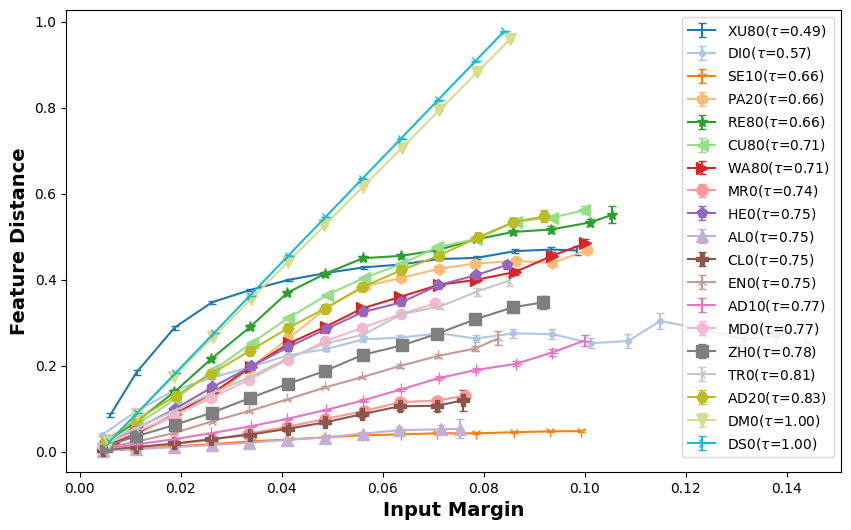

In [34]:
N = 20
N2=10
bin_edges = np.linspace(0, 0.15, N+1)
score='feature dist'
xmodels=[m for m in models if robust_accuracies[m]>1]
sortscore = [kdlcors[xmodels[i]][score] for i in range(len(xmodels))]
sortedargs =np.argsort(sortscore)
xmodels = [xmodels[i] for i in sortedargs]
colors = dict()
for i, m in enumerate(xmodels):
    colors[m] = c[i]
# xmodels=['madry_loss_r18_ckpt']
plt.figure(figsize=(10, 6))
for j, model in enumerate(xmodels[:]):
#     if model.startswith('De'):
#         continue
#     if model not in rbenchmodels:
#     if robust_accuracies[model]<1:
#         continue
#     if 'Ding' in model:
#         continue
    X= unfilteredmodelscores[model]['input dist']
    Y = unfilteredmodelscores[model][score]
    idxs, X =lq2(X)
    Y = Y[idxs]
    Y = (Y-Y.min())/(Y.max()-Y.min())
#     Y = Y/Y.max()
#     print(scipy.stats.kendalltau(X, Y)[0], model)
#     plt.subplot(2,1,1)
    plx(X, Y, M=N, label=getps(model, code=True, dataset='cifar10').upper()+f"($\\tau$={kdlcors[model][score]:.2f})",
       shownumbers=False, color=colors[model], bin_edges=bin_edges, fmt=markers[model])
    # Set the x-axis labels to the bin ranges
#     bin_labels = [f"{bin_edges[i]:.2g} - {bin_edges[i+1]:.2g}" for i in range(N)]
#     plt.xticks(xmeans, bin_labels, rotation=45)
    # Set title and labels for the plot
#     print(f"cor:{cor:.2f} {model}")
#     sizes = [len(data) for data in data_to_plot]
#     for i in range(len(means)):
#         plt.annotate(f"{sizes[i]}", (xmeans[i], means[i]))
# plt.title()
# : $\|x-x'\|_{\\infty}$
# : $\|h_\\psi(x)-h_\\psi(x')\|_{\\infty}$
plt.xlabel("Input Margin", fontsize=14, weight='bold')
plt.ylabel("Feature Distance", fontsize=14, weight='bold')
# plt.axvline(8/255, linestyle='--')
# Display the plot
plt.legend(loc='upper right')#, prop={"size":11})
# plt.axis('equal')
# plt.xlim(0, 0.1)
# x = [i/255 for i in range(1, 40, 4)]
# xticks = [f"{i/255:.2f}" for i in range(1, 40, 4)]
# extraticks=[plt.Text(8/255, 0, "8/255")]
# plt.xticks(list(plt.xticks()[0]) + [8/255], list(plt.xticks()[1])+extraticks, rotation=75 )
# plt.xticks(x, xticks,rotation=75)
plt.savefig('figures/featerrorbar.pdf', bbox_inches='tight')
if False:
    ax= plt.gca()

    # Create a separate figure for the legend
    legend_fig = plt.figure()
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.legend(*ax.get_legend_handles_labels(), loc='center', ncol=2)
    plt.xticks([])
    plt.yticks([])
    # plt.subplot(2,1,2)
    # legend_fig.show()
    legend_fig.savefig('legend_errorbar.pdf')
plt.show()
plt.close()

/Users/nj/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/nj/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


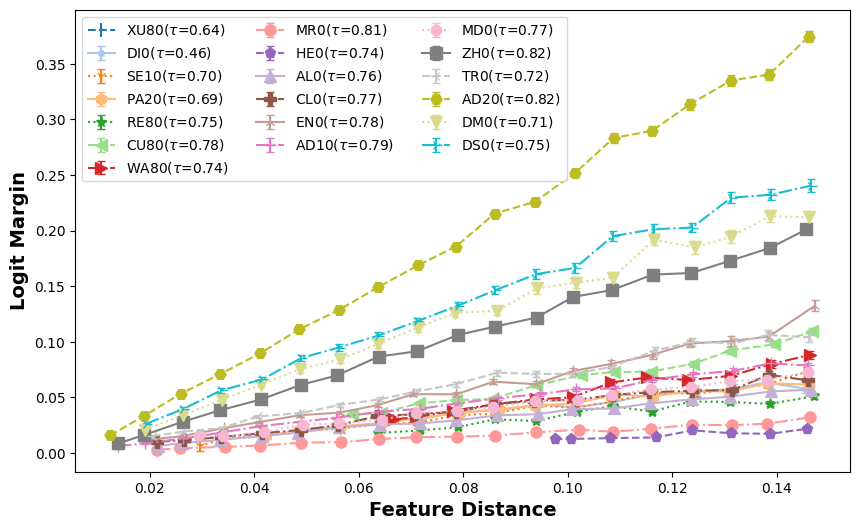

In [35]:
N = 20
N2=10
bin_edges = np.linspace(0, 0.15, N+1)
xmodels=[m for m in models if robust_accuracies[m]>1]
sortscore = [kdlcors[xmodels[i]][score] for i in range(len(xmodels))]
sortedargs =np.argsort(sortscore)
xmodels = [xmodels[i] for i in sortedargs]
colors = dict()
for i, m in enumerate(xmodels):
    colors[m] = c[i]
# xmodels=['madry_loss_r18_ckpt']
plt.figure(figsize=(10, 6))
for j, model in enumerate(xmodels[:]):
#     if model.startswith('De'):
#         continue
#     if model not in rbenchmodels:
#     if robust_accuracies[model]<1:
#         continue
#     if 'Ding' in model:
#         continue
    X = unfilteredmodelscores[model]['feature dist']
    Y = unfilteredmodelscores[model]['logit margin']
    cor = scipy.stats.kendalltau(X, Y)[0]
    idxs, X =lq2(X)
    Y = Y[idxs]
    Y = (Y-Y.min())/(Y.max()-Y.min())
#     X = (X-X.min())/(X.max()-X.min())
#     print(coef.min(), coef.max(), coef.mean())
#     print(scipy.stats.kendalltau(X, Y)[0], model)
#     plt.subplot(2,1,1)
    plx(X, Y, M=N, label=getps(model, code=True).upper()+f"($\\tau$={cor:.2f})",
       shownumbers=False, color=colors[model], bin_edges=bin_edges, fmt=markers[model], ls=linestyles[model])
    # Set the x-axis labels to the bin ranges
#     bin_labels = [f"{bin_edges[i]:.2g} - {bin_edges[i+1]:.2g}" for i in range(N)]
#     plt.xticks(xmeans, bin_labels, rotation=45)
    # Set title and labels for the plot
#     print(f"cor:{cor:.2f} {model}")
#     sizes = [len(data) for data in data_to_plot]
#     for i in range(len(means)):
#         plt.annotate(f"{sizes[i]}", (xmeans[i], means[i]))
# plt.title()
#: $\|z-z'\|_{\\infty}$
#: $\|h_\\psi(x)-h_\\psi(x')\|_{\\infty}$
plt.ylabel("Logit Margin", fontsize=14, weight='bold')
plt.xlabel("Feature Distance", fontsize=14, weight='bold')
# plt.axvline(8/255, linestyle='--')
# Display the plot
plt.legend(loc='upper left', prop={"size": 10}, ncol=3)
# plt.axis('equal')
# plt.xlim(0, 0.1)
# x = [i/255 for i in range(1, 40, 4)]
# xticks = [f"{i/255:.2f}" for i in range(1, 40, 4)]
# extraticks=[plt.Text(8/255, 0, "8/255")]
# plt.xticks(list(plt.xticks()[0]) + [8/255], list(plt.xticks()[1])+extraticks, rotation=75 )
# plt.xticks(x, xticks,rotation=75)
plt.savefig('figures/featvslogit.pdf', bbox_inches='tight')
if False:
    ax= plt.gca()

    # Create a separate figure for the legend
    legend_fig = plt.figure()
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.legend(*ax.get_legend_handles_labels(), loc='center', ncol=2)
    plt.xticks([])
    plt.yticks([])
    # plt.subplot(2,1,2)
    # legend_fig.show()
    legend_fig.savefig('legend_errorbar.pdf')
plt.show()
plt.close()

In [180]:
model='Debenedetti2022Light_XCiT-S12'
indexes
norm = unfilteredmodelscores[model]['input dist']
scores = unfilteredmodelscores[model]['logit margin']
idxs, scores = lq2(scores,5,  95)
norm = norm[idxs]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(norm, scores)
r_value, scipy.stats.pearsonr(norm,scores)

(0.8632467947664674, PearsonRResult(statistic=0.8632467947664687, pvalue=0.0))

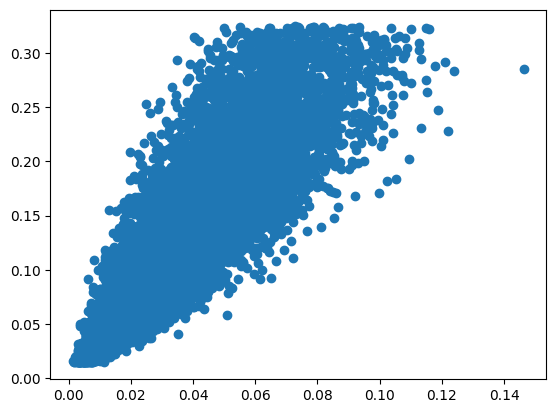

In [181]:
plt.scatter(norm, scores)

## Sanity Check

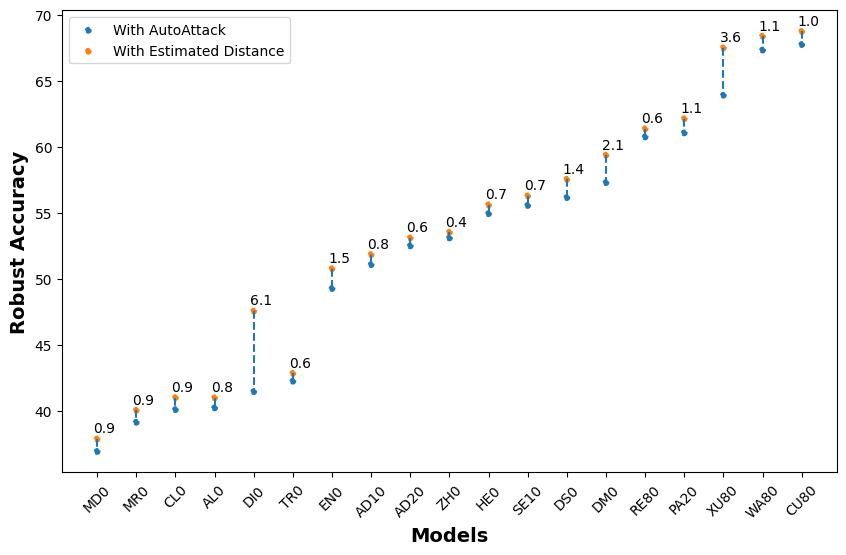

In [63]:
epsilon=8/255
robestimations=dict()
xmodels=models
plt.figure(figsize=(10, 6))
for model in xmodels:
    margins=unfilteredmodelscores[model]['input dist']
    out = torch.load(fget_out_path(model,dataset='cifar10'), map_location='cpu')
    correct_pred = out.max(1)[1].eq(ytargets[model])
    vulnerable = margins <= epsilon
    RobAcc = 100*(correct_pred & ~vulnerable).float().mean()
    robestimations[model] = RobAcc

rbaccs = np.array([robust_accuracies[m] for m in xmodels])
sortedx = np.argsort(rbaccs)
rbaccs=rbaccs[sortedx]
xmodels=[xmodels[i] for i in sortedx]
estimrbaccs=np.array([robestimations[m] for m in xmodels])
plt.scatter(np.arange(len(xmodels)),rbaccs, linestyle='--', label='With AutoAttack', s=15);
plt.scatter(np.arange(len(xmodels)),estimrbaccs, linestyle='--', label='With Estimated Distance', s=15);
for j, model in enumerate(xmodels):
    plt.vlines(j,robestimations[model], robust_accuracies[model], linestyle='--');
    ecart=abs(robestimations[model]-robust_accuracies[model])
#     if j%2 == 0:
#         point = max([robestimations[model].mean(), robust_accuracies[model]])+0.5
#     else:
#         point = min([robestimations[model].mean(), robust_accuracies[model]])-1.3
    point = max([robestimations[model].mean(), robust_accuracies[model]])+0.5
#     point = (robestimations[model].mean() + robust_accuracies[model])/2
#     plt.annotate(f"{ecart.mean():.1f}+/-{ecart.std():.0f}",(j-0.5, point))
    plt.annotate(f"{ecart.mean():.1f}",(j-0.1, point))
    plt.xticks(np.arange(len(sortedx)), [get_code(m) for m in xmodels], rotation=45);
plt.legend();
plt.xlabel('Models', fontsize=14, weight='bold')
plt.ylabel('Robust Accuracy', fontsize=14, weight='bold')
plt.savefig('sanitycheck.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [66]:
ecarts = np.array([abs(robestimations[m]-robust_accuracies[m]) for m in models])
ecarts.mean(), ecarts.max()

(1.352631, 6.1000023)

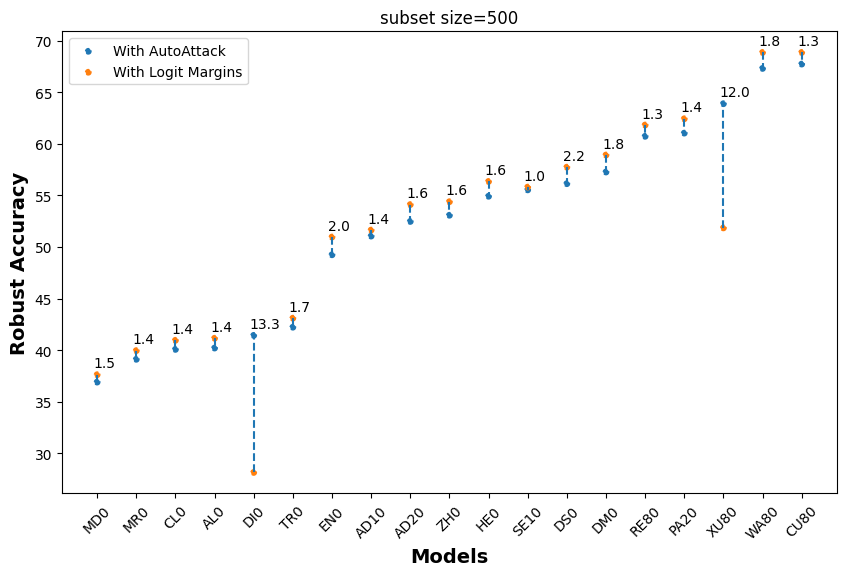

In [77]:
xmodels = [m for m in models if kdlcors[m]['logit margin']>0.]
plt.figure(figsize=(10, 6))
for n_subset in [500]:
    robestimations = dict()
    corestimations = dict()
    for j, model in enumerate(xmodels):
        margins=unfilteredmodelscores[model]['input dist'] 
        out = torch.load(fget_out_path(model,dataset='cifar10'), map_location='cpu')
        robestims=[]
        corestims=[]
        for k in range(10):
            robestim, cor = SampleEfficientRobustAccuracy(margins, logits=out,
                                              labels=ytargets[model],
                                              epsilon=8/255,
                                              n_subset=n_subset)
            robestims.append(robestim)
            corestims.append(cor)
        robestims=np.array(robestims)
        corestims=np.array(corestims)
        robestimations[model]=robestims
        corestimations[model]=corestims
    ####
    ####
    rbaccs = np.array([robust_accuracies[m] for m in xmodels])
    sortedx = np.argsort(rbaccs)
    rbaccs=rbaccs[sortedx]
    xmodels=[xmodels[i] for i in sortedx]
    estimrbaccs=np.array([robestimations[m].mean() for m in xmodels])
    plt.scatter(np.arange(len(xmodels)),rbaccs, linestyle='--', label='With AutoAttack', s=15);
    plt.scatter(np.arange(len(xmodels)),estimrbaccs, linestyle='--', label='With Logit Margins', s=15);
    for j, model in enumerate(xmodels):
        plt.vlines(j,robestimations[model].mean(), robust_accuracies[model], linestyle='--');
        ecart=abs(robestimations[model]-robust_accuracies[model])
    #     std = abs(robestimations[model]-robust_accuracies[model]).std()
#         if j%2 == 0:
#             point = max([robestimations[model].mean(), robust_accuracies[model]])+0.7
#         else:
#             point = min([robestimations[model].mean(), robust_accuracies[model]])-2
        point = max([robestimations[model].mean(), robust_accuracies[model]])+0.7
    #     point = (robestimations[model].mean() + robust_accuracies[model])/2
    #     plt.annotate(f"{ecart.mean():.1f}+/-{ecart.std():.0f}",(j-0.5, point))
        plt.annotate(f"{ecart.mean():.1f}",(j-0.1, point))
        plt.xticks(np.arange(len(sortedx)), [get_code(m) for m in xmodels], rotation=45);
    plt.legend();
    plt.title(f"subset size={n_subset}")
    plt.xlabel('Models', fontsize=14, weight='bold')
    plt.ylabel('Robust Accuracy', fontsize=14, weight='bold')
    if n_subset==500:
        plt.savefig('robustestim.pdf', bbox_inches='tight')
#     print(scipy.stats.kendalltau(rbaccs, estimrbaccs)[0])
    plt.show()
    plt.close()

In [95]:
##### xmodels = [m for m in models if kdlcors[m]['logit margin']>0.5]
robestimations = dict()
corestimations = dict()
for model in xmodels:
    robestimations[model]=[]
    corestimations[model]=[]
varsubset = [50, 100, 200, 300, 500, 1000, 5000]
for n_subset in tqdm(varsubset):
    for j, model in enumerate(xmodels):
#         if getps(model, code=True, dataset='cifar10')!='AD20':
#             continue
        margins=unfilteredmodelscores[model]['input dist'] 
        out = torch.load(fget_out_path(model,dataset='cifar10'), map_location='cpu')
        robestims=[]
        corestims=[]
        for k in range(10):
            robestim, cor = SampleEfficientRobustAccuracy(margins, logits=out,
                                              labels=ytargets[model],
                                              epsilon=8/255,
                                              n_subset=n_subset)
            robestims.append(robestim)
            corestims.append(cor)
        robestims=np.array(robestims)
        corestims=np.array(corestims)
        robestimations[model].append(robestims)
        corestimations[model].append(corestims)
    ####
####

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.55it/s]


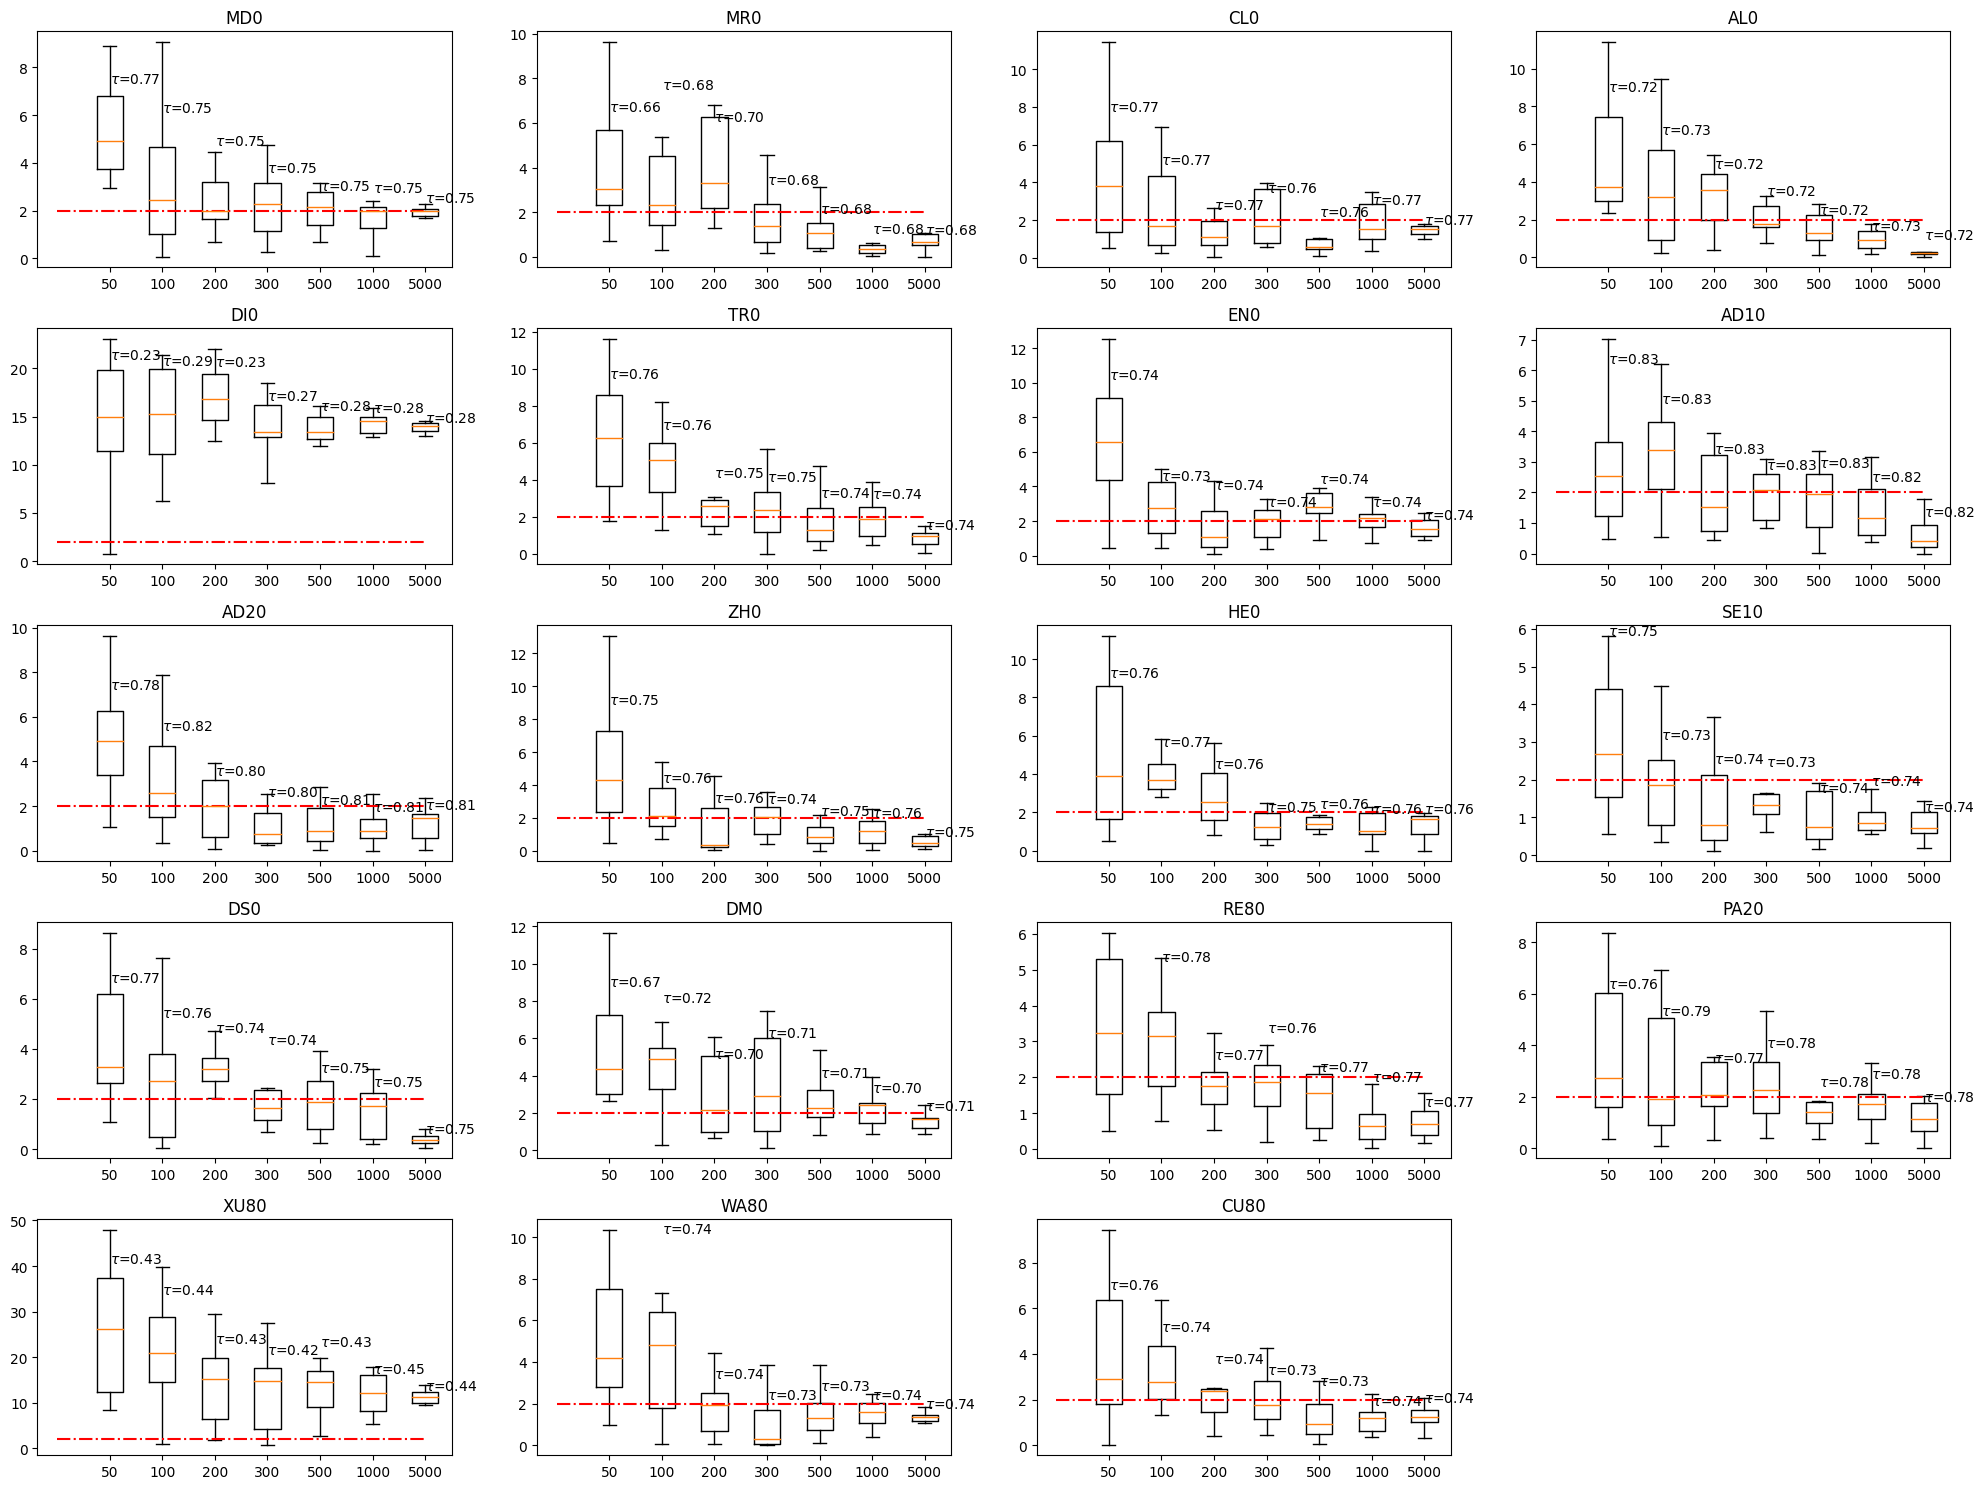

In [97]:
num_rows, num_cols = 5, 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15))
for i, model in enumerate(xmodels):
#     if getps(model, code=True, dataset='cifar10')!='AD20':
#         continue
    row, col = divmod(i, num_cols)
    ecarts=[abs(robestimations[model][i] - robust_accuracies[model]) for i in range(len(varsubset))]
    axs[row, col].boxplot(ecarts, showfliers=False)
    axs[row, col].set_xticks(np.arange(1, len(varsubset)+1),varsubset, rotation=0);
    axs[row, col].set_title(getps(model, code=True, dataset='cifar10'));
    for j, n_subset in enumerate(varsubset):
        cor=corestimations[model][j].mean()
        j2 = ecarts[j].mean()+ ecarts[j].std()
        axs[row, col].annotate(f"$\\tau$={cor:.2f}", (j+1,j2))
    axs[row, col].hlines(2, 0, len(varsubset), linestyle='-.', color='red')
axs[4,3].axis('off')
plt.tight_layout()
plt.savefig('varsampleefficiency.pdf', bbox_inches='tight')
plt.show()

In [709]:
# for model in xmodels[:]:
#     ecarts=[abs(robestimations[model][i] - robust_accuracies[model]) for i in range(len(varsubset))]
#     plt.boxplot(ecarts, showfliers=False)
#     plt.xticks(np.arange(1, len(varsubset)+1),varsubset, rotation=0);
#     plt.title(get_code(model));
#     plt.show()
#     plt.close()

In [363]:
def show_table(xmodels, scorename, kdcors, aucres):
    print(scorename)
    m=10
    l1 = [" "*m]
    # l1.extend(['corr.', 'auc','acc', 'rob.acc'])
    l1.extend(['K. tau', 'auroc', 'aupr', 'fpr@95', 'acc', 'rob.acc', 'arch'])
    print("\t".join(l1))
    sep="-"*60
    print(sep)
    dftex = pd.DataFrame(columns=["Model ID", 
                   "Kendall tau",
                   "AUROC",
                   "AUPR",
                   "FPR95",
                   "Acc", 
                   "Rob. Acc",
                    "Architecture"])   
    for model in xmodels:
#         if 'loss' in model:# or model in ['ResNet18', 'ResNet50']:
#             continue
        l2 = [getps(model)+" "*(m-len(getps(model)))]
        cor = f"{abs(kdcors[model][scorename]):0.2f}"
#         print(aucres['auroc'][model][scorename])
        auroc = f"{100*aucres['auroc'][model][scorename]:0.2f}"
        aupr = f"{100*aucres['aupr'][model][scorename]:0.2f}"
        fpr95 = f"{100*aucres['fprattpr'][model][scorename][0]:0.2f}"
        acc = clean_accuracies[model]
        rob_acc = robust_accuracies[model]
    #     l2.extend([cor, aucscore, str(acc), str(rob_acc)])
        l2.extend([cor, auroc, aupr, fpr95, str(acc), str(rob_acc), architectures[model]])
    #     print(l2)
        print("\t".join(l2))
        print(sep)
        new_row = {"Model ID":getps(model, code=True).upper(), 
                   "Kendall tau":cor,
                   "AUROC":auroc,
                   "AUPR":aupr,
                   "FPR95":fpr95,
                   "Acc":f"{acc:.2f}", 
                   "Rob. Acc":f"{rob_acc:.2f}",
                   "Architecture":architectures[model]
                  }
        dftex = pd.concat([dftex, pd.DataFrame([new_row])], ignore_index=True)
#         dftex.to_latex(escape=False)
    return dftex

In [364]:
# correct_predictions = get_correct_predictions(dfs)
eps=8/255
nonrobust_flags = bin_separate(dfs, eps)
xmodels = [model for model in models if robust_accuracies[model]>1]
robres = get_AUCs(xmodels, nonrobust_flags,
                 xscores=unfilteredmodelscores, kdlcors=kdlcors)
# robres['auroc'][model], robres['aupr'][model], robres['fprattpr'][model][1] 

In [405]:
lim=0
scorename='logit margin'
rbacs = [robust_accuracies[models[i]] for i in range(len(models))]
#     lim = 1#-1 if misD else 1
sortedargs = np.argsort([kdlcors[models[i]][scorename] for i in range(len(models))])
#     sortedargs = np.argsort([robust_accuracies[model] for model in models])
xmodels = [models[i] for i in sortedargs if robust_accuracies[models[i]]>lim]
# scorename='dnet'
dftex = show_table(xmodels, scorename, kdlcors, robres)
dftex.to_latex(escape=False)

logit margin
          	K. tau	auroc	aupr	fpr@95	acc	rob.acc	arch
------------------------------------------------------------
Ding2020MMA	0.28	67.49	70.91	82.56	84.36	41.44	WideResNet-28-4
------------------------------------------------------------
Xu2023Explori	0.43	83.30	80.50	83.42	93.69	63.89	WideResNet-28-10
------------------------------------------------------------
mart      	0.68	92.95	94.92	29.76	79.69	39.12	ResNet-18
------------------------------------------------------------
Debenedetti20	0.71	94.31	93.20	32.76	91.3	57.27	XCiT-M12
------------------------------------------------------------
alp       	0.72	94.67	95.98	24.93	80.38	40.21	ResNet-18
------------------------------------------------------------
Cui2023Decoup	0.73	96.87	94.42	17.90	92.16	67.73	WideResNet-28-10
------------------------------------------------------------
Wang2023Bette	0.74	96.82	94.33	17.60	92.44	67.31	WideResNet-28-10
------------------------------------------------------------
Sehwag2021Pro	0.

'\\begin{tabular}{lllllllll}\n\\toprule\n & Model ID & Kendall tau & AUROC & AUPR & FPR95 & Acc & Rob. Acc & Architecture \\\\\n\\midrule\n0 & DI0 & 0.28 & 67.49 & 70.91 & 82.56 & 84.36 & 41.44 & WideResNet-28-4 \\\\\n1 & XU80 & 0.43 & 83.30 & 80.50 & 83.42 & 93.69 & 63.89 & WideResNet-28-10 \\\\\n2 & MR0 & 0.68 & 92.95 & 94.92 & 29.76 & 79.69 & 39.12 & ResNet-18 \\\\\n3 & DM0 & 0.71 & 94.31 & 93.20 & 32.76 & 91.30 & 57.27 & XCiT-M12 \\\\\n4 & AL0 & 0.72 & 94.67 & 95.98 & 24.93 & 80.38 & 40.21 & ResNet-18 \\\\\n5 & CU80 & 0.73 & 96.87 & 94.42 & 17.90 & 92.16 & 67.73 & WideResNet-28-10 \\\\\n6 & WA80 & 0.74 & 96.82 & 94.33 & 17.60 & 92.44 & 67.31 & WideResNet-28-10 \\\\\n7 & SE10 & 0.74 & 96.03 & 94.66 & 19.13 & 84.59 & 55.54 & ResNet-18 \\\\\n8 & EN0 & 0.74 & 95.16 & 95.07 & 24.10 & 87.03 & 49.25 & ResNet-50 \\\\\n9 & TR0 & 0.74 & 94.63 & 96.13 & 30.93 & 80.72 & 42.23 & ResNet-18 \\\\\n10 & DS0 & 0.75 & 95.80 & 95.08 & 24.65 & 90.06 & 56.14 & XCiT-S12 \\\\\n11 & MD0 & 0.75 & 95.36 & 97

In [366]:
for model in xmodels:
    if robust_accuracies[model]<1:
        continue
    print(getps(model, code=True).upper(), model)

DI0 Ding2020MMA
XU80 Xu2023Exploring_WRN-28-10
MR0 mart_loss_r18_ckpt
DM0 Debenedetti2022Light_XCiT-M12
AL0 alp_loss_r18_ckpt
CU80 Cui2023Decoupled_WRN-28-10
WA80 Wang2023Better_WRN-28-10
SE10 Sehwag2021Proxy_R18
EN0 Engstrom2019Robustness
TR0 trades_loss_r18_ckpt
DS0 Debenedetti2022Light_XCiT-S12
MD0 madry_loss_r18_ckpt
ZH0 Zhang2019Theoretically
HE0 Hendrycks2019Using
CL0 clp_loss_r18_ckpt
RE80 Rebuffi2021Fixing_28_10_cutmix_ddpm
PA20 Pang2022Robustness_WRN28_10
AD20 Addepalli2022Efficient_RN18
AD10 Addepalli2021Towards_RN18


In [303]:
misDres = get_AUCs(xmodels, correct_predictions, formisD=True, 
                  xscores=unfilteredmodelscores, kdlcors=kdlcors)

<a id='rocvar1'></a>  [top](#top1)

In [434]:
def get_ratio(binvalues):
    y_onehot_full = np.array(binvalues).astype(int)
    negatives = (y_onehot_full==0).sum()
    positives = len(y_onehot_full)-negatives
    ratio = negatives/(positives+negatives)
#     assert negatives!=0 and positives!=0
    return ratio

In [435]:
def fillaucscores(model, epsilons=None):
    # model = 'ce_loss_r18_ckpt'
#     regr = classifiers[model]
    aurocmodels[model] = []
    auprmodels[model] = []
    ratiomodels[model] = []
    fpr95models[model] = []
    fprtprvalues[model] = []
    precrecvalues[model]=[]
    xepsilons = []
    for epsilon in tqdm(epsilons):
    #     print(epsilon)
        xnonrobust_flags = bin_separate(dfs, epsilon)
        binvalues  = xnonrobust_flags[model]
        r = get_ratio(binvalues)
        if r<0.001 or r>0.999:
            continue
        xepsilons.append(epsilon)
#         out = torch.load(get_out_path(model), map_location=torch.device('cpu'))
#         scores=regr.predict(out)
        scores = unfilteredmodelscores[model]['output dist']
        xres = xget_AUCs(binvalues, -scores)
        aurocmodels[model].append(xres['auroc'])
        auprmodels[model].append(xres['aupr'])
        ratiomodels[model].append(xres['ratio'])
        fpr95models[model].append(xres['fprattpr'])
        fprtprvalues[model].append(xres['fpr_tpr'])
        precrecvalues[model].append(xres['prec_rec'])
    return xepsilons

<a id='epsvar'>.</a>  [Back to Dnet](#dnet)

In [436]:
# for model in models:
#     print(np.median(unfilteredmodelscores[model]['input dist']))

<a id='rocvar2'></a>  [top](#top1)

In [437]:
eps=8/255

  0%|          | 0/6 [00:00<?, ?it/s]

0 1


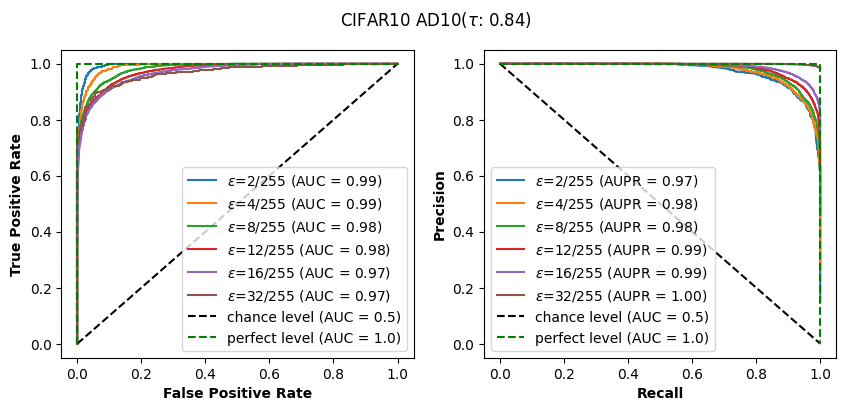

In [506]:
def xplot_roc(label, fpr, tpr):
    auroc = calc_auc(fpr, tpr)
    plt.plot(fpr,tpr, label=label+f" (AUC = {auroc:.2f})")
    return auroc
def plot_varroc(xepsilons, model, aurocs, fprtprvalues):
    for k, epsilon in enumerate(xepsilons):
        fpr, tpr = fprtprvalues[model][k]
        auroc = xplot_roc(labels[k], fpr, tpr)
        aurocs[k]=auroc
###########
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.plot([0, 0, 1], [0, 1, 1], "g--", label="perfect level (AUC = 1.0)")
    plt.xlabel("False Positive Rate", fontsize=10, weight='bold')
    plt.ylabel("True Positive Rate", fontsize=10, weight='bold')
    plt.legend()
    fig = plt.gcf()
#     fig.set_size_inches(7, 6)

def xplot_pr(label, pr, rc):
    aupr = calc_auc(rc, pr)
    plt.plot(rc,pr, label=label+f" (AUPR = {aupr:.2f})")
    return aupr
def plot_prvar(xepsilons, model, auprs, precrecvalues):
    for k, epsilon in enumerate(xepsilons):
        pr, rc = precrecvalues[model][k]
        aupr = xplot_pr(labels[k], pr, rc)
        auprs[k]=aupr
###########
    plt.plot([0, 1], [1, 0], "k--", label="chance level (AUC = 0.5)")
    plt.plot([0, 1, 1], [1, 1, 0], "g--", label="perfect level (AUC = 1.0)")
    plt.xlabel("Recall", fontsize=10, weight='bold')
    plt.ylabel("Precision", fontsize=10, weight='bold')
    plt.legend()
    fig = plt.gcf()
    
aurocmodels=dict()
auprmodels=dict()
ratiomodels=dict()
fpr95models=dict()
fprtprvalues = dict()
precrecvalues=dict()
epsilons1= np.arange(0., 32/255, 0.001)
# epsilons2 = [i/255 for i in range(2,33, 2)]
epsilons = [2/255, 4/255, 8/255, 12/255, 16/255, 32/255]
labels = [f"2/255", "4/255", "8/255", "12/255", "16/255", "32/255"]
labels = [f"$\\epsilon$="+e for e in labels]
jmp='output dist'
# xmodels = [model for model in models if kdlcors[model][jmp]>.7]
xmodels=['Addepalli2021Towards_RN18']#, 'Debenedetti2022Light_XCiT-S12']
counter=0
for model in xmodels:
#     plt.figure(figsize=(10, 4))
    xepsilons = fillaucscores(model, epsilons)
#     print(xepsilons)
#     plt.figure(figsize=(8,7))
    aurocs = np.zeros_like(xepsilons)
    auprs = np.zeros_like(xepsilons)
    print(counter, counter+1)
    plt.subplot(1,2,1)
    plot_varroc(xepsilons, model, aurocs, fprtprvalues)
    plt.suptitle("CIFAR10 "+getps(model, code=True).upper()+f"($\\tau$: {kdlcors[model][jmp]:.2f})")
    plt.subplot(1,2,2)
    plot_prvar(xepsilons, model, auprs, precrecvalues)
#     plt.title("CIFAR10 "+getps(model, code=True).upper()+f"($\\tau$: {kdlcors[model][jmp]:.2f})")
    counter+=1
    fig = plt.gcf()
    fig.set_size_inches(10, 4)
######    
    plt.savefig(f"figures/rocvariationc_{counter}.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

  0%|          | 0/6 [00:00<?, ?it/s]

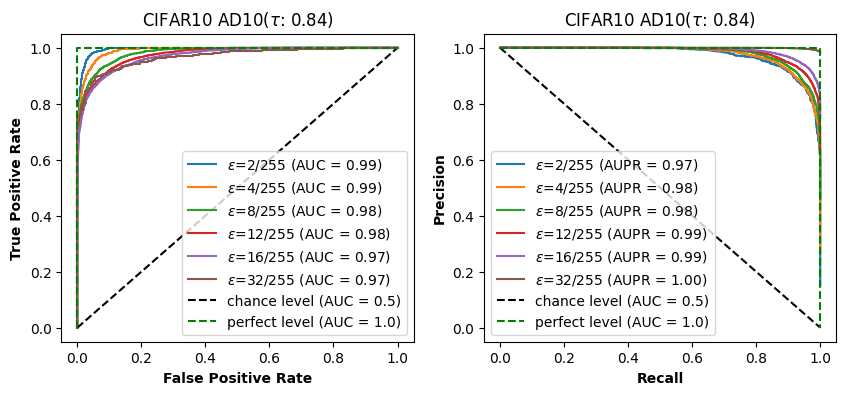

In [445]:
def xplot_roc(label, fpr, tpr):
    auroc = calc_auc(fpr, tpr)
    plt.plot(fpr,tpr, label=label+f" (AUC = {auroc:.2f})")
    return auroc
def plot_varroc(xepsilons, model, aurocs, fprtprvalues):
    for k, epsilon in enumerate(xepsilons):
        fpr, tpr = fprtprvalues[model][k]
        auroc = xplot_roc(labels[k], fpr, tpr)
        aurocs[k]=auroc
###########
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.plot([0, 0, 1], [0, 1, 1], "g--", label="perfect level (AUC = 1.0)")
    plt.xlabel("False Positive Rate", fontsize=10, weight='bold')
    plt.ylabel("True Positive Rate", fontsize=10, weight='bold')
    plt.legend()
#     fig = plt.gcf()
#     fig.set_size_inches(7, 7)

def xplot_pr(label, pr, rc):
    aupr = calc_auc(rc, pr)
    plt.plot(rc,pr, label=label+f" (AUPR = {aupr:.2f})")
    return aupr
def plot_prvar(xepsilons, model, auprs, precrecvalues):
    for k, epsilon in enumerate(xepsilons):
        pr, rc = precrecvalues[model][k]
        aupr = xplot_pr(labels[k], pr, rc)
        auprs[k]=aupr
###########
    plt.plot([0, 1], [1, 0], "k--", label="chance level (AUC = 0.5)")
    plt.plot([0, 1, 1], [1, 1, 0], "g--", label="perfect level (AUC = 1.0)")
    plt.xlabel("Recall", fontsize=10, weight='bold')
    plt.ylabel("Precision", fontsize=10, weight='bold')
    plt.legend()
#     fig = plt.gcf()
    
aurocmodels=dict()
auprmodels=dict()
ratiomodels=dict()
fpr95models=dict()
fprtprvalues = dict()
precrecvalues=dict()
epsilons1= np.arange(0., 32/255, 0.001)
# epsilons2 = [i/255 for i in range(2,33, 2)]
epsilons = [2/255, 4/255, 8/255, 12/255, 16/255, 32/255]
labels = [f"2/255", "4/255", "8/255", "12/255", "16/255", "32/255"]
labels = [f"$\\epsilon$="+e for e in labels]
jmp='output dist'
# xmodels = [model for model in models if kdlcors[model][jmp]>.7]
xmodels=["Addepalli2021Towards_RN18"]#'Addepalli2021Towards_PARN18']#, 'Hendrycks2019Using']
# xmodels = [model for model in models if robust_accuracies[model]>1]
# xmodel = xmodels[0]
# plt.rc('text', usetex=False)
counter=0
for model in xmodels:
#     plt.figure(figsize=(11, 4))
    xepsilons = fillaucscores(model, epsilons)
#     print(xepsilons)
#     plt.figure(figsize=(8,7))
    aurocs = np.zeros_like(xepsilons)
    auprs = np.zeros_like(xepsilons)
#     print(counter, counter+1)
    plt.subplot(1,2,1)
    plot_varroc(xepsilons, model, aurocs, fprtprvalues)
    plt.title("CIFAR10 "+getps(model, code=True, dataset='cifar10').upper()+f"($\\tau$: {kdlcors[model][jmp]:.2f})")
    plt.subplot(1,2,2)
    plot_prvar(xepsilons, model, auprs, precrecvalues)
    plt.title("CIFAR10 "+getps(model, code=True, dataset='cifar10').upper()+f"($\\tau$: {kdlcors[model][jmp]:.2f})")
    counter+=1
    fig = plt.gcf()
    fig.set_size_inches(10, 4)
######    
    plt.savefig(f"figures/rocvariationc_{counter}.pdf")
    plt.show()
    plt.close()

  0%|          | 0/16 [00:00<?, ?it/s]

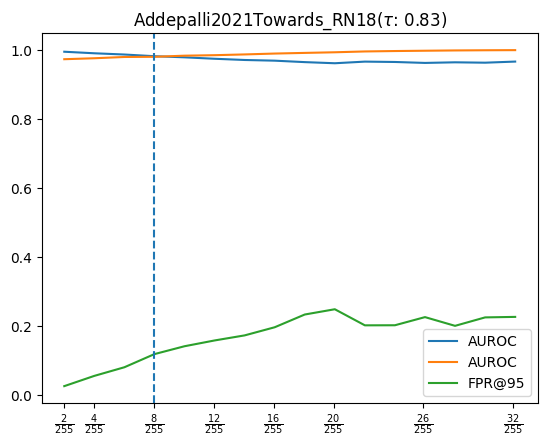

In [324]:
aurocmodels=dict()
auprmodels=dict()
ratiomodels=dict()
fpr95models=dict()
fprtprvalues = dict()
precrecvalues = dict()
epsilons1= np.arange(0., 32/255, 0.001)
epsilons2 = [i/255 for i in range(2,33, 2)]
jmp='output dist'
# xmodels = [model for model in models if kdlcors[model][jmp]>.7]
xmodels=['Addepalli2021Towards_RN18']
# xmodels = [model for model in models if robust_accuracies[model]>1]
# xmodel = xmodels[0]
# plt.rc('text', usetex=False)
for model in xmodels:
    epsilons = epsilons1 if robust_accuracies[model]<1 else epsilons2
    xepsilons = fillaucscores(model, epsilons)
    plt.figure()
    y = [aurocmodels[model][i] for i in range(len(xepsilons))]
    y2 = [auprmodels[model][i] for i in range(len(xepsilons))]
    y3 = [fpr95models[model][i][0] for i in range(len(xepsilons))]
    plt.plot(xepsilons, y, label='AUROC')
    plt.plot(xepsilons, y2, label='AUROC')
    plt.plot(xepsilons, y3, label='FPR@95')
#     avgdist = np.median(extraunfilteredscores[model][-1])
#     print(avgdist)
#     plt.axvline(avgdist, linestyle='--')
    if robust_accuracies[model]>1:
        plt.axvline(eps, linestyle='--')
#         plt.axhline(robust_accuracies[model]/100)
#         xticks = ["$\\frac{}{255}$" for i in range(1, 6)]
        xticks=["$\\frac{2}{255}$", "$\\frac{4}{255}$", "$\\frac{8}{255}$", 
                "$\\frac{12}{255}$", "$\\frac{16}{255}$", "$\\frac{20}{255}$", "$\\frac{26}{255}$", "$\\frac{32}{255}$"]
        x = [2/256, 4/256, 8/256, 12/256, 16/256, 20/256, 26/256, 32/256]
        plt.xticks(x, xticks)
#     r = [ratiomodels[model][i] for i in range(len(xepsilons))]
#     plt.plot(xepsilons, r, '--')
#     plt.axhline(1.0,color='r')
    plt.legend()
    plt.title(model+f"($\\tau$: {kdlcors[model][jmp]:.2f})")
    plt.savefig('figures/aucvariation.pdf')
    plt.show()
    plt.close()

[top](#epsvar)

In [292]:
score='output dist'
yroc = np.array([robres['auroc'][m][score] for m in models])
ypr = np.array([robres['aupr'][m][score] for m in models])
yfpr = np.array([robres['fprattpr'][m][score][0] for m in models])
x = np.array([kdlcors[m]['output dist'] for m in models])
# idxs, x = lq2(x)
# yroc=yroc[idxs]
# ypr=ypr[idxs]
# yfpr=yfpr[idxs]
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.scatter(x, yfpr)
plt.subplot(1,3,2)
plt.scatter(x, yroc)
plt.subplot(1,3,3)
plt.scatter(x, ypr)

NameError: name 'robres' is not defined

In [625]:
scorename='dnet'
show_table(xmodels, scorename, kdlcors, robres)
# dftex.to_latex(escape=False)

dnet
                    	K. tau	auroc	aupr	fpr@95	acc	rob.acc
----------------------------------------------------------------------
mma                 	0.005	94.09	96.20	30.13	82.94	37.28
----------------------------------------------------------------------
madry               	0.011	93.44	95.45	30.69	81.85	36.91
----------------------------------------------------------------------
clp                 	0.012	93.97	95.29	25.69	81.12	40.08
----------------------------------------------------------------------
Rebuffi2021Fi       	0.008	98.01	96.62	10.42	87.33	60.73
----------------------------------------------------------------------
Engstrom2019R       	0.007	95.56	95.43	22.58	87.03	49.25
----------------------------------------------------------------------
Hendrycks2019       	0.002	97.52	96.86	12.98	87.11	54.92
----------------------------------------------------------------------
Sehwag2021Pro       	0.009	89.52	86.07	42.26	84.59	55.54
-----------------------------------------

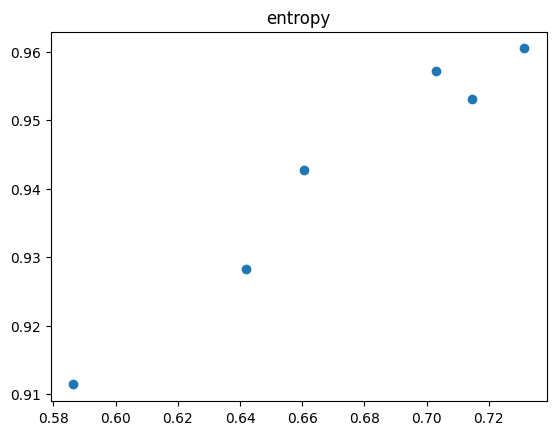

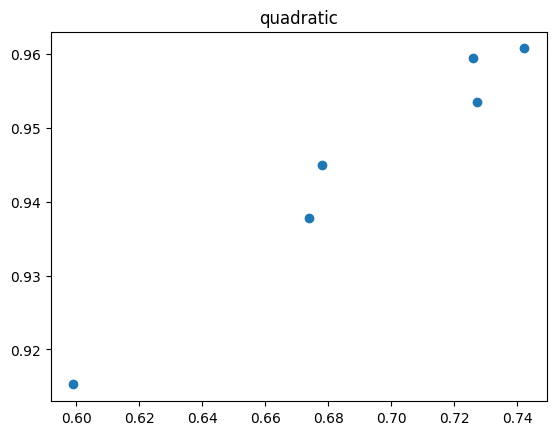

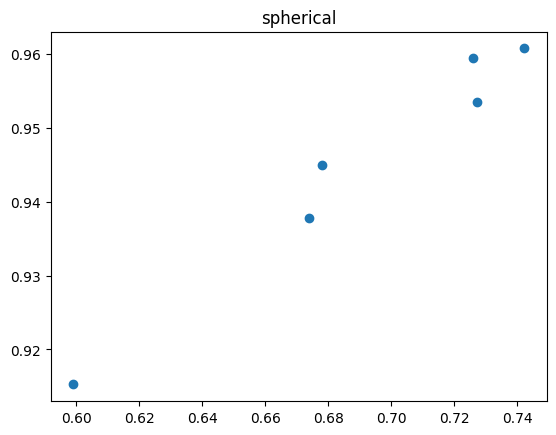

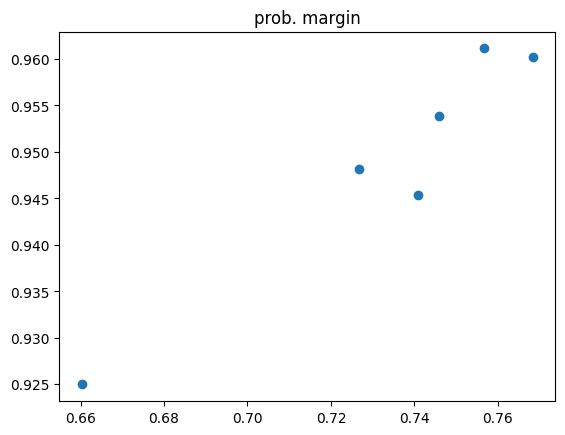

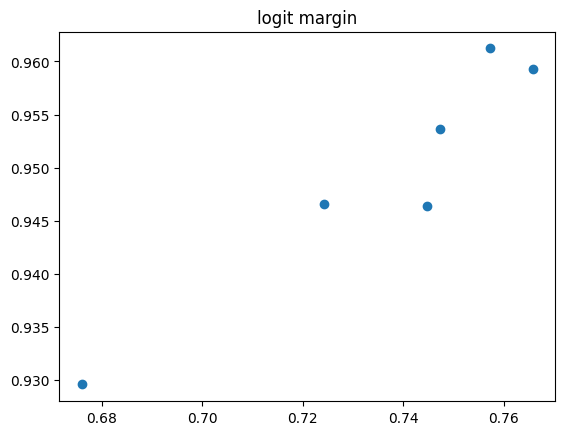

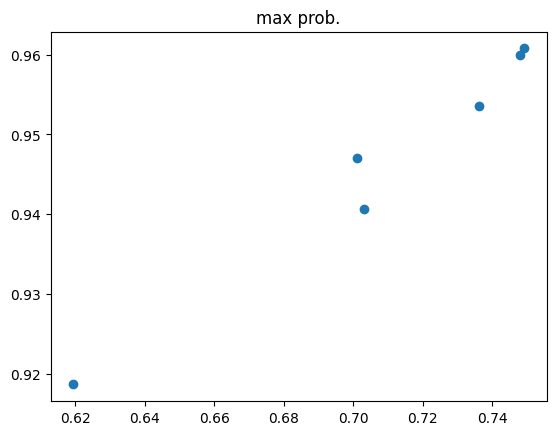

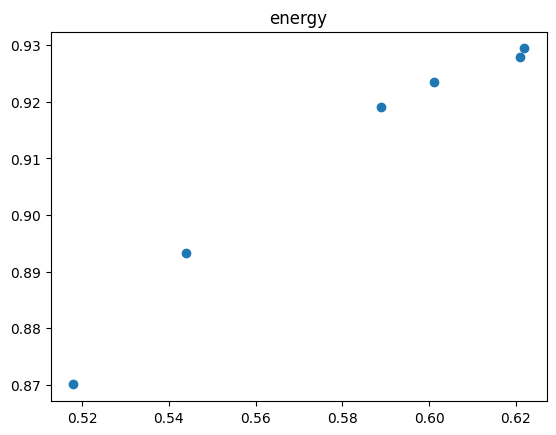

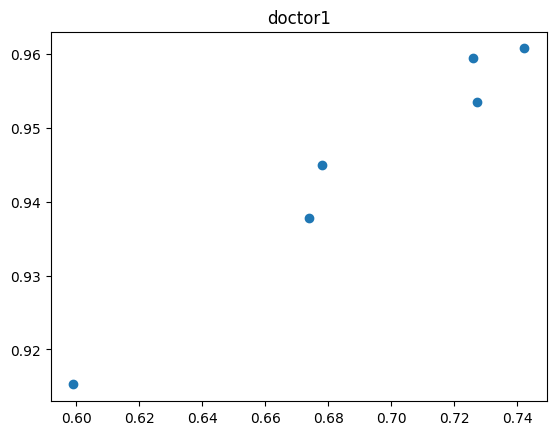

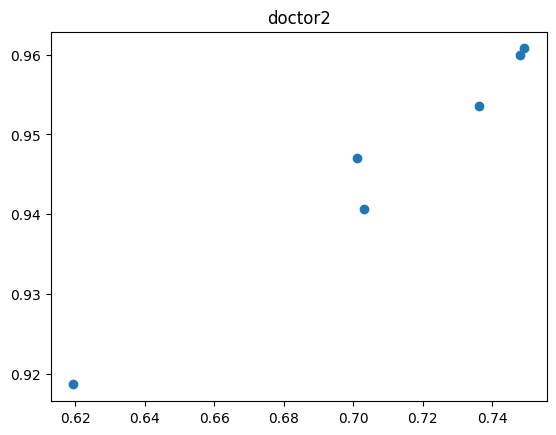

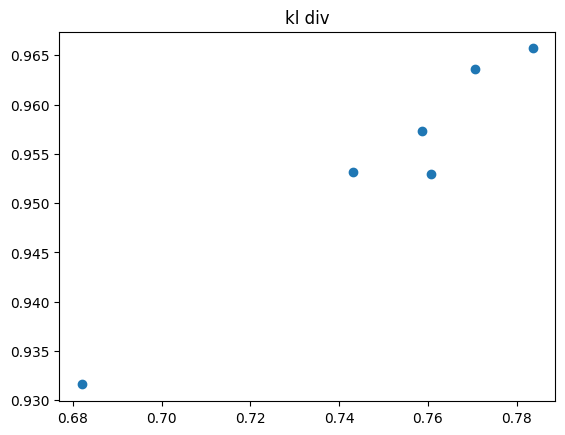

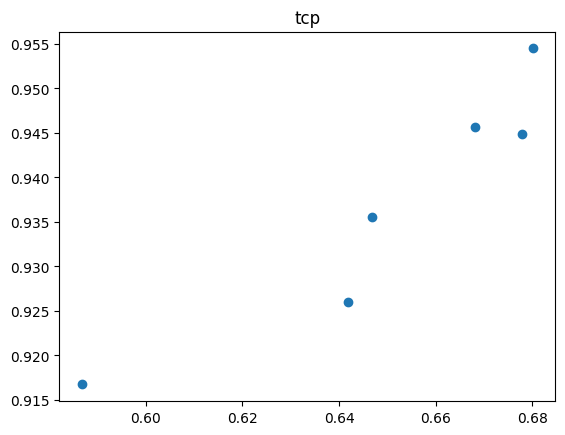

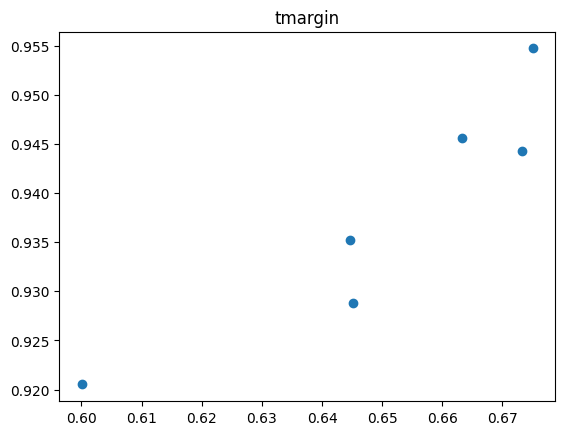

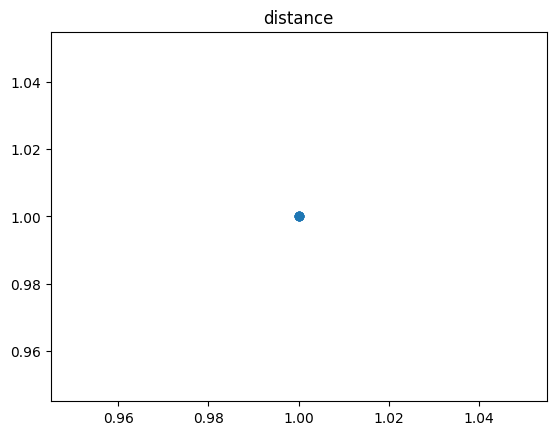

In [158]:
# TAU vs AUC
scorename='max prob.'
xmodels=[model for model in models if robust_accuracies[model]>0]
for scorename in scnames:
    j = scnames.index(scorename)
    xmodels=[model for model in xmodels if abs(kdlcors[model][j])>0.5]
    taucor = [abs(kdlcors[model][j]) for model in xmodels]
#     taucor = [robust_accuracies[model] for model in xmodels]
    aucscores = [robres['auroc'][model][j] for model in xmodels]
    plt.figure()
    plt.scatter(taucor, aucscores);
    plt.title(scorename)
    plt.show()
    plt.close()

In [159]:
def get_theta(m1, m2):
    theta = abs(np.arctan(m1)-np.arctan(m2))*180/np.pi
    return theta
assert abs(get_theta(1,1))<1e-5
assert abs(get_theta(1,-1)-90)<1e-5
def seplm(x, y, tr=0):
    xpos = np.where(x>=tr)[0]
    xneg = np.where(x<tr)[0]
    x1, y1 = x[xneg], y[xneg]
    x2, y2 = x[xpos], y[xpos]
    xx = np.linspace(min(x), max(x))
    lr1 = sklearn.linear_model.LinearRegression()
    lr1 = lr1.fit(np.array(x1).reshape(-1,1), np.array(y1))
    
    lr2 = sklearn.linear_model.LinearRegression()
    lr2 = lr2.fit(np.array(x2).reshape(-1,1), np.array(y2))

    m1, m2 = lr1.coef_[0], lr2.coef_[0]
#     mtest = -1/m2
    theta = get_theta(m1, m2)
    alpha, beta = np.arctan(abs(m1))*180/np.pi, np.arctan(abs(m2))*180/np.pi
#     thetatest = get_theta(mtest, m2)
#     assert abs(thetatest-90)<1e-5

    yr1 = lr1.predict(xx.reshape(-1,1))
    yr2 = lr2.predict(xx.reshape(-1,1))
#     plt.plot(xx, yr1, '-.')
#     plt.plot(xx, yr2, '-.')
#     plt.plot(xx, mtest*xx+lr2.intercept_, color='black')
#     plt.ylim(min(min(yr1), min(yr2)), max(max(yr1), max(yr2)))
    deviation = abs(45 - min(alpha, beta))
    coherence = True if m1*m2 > 0 else False
    return coherence

In [223]:
def plot_histandcloud(model, scorename, scoreref, labelpos, labelneg,
                      tr, r_min, r_max,
                     ufs, ufs_ref, positiveflags,
                      balanceflag=True, x_val=None,
                     pl=None,
                     idxs=None):
#     modelauprs = dict()
#     modelaurocs = dict()
#     modelkdcors=dict()
#     modelkdcors_pos =dict()
#     modelkdcors_neg = dict()
    if idxs is None:
        idxs = np.arange(len(ufs))
########ECE #######
    outpath = get_out_path(model)
    out = torch.load(outpath, map_location=torch.device('cpu'))
#     print(model, idxs)
    pmean = np.array(torch.softmax(out, dim=1))[idxs]        
    ylabel = np.array(labels_oneh)[idxs]
######
########
    positiveflags = np.array(positiveflags)
#     print(len(ufs), len(ufs_ref))
    scoresign = np.sign(sum(ufs))
    #restrict?
    c1 = ufs_ref >=r_min
    c2 = ufs_ref <=r_max
    restrict_idx = np.array([a&b for a, b in list(zip(c1, c2))])
    ufs, ufs_ref, positiveflags = ufs[restrict_idx], ufs_ref[restrict_idx], positiveflags[restrict_idx]
    pmean = pmean[restrict_idx]
    ylabel = ylabel[restrict_idx]
#     print(len(ufs), len(ufs_ref))
    restrict_idx2 = balance(ufs_ref, ufs, tr)
    ufsr2, ufs_refr2, posflagsr2 = ufs[restrict_idx2], \
                                    ufs_ref[restrict_idx2], \
                                    positiveflags[restrict_idx2]
    cor = scipy.stats.kendalltau(ufs_refr2,scoresign*ufsr2)[0]
    cor_pos = scipy.stats.kendalltau(ufs_refr2[posflagsr2],
                                   scoresign*ufsr2[posflagsr2])[0]
    cor_neg = scipy.stats.kendalltau(ufs_refr2[~posflagsr2],
                                   scoresign*ufsr2[~posflagsr2])[0]
    print(f"{model}, cor(pos):{cor_pos:.2f} cor(neg):{cor_neg:.2f}")
    if balanceflag:
        ufs, ufs_ref, positiveflags = ufsr2, ufs_refr2, posflagsr2
        pmean = pmean[restrict_idx2]
        ylabel = ylabel[restrict_idx2]
        cor = scipy.stats.kendalltau(ufs_ref, ufs)
#     pos = np.array(ufs_ref<tr)
#     print(pos, positiveflags)
#     assert (positiveflags== pos).all()
#     N = len(ufs)
#     x1= [ufs[i]  for i in range(N) if positiveflags[i]]
#     x2 = [ufs[i]  for i in range(N) if ~positiveflags[i]]
#     assert len(x1)+len(x2)==N
########ECE #######f
    restricted_ece, restricted_mce = calibration_error(ylabel, pmean)
######Rel graph
    if 'cal' in pl:
        draw_reliability_graph(pmean.flatten(), ylabel.flatten())

#######HISTOGRAMS
    fpr, tpr, _ = roc_curve(positiveflags, ufs)
    aucsc= calc_auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(positiveflags, ufs)
    auprsc=calc_auc(rec, prec)
    fpr95, _ , x_value = get_FPR_at_TPR(positiveflags, ufs, 0.95)
    fpr80, _ , _ = get_FPR_at_TPR(positiveflags, ufs, 0.80)
#     print(scoresign*x_value)
    if x_val:
        x_value = x_val
    if 'hist' in pl:
        plt.hist(scoresign*ufs[positiveflags], label=labelpos, density=True);
        plt.hist(scoresign*ufs[~positiveflags], label=labelneg, alpha=0.5, density=True);
        plt.axvline(scoresign*x_value, color='r', linestyle='dashed', linewidth=2)
        plt.xlabel(scorename)
        plt.title(model);
        plt.legend();
        plt.show()
        plt.close()
#####################ROC
    if 'roc' in pl:
        plt.figure()
        plot_roc(model, cor, fpr, tpr)
        plt.show()
        plt.close()
#####################PR
    if 'pr' in pl:
        plt.figure()
        plot_pr(model, cor, prec, rec)
        plt.show()
        plt.close()
####################CLOUD
    if 'cloud' in pl:
        plt.figure()
        print('Ding dong')
        plt.axvline(tr, color='b', linestyle='dashed', linewidth=2)
        plt.axhline(scoresign*x_value, color='r', linestyle='dashed', linewidth=2)
        plt.scatter(ufs_ref[positiveflags], scoresign*ufs[positiveflags], label=labelpos, s=5)
        plt.scatter(ufs_ref[~positiveflags], scoresign*ufs[~positiveflags], label=labelneg, s=5)

###################QUADRANT
        qtopleft = np.logical_and(np.array(ufs>x_value), np.array(ufs_ref<tr))
        xp = min(ufs_ref)
        yp = scoresign*max(ufs)
        plt.text(xp, yp, f"{sum(qtopleft)}")
    #     print(xp, yp, sum(qtopleft))

        qtopright = np.logical_and(np.array(ufs>x_value), np.array(ufs_ref>=tr))
        xp = (tr+max(ufs_ref))/2
        yp = (x_value+max(ufs))/2 if scoresign>0 else scoresign*max(ufs)
        plt.text(xp, yp, f"{sum(qtopright)}")    
    #     print(xp, yp)

        qbotleft = np.logical_and(np.array(ufs<=x_value), np.array(ufs_ref<tr))
        xp = min(ufs_ref)
        yp = scoresign*min(ufs)
        plt.text(xp, yp, f"{sum(qbotleft)}")
    #     print(xp, yp, sum(qbotleft), ufs[qbotleft])

        qbotright= np.logical_and(np.array(ufs<=x_value), np.array(ufs_ref>=tr))
        xp = (tr+max(ufs_ref))/2
        yp = scoresign*min(ufs)
        plt.text(xp, yp, f"{sum(qbotright)}") 
    #     print(xp, yp)
        a, b, c, d = sum(qtopleft), sum(qtopright), sum(qbotleft), sum(qbotright)
        total = a+b+c+d
#         print(a, b, c, d, total, len(ufs))
        assert total == len(ufs)
        
#         model_ece = restricted_ece if balanceflag else ece
#         plt.text(tr, scoresign*x_value, f"ece:{model_ece*100:.2f}")
    #     plt.ylim(min(ufs)-0.1, max(ufs)+0.1)
        plt.xlabel(scoreref)
        plt.ylabel(scorename)
#         coherence = seplm(ufs_ref, ufs, tr)
        # {coherence}, 
        #Total:{len(ufs)}
        title=f"{getps(model)}, cor: {cor:.2f}, aupr:{auprsc:.2f}, auroc:{aucsc:.2f}, fpr95:{fpr95:.2f}"#/{fpr80:.2f}"
        plt.title(title)
        plt.legend(loc='lower right')
        plt.show()
        plt.close()
    #     ##
    return fpr95, aucsc, auprsc

In [224]:
# Ding2020MMA Sehwag2021Proxy_R18 Cui2023Decoupled_WRN-28-10
# Xu2023Exploring_WRN-28-10
def plot_ultimate(labelpos='Incorrect',
                 labelneg='Correct',
                    tr = 0,
                    r_min = -10,
                    r_max = 10,
                    scoreref='tmargin',
                    x_val=None, #-eps
      pl=['cloud'], balanceflag=False,
                 xmodels = models,
                 scores=scnames):
#     idxs = np.random.choice(np.arange(10000),nb_samples,replace=False)
    idxs = np.arange(10000)
    jref = scoreref
    for scorename in scores:
#         print(scorename)
        fprs=[]
        aurocs=[]
        auprs=[]
        j=scorename
        s= -1 if kdlcors[xmodels[0]][j]>0 else 1
        sortedargs =np.argsort([kdlcors[xmodels[i]][j] for i in range(len(xmodels))])[::-1]
        sortedargs = [i for i in sortedargs if abs(kdlcors[xmodels[i]][j])>0.5]
        #
#         if scorename == 'dnet':
#             continue
        kxmodels = [xmodels[i] for i in sortedargs]
        for model in kxmodels:
            ufs = s*np.array(unfilteredmodelscores[model][j][idxs])
            ufs_ref = np.array(unfilteredmodelscores[model][jref][idxs])
    #         ufs[ufs_ref<0] = - ufs[ufs_ref<0]
            if labelpos == 'Incorrect':
                positiveflags = ~correct_predictions[model][idxs]
            else:
                positiveflags = nonrobust_flags[model][idxs]
#             print('plot')
            fpr, auroc,aupr  = plot_histandcloud(model, scorename, scoreref, labelpos, labelneg,
                      tr, r_min, r_max, ufs, ufs_ref, positiveflags,
                      balanceflag, x_val, pl,idxs=None)
#             (model,scorename, scoreref, labelpos, labelneg,
#                               tr, r_min, r_max,
#                              ufs, ufs_ref, positiveflags,balanceflag, x_val,
#                              pl)
            fprs.append(fpr), aurocs.append(auroc), auprs.append(aupr)
        fprs, aurocs, auprs = np.array(fprs), np.array(aurocs), np.array(auprs)
    #     print(fprs.min(), fprs.max(), fprs.mean(), aucs.min(), aucs.max(), aucs.mean())
    #     print()

Xu2023Exploring_WRN-28-10, cor(pos):1.00 cor(neg):1.00
Ding dong


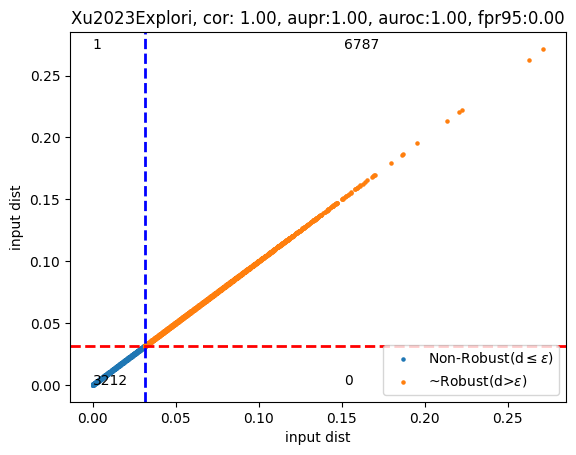

In [225]:
plot_ultimate(labelpos = "Non-Robust(d$\leq \epsilon$)", 
              labelneg = "~Robust(d>$\epsilon$)",
                tr=eps,
                r_min = 0,
                r_max = 100*eps,
                scoreref='input dist',
                balanceflag=False,
                x_val=None,
                pl=['cloud'],
                xmodels = ['Xu2023Exploring_WRN-28-10'],
                scores=scnames)#['max prob.']

In [226]:
plot_ultimate(labelpos='Incorrect',
             labelneg='Correct',
                    tr = 0,
                    r_min = -10,
                    r_max = 10,
                    scoreref='tmargin',
                    x_val=None, #-eps
                    pl=['cloud'], balanceflag=False,
                 xmodels = [model for model in models if robust_accuracies[model]>1], #['Hendrycks2019Using'],
             scores=['prob. margin'])

KeyError: 'tmargin'

In [129]:
# from nbutils import plot_bar
def plot_bar_ultimate(labelpos='Incorrect',
                 labelneg='Correct',
                    tr = 0,
                    scoreref='tmargin',
                 xmodels = None,
                 scores=scnames):
    idxs = np.arange(10000)
    jref = scoreref
    for scorename in scores:
        j=scorename
        s= -1 if kdlcors[xmodels[0]][j]>0 else 1
        sortedargs =np.argsort([kdlcors[xmodels[i]][j] for i in range(len(xmodels))])[::-1]
        # sortedargs = [i for i in sortedargs if abs(kdlcors[xmodels[i]][j])>0.5]
        kxmodels = [xmodels[i] for i in sortedargs]
        for model in kxmodels:
            ufs = s*np.array(unfilteredmodelscores[model][j][idxs])
            ufs_ref = np.array(unfilteredmodelscores[model][jref][idxs])
            if labelpos == 'Incorrect':
                positiveflags = ~correct_predictions[model][idxs]
            else:
                positiveflags = nonrobust_flags[model][idxs]
            plot_bar(model, scorename, scoreref, labelpos, labelneg,
                      tr, ufs, ufs_ref, positiveflags, idxs=None)

In [149]:
# plot_bar_ultimate(labelpos='Incorrect',
#              labelneg='Correct',
#                     tr = 0,
#                     scoreref='tmargin',
#                  xmodels = ['Addepalli2021Towards_RN18'],#[model for model in models if robust_accuracies[model]>1],
#              scores=['max prob.'])
# plot_bar_ultimate(labelpos='Incorrect',
#              labelneg='Correct',
#                     tr = 0,
#                     scoreref='tmargin',
#                  xmodels = ['Addepalli2021Towards_RN18'],#[model for model in models if robust_accuracies[model]>1],
#              scores=['prob. margin'])
# plot_bar_ultimate(labelpos='Incorrect',
#              labelneg='Correct',
#                     tr = 0,
#                     scoreref='tmargin',
#                  xmodels = ['Addepalli2021Towards_RN18'],#[model for model in models if robust_accuracies[model]>1],
#              scores=['input dist'])
# plot_bar_ultimate(labelpos='Incorrect',
#              labelneg='Correct',
#                     tr = 0,
#                     scoreref='tmargin',
#                  xmodels = ['Addepalli2021Towards_RN18'],#[model for model in models if robust_accuracies[model]>1],
#              scores=['tcp'])

In [271]:
# kdlcors[]
xmodels[0]

['Addepalli2021Towards_RN18']

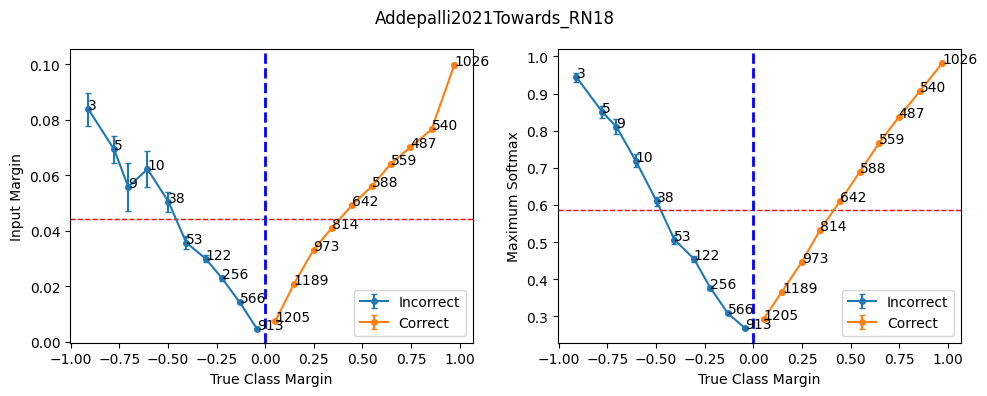

In [360]:
labelpos='Incorrect'
labelneg='Correct'
tr = 0
scoreref='tmargin'
xmodels = ['Addepalli2021Towards_RN18']#[model for model in models if robust_accuracies[model]>1],
scores=['input dist' , 'max prob.']
idxs = np.arange(10000)
# jref = scoreref
plt.figure(figsize=(10, 4))
counter=0
for scorename in scores:
    j=scorename
    s= -1 if kdlcors[xmodels[0]][j]>0 else 1
    sortedargs =np.argsort([kdlcors[xmodels[i]][j] for i in range(len(xmodels))])[::-1]
    # sortedargs = [i for i in sortedargs if abs(kdlcors[xmodels[i]][j])>0.5]
    kxmodels = [xmodels[i] for i in sortedargs]
    for model in kxmodels:
        counter=counter+1
        ufs = s*np.array(unfilteredmodelscores[model][j][idxs])
        ufs_ref = np.array(unfilteredmodelscores[model][jref][idxs])
        if labelpos == 'Incorrect':
            positiveflags = ~correct_predictions[model][idxs]
        else:
            positiveflags = nonrobust_flags[model][idxs]
        positiveflags = np.array(positiveflags)
        scoresign = np.sign(sum(ufs))
        X1, Y1 = ufs_ref[positiveflags], scoresign*ufs[positiveflags]
        X2, Y2 = ufs_ref[~positiveflags], scoresign*ufs[~positiveflags]
        plt.subplot(1,2,counter)
        plx(X1, Y1, label=labelpos, shownumbers=True)
        plx(X2, Y2, label=labelneg, shownumbers=True)
        ##
        fpr, tpr, _ = roc_curve(positiveflags, ufs)
        aucsc= calc_auc(fpr, tpr)
        prec, rec, _ = precision_recall_curve(positiveflags, ufs)
        auprsc=calc_auc(rec, prec)
        fpr95, _ , x_value = get_FPR_at_TPR(positiveflags, ufs, 0.95)
        plt.axhline(x_value*scoresign, color='r', linestyle='dashed', linewidth=1)
#         plx(ufs_ref, scoresign*ufs)
#         dt = pd.DataFrame({'score': scoresign*ufs, 'tmargin': ufs_ref})
#         px.scatter(dt, x="tmargin", y="score", marginal_x='histogram', marginal_y='histogram')#, y="score", );
        plt.axvline(tr, color='b', linestyle='dashed', linewidth=2)
        xlabel = "True Class Margin" if scoreref == 'tmargin' else scoreref
        if scorename=='tcp':
            ylabel = "TCP"
        elif scorename == 'prob. margin':
            ylabel ="Probabbilistic Margin"
        elif scorename == 'max prob.':
            ylabel ="Maximum Softmax"
        elif scorename == "input dist":
            ylabel ="Input Margin"
        else:
            print(score)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
#         title=f"{getps(model)}"
#         plt.title(title)
        plt.legend(loc='lower right')
#         savetag=f"{scorename}_bar_tmargin.pdf"
#         plt.savefig(savetag)
#         plt.show()
#         plt.close()
#         plt.gca().remove()

# Add a common title for the entire figure
plt.suptitle(model)
plt.tight_layout()
savetag=f"bar_truemargin.pdf"
plt.savefig(savetag)

plt.show()

In [332]:
dt = pd.DataFrame({'score': scoresign*ufs, 'tmargin': ufs_ref})
px.scatter(dt, x="tmargin", y="score", marginal_x='histogram', marginal_y='histogram')

In [317]:
# sns.scatterplot(data=dt, x="tmargin", y="score")
# with pd.option_context('mode.use_inf_as_na', True):
#     sns.rugplot(data=dt, x="tmargin", y="score")
# plt.show()

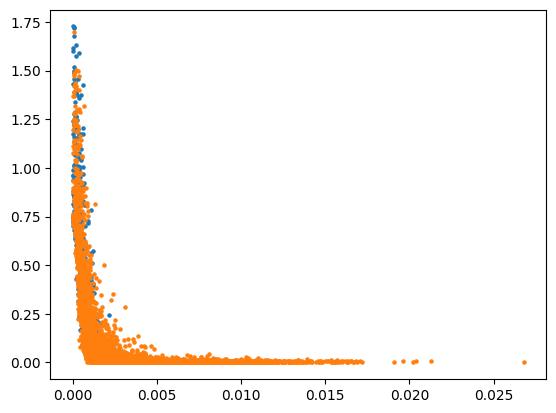

In [190]:
labelpos='Incorrect'
labelneg='Correct'
jref=scnames.index('distance')
j=scnames.index('entropy')
idxs=np.arange(10000)
kxmodels=[model for model in models if robust_accuracies[model]<1]
scoresign=1
labelpos
for model in kxmodels:
    ufs = np.array(unfilteredmodelscores[model][j][idxs])
    ufs_ref = np.array(unfilteredmodelscores[model][jref][idxs])
    positiveflags = ~correct_predictions[model][idxs]
    plt.scatter(ufs_ref[positiveflags], scoresign*ufs[positiveflags], label=labelpos, s=5)
    plt.scatter(ufs_ref[~positiveflags], scoresign*ufs[~positiveflags], label=labelneg, s=5)


Tmargin $= P[y] - \max_{j\neq y} P[j]$ , Difference between the softmax confidence at true class index and the maximum of the others.

If Tmargin > 0, prediction is correct

If Tmargin < 0, prediction is incorrect

In [192]:
crl = dict()
cnrl = dict()
icrl = dict()
icnrl = dict()
for model in xmodels:
    N = len(correct_predictions[model])#[test_indexes])
    crpds = correct_predictions[model]#[test_indexes]
    nrbfs = nonrobust_flags[model]#[test_indexes]
    print(model, f"acc:{clean_accuracies[model]:.2f}, rob acc:{robust_accuracies[model]:.2f}, tau:{kdlcors[model][0]:.2f}")
    print(f"\t\t Robust  Non-Robust")
    cr = (crpds & ~nrbfs).sum()
    cnr = (crpds & nrbfs).sum()
    print(f"Correct \t {100*cr/N:.2f}\t{100*cnr/N:.2f}\t\t{100*(cr+cnr)/N:.2f}")
    icr = (~crpds & ~nrbfs).sum()
    icnr = (~crpds & nrbfs).sum()
    print(f"Incorrect \t {100*icr/N:.2f}\t{100*icnr/N:.2f}\t\t{100*(icr+icnr)/N:.2f}")
    print(f"\t\t{100*(cr+icr)/1e4:.2f}\t{100*(cnr+icnr)/1e4:.2f}")
    assert cr+cnr+icr+icnr == N
    print("\n\n")
    crl[model] = cr/100
    cnrl[model] = cnr/100
    icrl[model] = icr/100
    icnrl[model] = icnr/100

mart_loss_r18_ckpt acc:79.69, rob acc:39.12, tau:-0.59
		 Robust  Non-Robust
Correct 	 40.01	39.68		79.69
Incorrect 	 0.76	19.55		20.31
		40.77	59.23



madry_loss_r18_ckpt acc:81.85, rob acc:36.91, tau:-0.71
		 Robust  Non-Robust
Correct 	 37.88	43.97		81.85
Incorrect 	 0.51	17.64		18.15
		38.39	61.61



trades_loss_r18_ckpt acc:80.72, rob acc:42.23, tau:-0.64
		 Robust  Non-Robust
Correct 	 42.88	37.84		80.72
Incorrect 	 1.05	18.23		19.28
		43.93	56.07



clp_loss_r18_ckpt acc:81.12, rob acc:40.08, tau:-0.70
		 Robust  Non-Robust
Correct 	 40.99	40.13		81.12
Incorrect 	 0.94	17.94		18.88
		41.93	58.07



alp_loss_r18_ckpt acc:80.38, rob acc:40.21, tau:-0.66
		 Robust  Non-Robust
Correct 	 40.97	39.41		80.38
Incorrect 	 0.91	18.71		19.62
		41.88	58.12



mma_loss_r18_ckpt acc:82.94, rob acc:37.28, tau:-0.73
		 Robust  Non-Robust
Correct 	 38.21	44.73		82.94
Incorrect 	 0.36	16.70		17.06
		38.57	61.43





In [1159]:
##ALL SCORES ARE CORRELATED
print(model)
# lsc=['entropy',
#  'quadratic',
#  'prob. margin', 'max prob.', 'spherical']

corelated_scores=set()
#[("tmargins", "tmargins")]
for score1, score2 in combinations(scnames[:], 2):
# for score1, score2 in combinations(lsc, 2):
    if 'tmargins' not in [score1, score2]:
        continue
    i,j = scnames.index(score1), scnames.index(score2)
    cond = lambda x: robust_accuracies[x]>1 and 'loss' not in x
    xsc1 = unfilteredmodelscores[model][i][test_indexes]
    ysc2 = unfilteredmodelscores[model][j][test_indexes]
    tr=0
    if 'tmargins' == score1:
        xsc1, ysc2 = balance(xsc1, ysc2, tr=tr)
        a =caucrocscores[model][j]
        f =cfprattpr_values[model][j][1]
        t =cfprattpr_values[model][j][2]
        sc = score2
    elif'tmargins' == score2:
        xsc1, ysc2 = balance(ysc2, xsc1, tr=tr)
        a =caucrocscores[model][i]
        f =cfprattpr_values[model][i][1]
        t =cfprattpr_values[model][i][2]
        sc=score1
    else:
        pass
#     _,_,t = get_FPR_at_TPR(x<tr, y, 0.95)
    cor = scipy.stats.pearsonr(xsc1,ysc2)[0]
    if abs(cor)>0.90:
        print(f"{cor:.2f} {score1}-{score2}")
        plt.figure()
        plt.scatter(xsc1[xsc1<tr], ysc2[xsc1<tr], label='Incorrect'+sc+f"{theta:0.2f}");
        plt.scatter(xsc1[xsc1>=tr], ysc2[xsc1>=tr], label='Correct'+sc+f"{theta:0.2f}");
        theta = seplm(xsc1, ysc2)
        plt.title(f"{sc}, angle: {theta:0.2f}, auc:{a:.2f}, fpr95:{f:.2f}")
        plt.axhline(abs(t), color='r', linestyle='--')
        plt.legend()
#         plt.figure()
#         plt.hist(ysc2[xsc1<tr], label='Incorrect')
#         plt.hist(ysc2[xsc1>=tr], alpha=0.5, label='Correct')
#         plt.axvline(abs(t), color='r', linestyle='--')
#         plt.legend()

#     if abs(cor)>0.80:
#         corelated_scores.add(score1)
#         corelated_scores.add(score2)
#     plt.close()
# print(set(scnames[:-3])==corelated_scores,corelated_scores)

Addepalli2021Towards_RN18


In [1161]:
from sklearn.datasets import make_moons

In [1240]:
# Generate the dataset
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
X, y = torch.Tensor(X), torch.Tensor(y)
##Add dim 3 to x
D=0
in_feat =2+D
X = torch.hstack([X, torch.zeros(300,D).uniform_(-0.01, 0.01)])
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#
moonmodel = DeepNet(MoonNet(in_features=in_feat),
                   loss_fn=torch.nn.BCELoss(),
                    classifier=True, verbose=False)
tr_set = toDataset(X_train, y_train)
moonmodel.num_epochs = 200
moonmodel.train(tr_set)

  0%|          | 0/200 [00:00<?, ?it/s]

In [1241]:
tr_set = toDataset(X_train, y_train)
ts_set = toDataset(X_test, y_test)
moonmodel.test(tr_set), moonmodel.test(ts_set)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

((0.8761904761904762, tensor(0.3228)), (0.9, tensor(0.2885)))

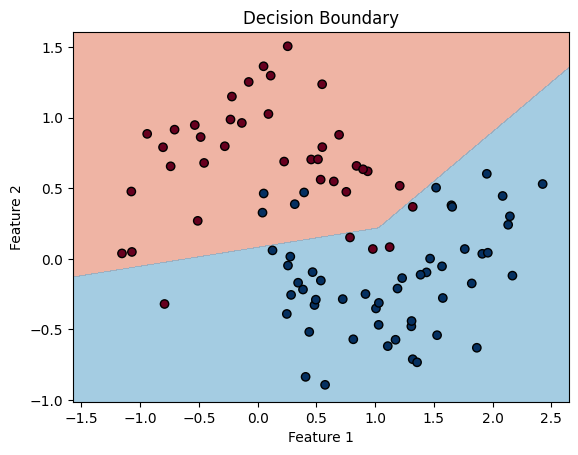

In [1242]:
# Decision boundary visualization
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
XY = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
XY = torch.hstack([XY, torch.zeros(len(XY), D)])
Z = moonmodel.predict(XY).detach()
Z = Z.reshape(xx.shape)
Zlogit = moonmodel.model.get_embed()
xxx=XY[:, 0].reshape(xx.shape)
yyy=XY[:, 1].reshape(xx.shape)
plt.contourf(xxx, yyy, Z, levels=[0, 0.5, 1], cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdBu, edgecolors='k')
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()

In [1181]:
# scores = calc_lmargin(torch.Tensor(X_testl))

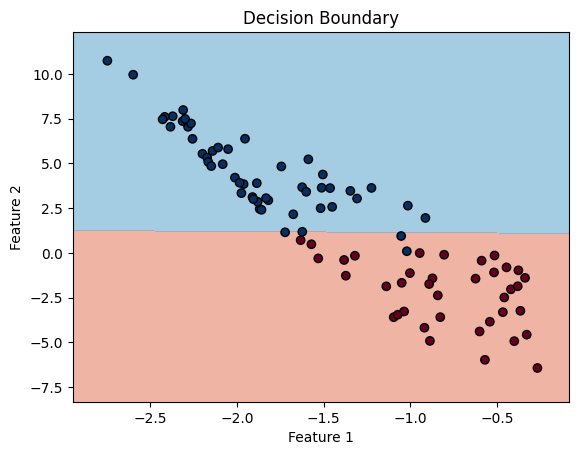

In [1182]:
moonmodel.model(X)
Xe = moonmodel.model.get_embed().detach().numpy()
moonmodel.model(X_test)
X_testl = moonmodel.model.get_embed().detach().numpy()
# Decision boundary visualization
x_min, x_max = Xe[:, 0].min() - 0.1, Xe[:, 0].max() + 0.1
y_min, y_max = Xe[:, 1].min() - 0.1, Xe[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
XY = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
Z = moonmodel.model.fc3(XY)
Z = torch.sigmoid(Z).detach().numpy()
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X_testl[:, 0], X_testl[:, 1], c=y_test, cmap=plt.cm.RdBu, edgecolors='k')
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()

In [1183]:
# def inv_sigmoid(y):
#     return np.log(y/(1-y))

In [1186]:
x_adv, itr = deepfool(moonmodel.model, x=X_test[4], max_iter=1)

In [1185]:
# from pgd_adaptive import deepfool_attack as deepfool
def deepfool(model, x, eps_iter=.01, max_iter=100):
    """DeepFool attack"""
    model.eval()
    nx = x.clone()
    nx.requires_grad_()
    eta = torch.zeros(nx.shape).cuda() if torch.cuda.is_available() else torch.zeros(nx.shape)

    f = model(nx+eta)
    initial_label = f>=0.5

    i_iter = 0
#     cumul_dis_2 = 0.
#     cumul_dis_inf = 0.
    while (f>=0.5) == initial_label and i_iter < max_iter:
        f.backward(retain_graph=True)
        grad_np = nx.grad.data.clone()
        gradnorm = torch.linalg.norm(grad_np.flatten(), 2)
#         if gradnorm==0.:
#             nxx = nx.clone()+torch.Tensor([-0.4, -0.1])
#             nxx.requires_grad_()
#             f = model(nxx+eta)
#             f.backward(retain_graph=True)
#             grad_np = nx.grad.data.clone()
#             gradnorm = torch.linalg.norm(grad_np.flatten(), 2)
#             nxx.grad.data.zero_()
        value_l = torch.abs(f) / (gradnorm+1e-12)
        ri = - value_l * grad_np
#         print(x, ri, grad_np)
        #
#         cumul_dis_inf += compute_norm(ri, norm=np.inf)
#         cumul_dis_2 += compute_norm(ri, norm=2)
        #
        eta += eps_iter*ri.clone()
        nx.grad.data.zero_()
        f = model(nx+eta)
        i_iter += 1

#     cumul_dis = {'2': cumul_dis_2, 'inf': cumul_dis_inf}
    return x+eta.detach(), i_iter#, cumul_dis

In [1187]:
xl =[]
for i in tqdm(range(len(X_test))):
#     print(X_test[i].shape)
    x_adv, itr =deepfool(moonmodel.model, 
                      x=X_test[i], max_iter=200)
#     print(torch.linalg.norm(x_adv-X_test[i], 2), itr)
    xl.append(x_adv)
#     break
x_adv = torch.vstack(xl)

  0%|          | 0/90 [00:00<?, ?it/s]

In [1188]:
ypred = (moonmodel.model(x_adv[4])>=0.5).ravel()
(ypred.eq(y_test[4])).float().mean()

tensor(1.)

In [1189]:
ypred = (moonmodel.model(X_test)>=0.5).ravel()
ypreda = (moonmodel.model(x_adv)>=0.5).ravel()
(ypred.eq(y_test)).float().mean(), (ypreda.eq(ypred)).float().mean()

(tensor(0.9778), tensor(0.4667))

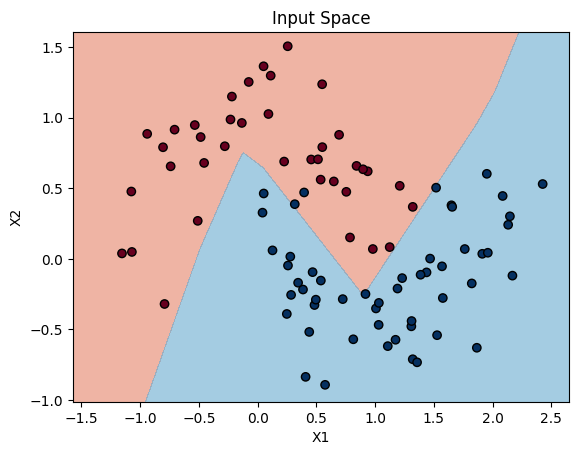

In [1228]:
# Decision boundary visualization
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
XY = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
XY = torch.hstack([XY, torch.zeros(len(XY), D)])
Z = moonmodel.predict(XY).detach()
Z = Z.reshape(xx.shape)
Zlogit = moonmodel.model.get_embed()

#
ypred = (moonmodel.model(X_test)>=0.5).ravel()
ypreda = (moonmodel.model(x_adv)>=0.5).ravel()
correctpred = torch.ones(len(ypred), dtype=torch.bool)
# correctpred = ~ypred.eq(ypreda)
Xa, ya = x_adv[correctpred], y_test[correctpred]
# ya = ypred[correctpred]
X_t, y_t = X_test[correctpred], y_test[correctpred]
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap=plt.cm.RdBu, alpha=0.6)
# plt.scatter(Xa[:, 0], Xa[:, 1], c=ya, cmap=plt.cm.RdBu, edgecolors='w')
plt.scatter(X_t[:, 0], X_t[:, 1], c=y_t, cmap=plt.cm.RdBu, edgecolors='k')
for i in range(len(X_t)):
    x1, y1 = X_t[i, 0], X_t[i, 1]
    x2, y2 = Xa[i, 0], Xa[i, 1]
    cond = abs(x1-2.4255)<1e-5 or abs(x1-1.95)<0.001 or abs(x1-2.085)<0.001
#     if not cond:
#         print(x1, abs(x1-2.4255), abs(x1-1.95))
#         continue
#     print(x1,y1, x2, y2)
#     plt.plot([x1, x2], [y1, y2], marker = '',
#              linestyle='--', color='black')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Input Space')
plt.show()
# tensor(2.4255) tensor(0.5292)
# tensor(1.9502) tensor(0.6014)
# tensor(2.1467) tensor(0.3007)
# 2.1319, 2.0850

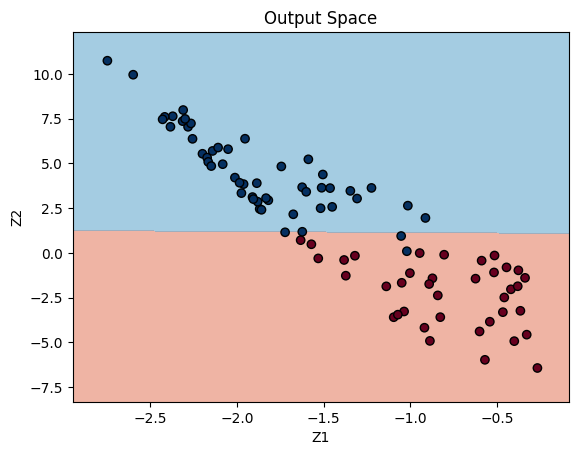

In [1230]:
# Decision boundary visualization
x_min, x_max = Xe[:, 0].min() - 0.1, Xe[:, 0].max() + 0.1
y_min, y_max = Xe[:, 1].min() - 0.1, Xe[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
XY = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
Z = moonmodel.model.fc3(XY)
Z = torch.sigmoid(Z).detach().numpy()
Z = Z.reshape(xx.shape)

#
moonmodel.model(x_adv)
x_advl = moonmodel.model.get_embed().detach().numpy()

ypred = (moonmodel.model(X_test)>=0.5).ravel()
ypreda = (moonmodel.model(x_adv)>=0.5).ravel()
correctpred = torch.ones(len(ypred), dtype=torch.bool)
# correctpred = ~ypred.eq(ypreda)
Xa, ya = x_advl[correctpred], y_test[correctpred]
# ya = ypred[correctpred]
X_t, y_t = X_testl[correctpred], y_test[correctpred]

plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap=plt.cm.RdBu, alpha=0.6)
# plt.scatter(Xa[:, 0], Xa[:, 1], c=ya, cmap=plt.cm.RdBu, edgecolors='k')
plt.scatter(X_t[:, 0], X_t[:, 1], c=y_t, cmap=plt.cm.RdBu, edgecolors='k')
# for i in range(len(X_t)):
#     x1, y1 = X_t[i, 0], X_t[i, 1]
#     x2, y2 = Xa[i, 0], Xa[i, 1]
#     plt.plot([x1, x2], [y1, y2], marker = '',
#              linestyle='--', color='black')
plt.xlabel('$Z_1')
plt.ylabel('Z2')
plt.title('Output Space')
plt.show()

SignificanceResult(statistic=0.9415730337078652, pvalue=1.869636461485254e-39)

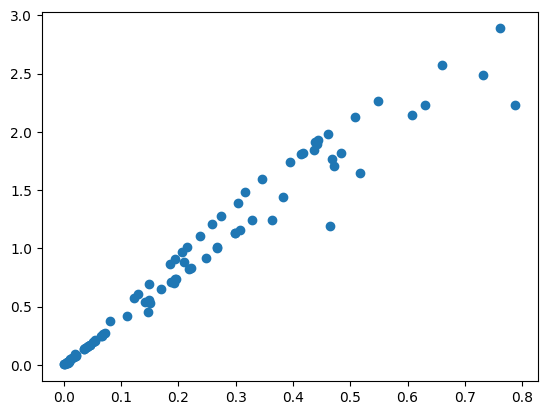

In [1250]:
scores = calc_drep(torch.Tensor(X_testl), torch.Tensor(x_advl))
dist = calc_drep(X_test, x_adv)
plt.scatter(dist, scores)
scipy.stats.kendalltau(dist, scores)

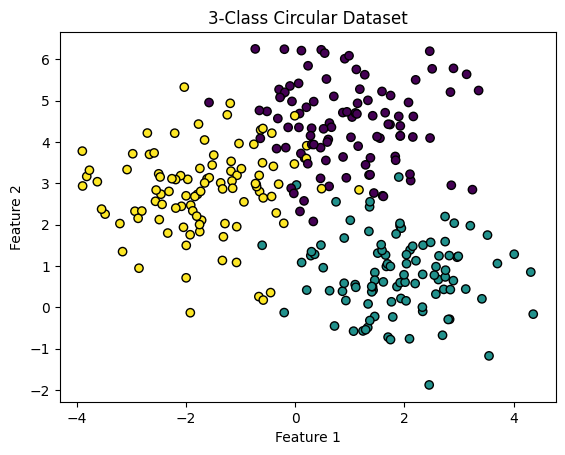

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
# Generate 3 circular clusters
X, y = make_blobs(n_samples=300, centers=3, n_features=2, random_state=0)

# Plot the data points for each class
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('3-Class Circular Dataset')
plt.show()

In [157]:
X, y = make_blobs(n_samples=300, centers=3, n_features=2, random_state=0)
X, y = torch.Tensor(X), torch.tensor(y, dtype=torch.int64)
##Add dim 3 to x
D=0
in_feat =2+D
X = torch.hstack([X, torch.zeros(300,D).uniform_(-0.01, 0.01)])
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#
moonmodel = DeepNet(MoonNet3(in_features=in_feat),
                   loss_fn=torch.nn.CrossEntropyLoss(),
                    classifier=True, verbose=False)
tr_set = toDataset(X_train, y_train)
moonmodel.num_epochs = 500
moonmodel.train(tr_set)

  0%|          | 0/500 [00:00<?, ?it/s]

In [158]:
tr_set = toDataset(X_train, y_train)
ts_set = toDataset(X_test, y_test)
moonmodel.test(tr_set), moonmodel.test(ts_set)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

((0.9476190476190476, tensor(0.1324)), (0.9111111111111111, tensor(0.3275)))

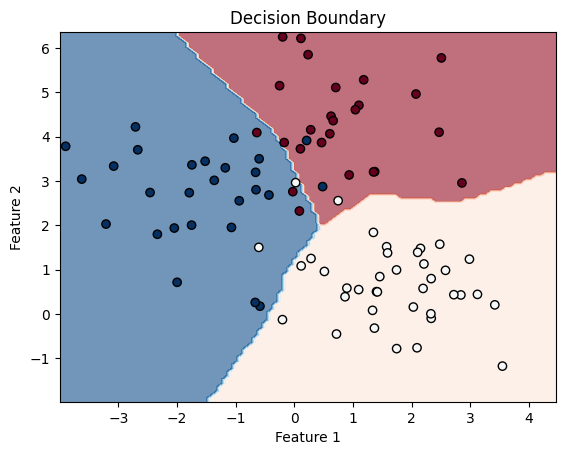

In [159]:
# Decision boundary visualization
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
XY = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
XY = torch.hstack([XY, torch.zeros(len(XY), D)])
Z = moonmodel.predict(XY).detach()
Z = Z.max(1)[1]
Z = Z.reshape(xx.shape)
Zlogit = moonmodel.model.get_embed()
xxx=XY[:, 0].reshape(xx.shape)
yyy=XY[:, 1].reshape(xx.shape)
plt.contourf(xxx, yyy, Z, cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdBu, edgecolors='k')
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()

In [149]:
from sklearn.decomposition import PCA

In [150]:
moonmodel.model(X)
Xe = moonmodel.model.get_embed().detach().numpy()
moonmodel.model(X_test)
X_testl = moonmodel.model.get_embed().detach().numpy()
# pca = PCA(n_components=2)
# pca.fit(Xe)
# Xe_pca = pca.transform(Xe)
# X_testl2 = pca.fit(X_testl)
# Decision boundary visualization
x_min, x_max = Xe[:, 0].min() - 0.1, Xe[:, 0].max() + 0.1
y_min, y_max = Xe[:, 1].min() - 0.1, Xe[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
XY = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
# XY = torch.hstack([XY, torch.zeros(len(XY), 10-2)])
Z = moonmodel.model.fc3(torch.relu(XY))
Z = Z.detach().max(1)[1]
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z,  cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X_testl[:, 0], X_testl[:, 1], c=y_test, cmap=plt.cm.RdBu, edgecolors='k')
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x2 and 10x3)

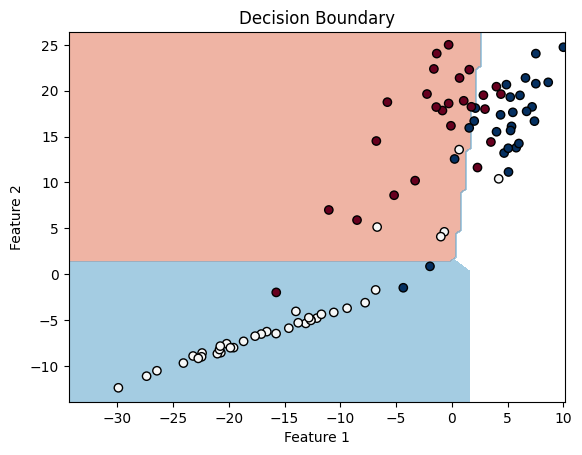

In [56]:
moonmodel.model(X)
Xe = moonmodel.model.get_embed().detach().numpy()
moonmodel.model(X_test)
X_testl = moonmodel.model.get_embed().detach().numpy()
# Decision boundary visualization
x_min, x_max = Xe[:, 0].min() - 0.1, Xe[:, 0].max() + 0.1
y_min, y_max = Xe[:, 1].min() - 0.1, Xe[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
XY = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
Z = moonmodel.model.fc3(torch.relu(XY))
Z = Z.detach().max(1)[1]
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(X_testl[:, 0], X_testl[:, 1], c=y_test, cmap=plt.cm.RdBu, edgecolors='k')
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()

In [60]:
from autoattack import AutoAttack

In [69]:
def fab_attack(model, x_test, y_test,
               norm_thread='Linf',
               device='cpu',
               new_version=True):
    max_eps =np.inf #np.sqrt(3*32*32) ## cifar10 max
    adversary = AutoAttack(model, 
                           norm=norm_thread,
                           eps=max_eps, version='custom',
                           attacks_to_run=['fab'],
                           device=device)
    x_adv, y_adv = adversary.run_standard_evaluation(x_test.to(device),
                                                     y_test.to(device), return_labels=True)
    acc = (y_test == y_adv).sum().item() / len(y_test)
    return acc, x_adv, y_adv

In [155]:
ypred = moonmodel.predict(X_test).max(1)[1]
acc, x_adv, y_adv = fab_attack(moonmodel.model, X_test, 
           y_test=ypred)

using custom version including fab.
initial accuracy: 100.00%
fab - 1/1 - 90 out of 90 successfully perturbed
robust accuracy after FAB: 0.00% (total time 0.2 s)
max Linf perturbation: 5.24741, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%


In [95]:
from pgd_adaptive import deepfool_attack

In [190]:
# ypred = moonmodel.predict(X_test).max(1)[1]
xl =[]
for i in tqdm(range(len(X_test))):
#     print(X_test[i].shape)
    x_adv, itr, _ =deepfool_attack(moonmodel.model, 
                      x=X_test[i].reshape(1,-1), max_iter=100)
#     print(torch.linalg.norm(x_adv-X_test[i], 2), itr)
    xl.append(x_adv)
#     break
x_adv = torch.vstack(xl)

  0%|          | 0/90 [00:00<?, ?it/s]

In [191]:
ypred = moonmodel.model(X_test).max(1)[1].ravel()
ypreda = moonmodel.model(x_adv).max(1)[1].ravel()
(ypred.eq(y_test)).float().mean(), (ypreda.eq(ypred)).float().mean()

(tensor(0.9111), tensor(0.0778))

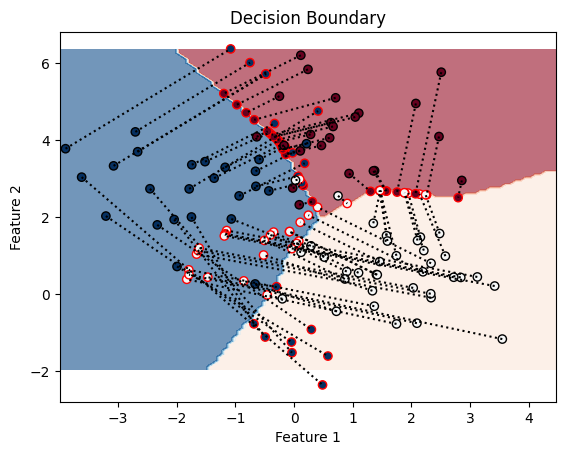

In [210]:
# Decision boundary visualization
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
XY = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
XY = torch.hstack([XY, torch.zeros(len(XY), D)])
Z = moonmodel.predict(XY).detach().max(1)[1]
Z = Z.reshape(xx.shape)
Zlogit = moonmodel.model.get_embed()

#
ypred = moonmodel.model(X_test).max(1)[1].ravel()
ypreda = moonmodel.model(x_adv).max(1)[1].ravel()
# correctpred = torch.ones(len(ypred), dtype=torch.bool)
correctpred = ~ypred.eq(ypreda)
Xa, ya = x_adv[correctpred], y_test[correctpred]
# ya = ypred[correctpred]
X_t, y_t = X_test[correctpred], y_test[correctpred]
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.6)
plt.scatter(Xa[:, 0], Xa[:, 1], c=ya, cmap=plt.cm.RdBu, edgecolors='r')
plt.scatter(X_t[:, 0], X_t[:, 1], c=y_t, cmap=plt.cm.RdBu, edgecolors='k')
for i in range(len(X_t)):
    x1, y1 = X_t[i, 0], X_t[i, 1]
    x2, y2 = Xa[i, 0], Xa[i, 1]
    plt.plot([x1, x2], [y1, y2], marker = '',
             linestyle=':', color='black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.show()

In [193]:
moonmodel.model(X_test)
X_testl = moonmodel.model.get_embed().detach().numpy()
moonmodel.model(x_adv)
x_advl = moonmodel.model.get_embed().detach().numpy()

SignificanceResult(statistic=0.7023720349563046, pvalue=1.0819996636699655e-22)

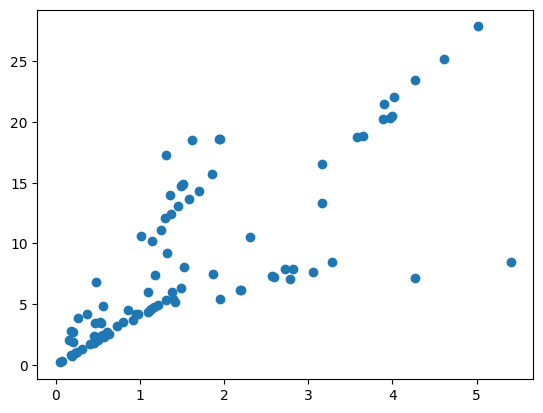

In [209]:
out = moonmodel.model(X_test).detach()
# out_adv=moonmodel.model(x_adv).detach()
scores = calc_lmargin(out)
dist = calc_drep(X_test, x_adv)
plt.scatter(dist, scores)
scipy.stats.kendalltau(dist, scores)

In [148]:
R_ = lambda d, eps: 0.5*alpha(d, eps)*eps**2 - d*h_(d, eps)

In [174]:
eps=0.5
rm = 0.5*np.pi*eps**2
1-R_(0, eps)/rm, 1-R_(eps, eps)/rm, 1+R_(eps, eps+1e-2), R_(eps, 2*eps)

(0.0, 1.0, 1.0013426331079007, 0.6141848493043783)

In [205]:
def alpha(d, eps=1.):
    return 2*np.arccos(d/eps)
def h_alpha(a, eps=1.):
    return eps*np.sin(a/2)
def h_(d, eps=1.0):
    return h_alpha(alpha(d,eps), eps)
def Ro_(d, eps=1.0):
#     if eps<1e-7:
#         return 1.
    if d > eps:
        Ar_ = lambda r : 0.5*np.pi*r**2
        return Ar_(d)/Ar_(eps)
#     R_ = alpha(d, eps)/np.pi - (2/np.pi)*d*h_(d, eps)/eps**2
    else:
        R_ = lambda d, eps: 0.5*alpha(d, eps)*eps**2 - d*h_(d, eps)
        R_max = 0.5*np.pi*eps**2
        return 1-R_(d,eps)/R_max

def Rwc_(d, eps=1.0):
#     R_ = min(d/eps, 1.)
    R_ = lambda d, eps: (eps-d)/eps
    return 1 - R_(d, eps)

In [209]:
# # Import necessary libraries
# import numpy as np
# 
# import matplotlib.pyplot as plt
from ipywidgets import interact

# Define the function x - a * y
def plot_func(eps):
    dx = np.linspace(0, min(55, 2*eps))
    R = [Ro_(d, eps) for d in dx]
    Rwc = [Rwc_(d, eps) for d in dx]
    plt.plot(dx, R, label='$Ro$')
    plt.plot(dx, Rwc, label='$Rwc$')
    plt.xlabel('d')
    plt.axvline(eps, linestyle='--')
    plt.legend()
# Create an interactive slider for 'a'
interact(plot_func, eps=(0., 1., 0.01))

# Show the plot
plt.show()

interactive(children=(FloatSlider(value=0.5, description='eps', max=1.0, step=0.01), Output()), _dom_classes=(…